# Spot The Bot- Chan Wai Hin Ben

Source: ProjectSygma from TA Stanislav Diner<br>
All  English, Russian and Chinese corpus are retrieved from the ProjectSygma google drive. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gensim
!pip install -U pip setuptools wheel
!pip install -U spacy
!spacy download en_core_web_lg
!pip install natasha

     |████████████████████████████████| 1.6MB 11.1MB/s 
     |████████████████████████████████| 829kB 40.6MB/s 
Requirement already up-to-date: wheel in /usr/local/lib/python3.7/dist-packages (0.36.2)
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
  Found existing installation: setuptools 56.1.0
    Uninstalling setuptools-56.1.0:
      Successfully uninstalled setuptools-56.1.0


     |████████████████████████████████| 12.8 MB 91 kB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 18.5 MB/s 
     |████████████████████████████████| 9.1 MB 34.3 MB/s 
     |████████████████████████████████| 456 kB 45.8 MB/s 
     |████████████████████████████████| 113 kB 74.9 MB/s 
  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107106 sha256=718593f375519fc8c08451c4ac2e9cd8a3d6b6dd6eeadf13f15bac25c3bd8a40
  Stored in directory: /root/.cache/pip/wheels/83/a6/12/bf3c1a667bde4251be5b7a3368b2d604c9af2105b5c1cb1870
Successfully built smart-open
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found ex

In [3]:
import re
import gensim
import glob
import en_core_web_lg
from tqdm import tqdm
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA #Principal Component Analysis

In [4]:
#Entropy-complexity measure
import math

def get_split_index_m(A):
    i = len(A) - 1
    while i > 0:
        if A[i] < A[i - 1]:
            i -= 1
        else:
            break
    return i - 1


def get_change_index_m(A, i):
    j = len(A) - 1
    while j >= i:
        if A[j] > A[i]:
            break
        else:
            j -= 1
    return j


def swap_m(A, i, j):
    A[i], A[j] = (A[j], A[i])


# reverse A[start:]
def reverse_m(A, start):
    left = start
    right = len(A) - 1
    while left < right:
        swap_m(A, left, right)
        left += 1
        right -= 1


def next_permutation_m(A, v):
    i = v - 1
    while i >= 0:
        split_index = get_split_index_m(A[i])
        # the Array is sorted in descreased order
        if split_index == -1:
            reverse_m(A[i], 0)
            i -= 1
        else:
            change_index = get_change_index_m(A[i], split_index)
            swap_m(A[i], split_index, change_index)
            reverse_m(A[i], split_index + 1)
            break


def factorial_m(n):
    ans = 1
    for i in range(2, n + 1):
        ans *= i
    return ans


def permutations_m(d, v):
    a = []
    for i in range(v):
        a.append([])
        for j in range(d):
            a[-1].append(j + 1)
    perm = dict()
    perm[str(a)] = 0
    for j in range(factorial_m(d) ** v - 1):
        next_permutation_m(a, v)
        perm[str(a)] = j + 1
    return perm


def s_max_m(d, v):
    return math.log(factorial_m(d) ** v)


def s_max_list_m(d, v):
    return [1 / (factorial_m(d) ** v)] * (factorial_m(d) ** v)


def p_m(arr, d, v): 
    pr = [0] * (factorial_m(d) ** v)
    permutation_dict = permutations_m(d, v)
    for i in range(d - 1, len(arr)):
        full_curr_perm = []
        for l in range(v):
            curr = []
            for j in range(i - d + 1, i + 1):
                curr.append([arr[j][l], len(curr) + 1])
            curr.sort()
            curr_perm = []
            for k in curr:
                curr_perm.append(k[1])
            full_curr_perm.append(curr_perm)
        pr[permutation_dict[str(full_curr_perm)]] += 1
    for i in range(len(pr)):
        pr[i] /= len(arr) - d + 1
    return pr


def s_m(pr):
    entropy = 0
    for i in range(len(pr)):
        if pr[i] != 0:
            entropy -= pr[i] * math.log(pr[i])
    return entropy

def q_0_calculation_m(d, v):
    pr = [0] * (factorial_m(d) ** v)
    pr[0] = 1
    b = s_max_list_m(d, v)
    b = [pr + b for pr, b in zip(pr, b)]
    b = [i * 0.5 for i in b]
    return 1 / (s_m(b) - s_m(pr) / 2 - s_max_m(d, v) / 2)

def q_j_m(arr, d, v):
    pr = p_m(arr, d, v)
    b = s_max_list_m(d, v)
    b = [pr + b for pr, b in zip(pr, b)]
    b = [i * 0.5 for i in b]
    return q_0_calculation_m(d, v) * (s_m(b) - s_m(pr) / 2 - s_max_m(d, v) / 2)

def entropy_measure_m(arr, d, v):
    return s_m(p_m(arr, d, v))/s_max_m(d, v)

def mpr_complexity_m(arr, d, v):
    return q_j_m(arr, d, v) * entropy_measure_m(arr, d, v)




def s_b(N, p, m, n):
    if p != 0:
        return -(n * p * math.log(p) + (N - m - n) * (1 - p * n) / (N - m - n) * math.log((1 - p * n) / (N - m - n)))
    else:
        return math.log(N - m - n)

def s_b_1(N, p, m, n):
    return -(m / N * math.log(1 / N) + n * (p + 1 / N) / 2 * math.log((p + 1 / N) / 2) + (N - m - n) * ((1 - p * n) / (N - m - n) + 1 / N) / 2 * math.log((((1 - p * n) / (N - m - n)) + 1 / N) / 2))

def entropy_measure_b(N, p, m, n):
    return s_b(N, p, m, n) / math.log(N)

def q_0_calculation_b(N, p, m, n):
    return 1 / (s_b(N, 1 / 2 / N, 0, N - 1) - math.log(N) / 2)


def q_j_b(N, p, m, n):import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math


def s_b(N, p, m, n):
    if p != 0:
        return -(n * p * math.log(p) + (N - m - n) * (1 - p * n) / (N - m - n) * math.log((1 - p * n) / (N - m - n)))
    else:
        return math.log(N - m - n)

def s_b_1(N, p, m, n):
    return -(m / N * math.log(1 / N) + n * (p + 1 / N) / 2 * math.log((p + 1 / N) / 2) + (N - m - n) * ((1 - p * n) / (N - m - n) + 1 / N) / 2 * math.log((((1 - p * n) / (N - m - n)) + 1 / N) / 2))

def entropy_measure_b(N, p, m, n):
    return s_b(N, p, m, n) / math.log(N)

def q_0_calculation_b(N, p, m, n):
    return 1 / (s_b(N, 1 / 2 / N, 0, N - 1) - math.log(N) / 2)


def q_j_b(N, p, m, n):
    return q_0_calculation_b(N, p, m, n) * (s_b_1(N, p, m, n) - s_b(N, p, m, n) / 2 - math.log(N) / 2)

def mpr_complexity_b(N, p, m, n):
    return q_j_b(N, p, m, n) * entropy_measure_b(N, p, m, n)

# Prepare English Corpus


In [5]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won['’‘`]t", "will not", phrase)
    phrase = re.sub(r"can['’‘`]t", "can not", phrase)
    phrase = re.sub(r"ain['’‘`]t", "am not", phrase)

    # general
    phrase = re.sub(r"n['’‘`]t", " not", phrase)
    phrase = re.sub(r"['’‘`]re", " are", phrase)
    phrase = re.sub(r"['’‘`]s", " is", phrase)
    phrase = re.sub(r"['’‘`]d", " would", phrase)
    phrase = re.sub(r"['’‘`]ll", " will", phrase)
    phrase = re.sub(r"['’‘`]t", " not", phrase)
    phrase = re.sub(r"['’‘`]ve", " have", phrase)
    phrase = re.sub(r"['’‘`]m", " am", phrase)

    #phrase = re.sub('([.;!?])', r' \1 ', phrase)
    phrase = re.sub(r'[^\w.?!;]', ' ', phrase)
    phrase = re.sub(' +', ' ', phrase)
    sentences = re.split('([.;!?] *)', phrase)

    return ' '.join([i.capitalize() for i in  sentences])

In [6]:
def prepare_english_text(input_path, output_path):
    nlp = en_core_web_lg.load(disable=['parser'])
    nlp.max_length = 5000000
    pos_dict = {'PROPN': 'PERSON1', 'PRON': 'PRON1', 'NUM': 'ORDINAL1'}
    file_name =  input_path.split('/')[-1]
    try:
        with open(input_path, 'r') as lit_text:
            raw_text = lit_text.read()
    except Exception as ex:
        return
    
    preprocessed_text = decontracted(raw_text)
    #preprocessed_list = gensim.utils.simple_preprocess(raw_text, min_len=1, max_len=100, deacc = True)
    #preprocessed_text  = ' '.join(preprocessed_list)
    
    nlp_doc = nlp(preprocessed_text)
    sorted_ents = sorted(nlp_doc.ents, key = lambda x: len(x), reverse =  True)


    for ent in sorted_ents:
        preprocessed_text = preprocessed_text.replace(' ' + ent.text + ' ', ' ' + ent.label_+ '1 ')
        if not ent.text.islower():
            preprocessed_text = preprocessed_text.replace(' ' + ent.text.lower() + ' ', ' ' + ent.label_+ '1 ')

    new_nlp_doc = nlp(preprocessed_text)

    with open(output_path + file_name, 'w') as prepared_text:
        for token in new_nlp_doc:
            if token.text[-1] != '1':
                if token.pos_ in pos_dict:
                    prepared_text.write(pos_dict[token.pos_])
                    prepared_text.write('\n')
                    
                elif token.pos_ != 'PUNCT':
                    prepared_text.write(token.lemma_.lower())
                    prepared_text.write('\n')

            else:
                prepared_text.write(token.text)
                prepared_text.write('\n')

In [7]:
nlp = en_core_web_lg.load(disable=['parser'])
nlp.max_length = 5000000

In [ ]:
file_list = glob.glob('/content/drive/MyDrive/ML_Project4/input/EnLit/*/*')

In [ ]:
from tqdm import tqdm
for path in tqdm(file_list[:20]): #For debug
    prepare_english_text(path, '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/')


100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


In [8]:
from bisect import bisect_left 
import numpy as np
def binary_search(a, x): 
    i = bisect_left(a, x) 
    if i != len(a) and a[i] == x: 
        return i 
    else: 
        return -1

def text_to_series(text_path, dictionary_path, table_path):
    file_name = text_path.split('/')[-1]
    with open(dictionary_path, 'r') as my_dict:
        dictionary = my_dict.readlines()
    table = np.load(table_path)
    
    text_serie = []
    with open(text_path, 'r') as words:
        with open('/content/drive/MyDrive/ML_Project4/input/time_series_ben/' + file_name, 'w') as file:
            for word in words:
                word_index = binary_search(dictionary, word)
                if word_index != -1:
                    if word_index > len(table)-1:#prevent out of bound
                        word_index = len(table)-1
                    word_vector = table[word_index]
                    text_serie.append(word_vector[::-1])
                    for word in reversed(word_vector):
                        file.write(str(word))
                    file.write('\n')       
    return text_serie

# Prepare Russian Corpus

In [9]:
def poem(text):
    lines = text.split('\n')
    if len(lines):
        not_poem_probability = sum([line[0].islower() for line in lines  if line]) / len(lines)
        return not_poem_probability < 0.3
    return False

In [10]:
from natasha import (
    Segmenter, MorphVocab,
    NewsNERTagger,
    NewsEmbedding,
    NewsMorphTagger,    
    Doc
)

def prepare_russian_text(input_path, output_path):
    segmenter = Segmenter()
    emb = NewsEmbedding()
    morph_tagger = NewsMorphTagger(emb)
    ner_tagger = NewsNERTagger(emb)
    morph_vocab = MorphVocab()

    label_dict = {'NUM': '0', 'PRON': '1', 'PER': '2', 'LOC': '3', 'ORG': '4'}
    next_label_num = 5

    file_name =  input_path.split('/')[-1]


    with open(input_path, 'r',errors= 'ignore') as lit_text:
        try:
            raw_text = lit_text.read()
            
        except Exception as ex:
            return

    if poem(raw_text):
        raw_text = raw_text.replace('\n', '.\n')

    raw_text = re.sub(r'\d+', '0' , raw_text)


    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)

    for span in reversed(doc.ner.spans):
        if span.type not in label_dict:
            label_dict[span.type] = str(next_label_num)
            next_label_num += 1
        #raw_text = " ".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))
        raw_text = "".join((raw_text[:span.start], label_dict[span.type], raw_text[span.stop:]))

  
    doc = Doc(raw_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    with open(output_path + file_name, 'w') as prepared_text:

        print(output_path + file_name)
         
        prev_num = False
        for token in doc.tokens:
            if token.pos == 'NUM' and not token.text.isdigit():
                if not prev_num:
                    prepared_text.write('0')
                    prepared_text.write('\n')
                    prev_num = True
                continue

            prev_num = False


            if token.pos == 'PRON':
                prepared_text.write('1')
                prepared_text.write('\n')
                continue
            
            if token.pos != 'PUNCT':
                try:
                    token.lemmatize(morph_vocab)
                    prepared_text.write(token.lemma.lower())
                    prepared_text.write('\n')
                except Exception as ex:
                    prepared_text.write(token.text.lower())
                    prepared_text.write('\n')

In [ ]:
file_list = glob.glob('/content/drive/My Drive/ML_Project4/input/RuLit/*/*')
len(file_list)

1287

In [ ]:
label_dict = {'NUM': '0', 'PRON': '1', 'PER': '2', 'LOC': '3', 'ORG': '4'}
next_label_num = 5

for path in tqdm(file_list[:100]): #100 for saving time
    prepare_russian_text(path, '/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/')



  0%|          | 0/100 [00:00<?, ?it/s]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.1.txt




  1%|          | 1/100 [00:01<02:23,  1.45s/it]

  2%|▏         | 2/100 [00:02<02:18,  1.41s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.2.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.3.txt




  3%|▎         | 3/100 [00:04<02:25,  1.50s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.4.txt




  4%|▍         | 4/100 [00:06<02:28,  1.55s/it]

  5%|▌         | 5/100 [00:07<02:22,  1.50s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.5.txt


/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.6.txt




  6%|▌         | 6/100 [00:09<02:22,  1.52s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.7.txt




  7%|▋         | 7/100 [00:10<02:22,  1.54s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.8.txt




  8%|▊         | 8/100 [00:12<02:18,  1.50s/it]

  9%|▉         | 9/100 [00:13<02:12,  1.46s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.9.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.10.txt




 10%|█         | 10/100 [00:15<02:24,  1.60s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.11.txt




 11%|█         | 11/100 [00:16<02:19,  1.57s/it]

 12%|█▏        | 12/100 [00:18<02:10,  1.48s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.12.txt




 13%|█▎        | 13/100 [00:19<02:05,  1.44s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.13.txt




 14%|█▍        | 14/100 [00:20<02:01,  1.41s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.14.txt




 15%|█▌        | 15/100 [00:22<01:55,  1.36s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.15.txt




 16%|█▌        | 16/100 [00:23<01:52,  1.33s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.16.txt




 17%|█▋        | 17/100 [00:24<01:50,  1.33s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.17.txt




 18%|█▊        | 18/100 [00:25<01:48,  1.32s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.18.txt




 19%|█▉        | 19/100 [00:27<01:52,  1.39s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.19.txt




 20%|██        | 20/100 [00:29<01:53,  1.42s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.20.txt




 21%|██        | 21/100 [00:30<01:59,  1.52s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.21.txt




 22%|██▏       | 22/100 [00:33<02:22,  1.82s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.22.txt




 23%|██▎       | 23/100 [00:35<02:24,  1.88s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.23.txt




 24%|██▍       | 24/100 [00:37<02:23,  1.88s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.24.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.25.txt




 25%|██▌       | 25/100 [00:39<02:32,  2.03s/it]

 26%|██▌       | 26/100 [00:41<02:34,  2.08s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.26.txt




 27%|██▋       | 27/100 [00:44<02:42,  2.23s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.27.txt




 28%|██▊       | 28/100 [00:46<02:33,  2.13s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.28.txt




 29%|██▉       | 29/100 [00:48<02:32,  2.15s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.29.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.30.txt




 30%|███       | 30/100 [00:50<02:35,  2.22s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.31.txt




 31%|███       | 31/100 [00:53<02:37,  2.29s/it]

 32%|███▏      | 32/100 [00:55<02:32,  2.25s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.32.txt




 33%|███▎      | 33/100 [00:58<02:40,  2.40s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.33.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.34.txt




 34%|███▍      | 34/100 [01:01<02:46,  2.53s/it]

 35%|███▌      | 35/100 [01:03<02:34,  2.38s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.35.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.36.txt




 36%|███▌      | 36/100 [01:05<02:31,  2.37s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.37.txt




 37%|███▋      | 37/100 [01:07<02:29,  2.37s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.1.38.txt




 38%|███▊      | 38/100 [01:10<02:28,  2.39s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/1.2.1.txt




 39%|███▉      | 39/100 [01:23<05:45,  5.67s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.1.1.txt




 40%|████      | 40/100 [01:57<14:05, 14.09s/it]

 41%|████      | 41/100 [01:59<10:20, 10.52s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.1.1.txt
/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.2.1.txt




 42%|████▏     | 42/100 [02:29<15:50, 16.39s/it]

 43%|████▎     | 43/100 [02:31<11:21, 11.96s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.1.3.txt




 44%|████▍     | 44/100 [02:32<08:14,  8.83s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.2.1.txt




 45%|████▌     | 45/100 [02:34<06:13,  6.78s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.1.2.txt




 46%|████▌     | 46/100 [02:36<04:47,  5.32s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.2.2.txt




 47%|████▋     | 47/100 [02:38<03:44,  4.24s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.4.1.txt




 48%|████▊     | 48/100 [02:39<03:00,  3.47s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.4.2.txt




 49%|████▉     | 49/100 [02:41<02:28,  2.90s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.5.2.txt




 50%|█████     | 50/100 [02:43<02:08,  2.57s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.3.txt




 51%|█████     | 51/100 [02:45<01:53,  2.32s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.5.1.txt




 52%|█████▏    | 52/100 [02:46<01:42,  2.13s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.4.3.txt




 53%|█████▎    | 53/100 [02:48<01:32,  1.97s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.6.txt




 54%|█████▍    | 54/100 [02:50<01:27,  1.90s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.5.3.txt




 55%|█████▌    | 55/100 [02:51<01:21,  1.81s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.1.txt




 56%|█████▌    | 56/100 [02:53<01:16,  1.74s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.1.7.txt




 57%|█████▋    | 57/100 [02:55<01:14,  1.73s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.4.txt




 58%|█████▊    | 58/100 [02:56<01:11,  1.71s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.5.txt




 59%|█████▉    | 59/100 [02:58<01:13,  1.79s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.2.txt




 60%|██████    | 60/100 [03:00<01:10,  1.77s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.3.txt




 61%|██████    | 61/100 [03:02<01:07,  1.73s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.7.txt




 62%|██████▏   | 62/100 [03:03<01:05,  1.71s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.8.txt




 63%|██████▎   | 63/100 [03:05<01:03,  1.72s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.2.6.txt




 64%|██████▍   | 64/100 [03:07<01:01,  1.72s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.1.1.txt




 65%|██████▌   | 65/100 [03:08<00:59,  1.70s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.1.2.txt




 66%|██████▌   | 66/100 [03:10<00:54,  1.59s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.2.1 (1).txt




 67%|██████▋   | 67/100 [03:11<00:54,  1.64s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.2.1.txt




 68%|██████▊   | 68/100 [03:13<00:53,  1.69s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.1.3.txt




 69%|██████▉   | 69/100 [03:15<00:52,  1.69s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.3.txt




 70%|███████   | 70/100 [03:17<00:50,  1.68s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.2.2.txt




 71%|███████   | 71/100 [03:18<00:48,  1.66s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.6.txt




 72%|███████▏  | 72/100 [03:20<00:47,  1.70s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.5.txt




 73%|███████▎  | 73/100 [03:22<00:46,  1.71s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.4.txt




 74%|███████▍  | 74/100 [03:24<00:48,  1.86s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.9.3.txt




 75%|███████▌  | 75/100 [03:26<00:46,  1.86s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.8.txt




 76%|███████▌  | 76/100 [03:27<00:42,  1.79s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.9.2.txt




 77%|███████▋  | 77/100 [03:29<00:40,  1.76s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.9.1.txt




 78%|███████▊  | 78/100 [03:31<00:39,  1.78s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.7.txt




 79%|███████▉  | 79/100 [03:33<00:36,  1.75s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.10.2.txt




 80%|████████  | 80/100 [03:34<00:34,  1.72s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.11.3.txt




 81%|████████  | 81/100 [03:36<00:32,  1.69s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.12.txt




 82%|████████▏ | 82/100 [03:38<00:30,  1.71s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.1.txt




 83%|████████▎ | 83/100 [03:39<00:29,  1.72s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.10.1.txt




 84%|████████▍ | 84/100 [03:41<00:27,  1.75s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.3.11.2.txt




 85%|████████▌ | 85/100 [03:43<00:27,  1.80s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.2.4.txt




 86%|████████▌ | 86/100 [03:45<00:25,  1.81s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.2.2.txt




 87%|████████▋ | 87/100 [03:47<00:23,  1.84s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.3.3.txt




 88%|████████▊ | 88/100 [03:49<00:21,  1.83s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.3.1.txt




 89%|████████▉ | 89/100 [03:50<00:19,  1.80s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.3.2.txt




 90%|█████████ | 90/100 [03:52<00:17,  1.76s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.2.3.txt




 91%|█████████ | 91/100 [03:54<00:15,  1.73s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.4.txt




 92%|█████████▏| 92/100 [03:55<00:13,  1.75s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.7.txt




 93%|█████████▎| 93/100 [03:58<00:12,  1.85s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.6.txt




 94%|█████████▍| 94/100 [03:59<00:10,  1.83s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.1.4.5.txt




 95%|█████████▌| 95/100 [04:01<00:09,  1.91s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.2.1.2.txt




 96%|█████████▌| 96/100 [04:03<00:07,  1.83s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.2.1.4.txt




 97%|█████████▋| 97/100 [04:05<00:05,  1.79s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.2.1.1.txt




 98%|█████████▊| 98/100 [04:07<00:03,  1.78s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.2.1.3.txt




 99%|█████████▉| 99/100 [04:09<00:01,  1.85s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.2.1.5.txt




100%|██████████| 100/100 [04:10<00:00,  2.51s/it]

/content/drive/My Drive/ML_Project4/input/new_prep_rus_ben/13.3.2.1.6.txt


# Prepare Chinese Corpus

In [11]:
import nltk
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
file_list = glob.glob('/content/drive/MyDrive/ML_Project4/input/new_prep_chi/*')
file_list

['/content/drive/MyDrive/ML_Project4/input/new_prep_chi/Crime_and_Punishment_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/Anna_Karenina_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/War_and_Peace_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/老残游记_刘鹗_清_小说_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/One_Hundred_Years_of_Solitude_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/水浒传_施耐庵_明_小说_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/三国演义_罗贯中_明_演义_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/Don_Quixote_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/Oliver_Twist_ch.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/chi_bot.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/chi_bot1.txt',
 '/content/drive/MyDrive/ML_Project4/input/new_prep_chi/chi_bot2.txt']

In [12]:
def prepare_chi_text(input_path,output_path):
    file_name =  input_path.split('/')[-1]
    try:
          with open(path, 'r') as lit_text:
                raw_text = lit_text.read()
    except Exception as ex:
          return
    text = word_tokenize(raw_text)
    text = [lemmatizer.lemmatize(w) for w in text]
    with open(output_path + file_name, 'w') as prepared_text:
          for w in text:
              prepared_text.write(w)
              prepared_text.write('\n')

In [ ]:
for path in tqdm(file_list): 
    prepare_chi_text(path, '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/*')

100%|██████████| 12/12 [00:28<00:00,  2.41s/it]


# Make Corpus

In [ ]:
from tqdm import tqdm
def make_corpus(input_path, output_file_path):
    file_list = glob.glob(input_path + '/*')
    with open(output_file_path, 'w') as output_file:
        for file in tqdm(file_list[:100]): #Save time
            with open(file, 'r') as input_file:
                # print(input_file.read().replace('\n', ' '))
                output_file.write(input_file.read().replace('\n', ' '))
                output_file.write('\n')

In [ ]:
make_corpus('/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben', '/content/drive/MyDrive/ML_Project4/input/english_corpus_ben/english_corpus_ben.txt')

100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


In [ ]:
file_list = glob.glob('/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben/*')

for file in file_list:
    with open(file, 'r') as text:
        full_text = text.read()
        if full_text.find('abenefit') != -1:
            print(file)

KeyboardInterrupt: ignored

In [ ]:
make_corpus('/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben', '/content/drive/MyDrive/ML_Project4/input/chinese_corpus_ben/chinese_corpus_ben.txt')

100%|██████████| 10/10 [00:03<00:00,  2.96it/s]


In [ ]:
make_corpus('/content/drive/MyDrive/ML_Project4/input/new_prep_rus_ben', '/content/drive/MyDrive/ML_Project4/input/new_russian_corpus.txt')



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:24,  4.05it/s]

  2%|▏         | 2/100 [00:00<00:28,  3.45it/s]

  3%|▎         | 3/100 [00:00<00:27,  3.54it/s]

  4%|▍         | 4/100 [00:01<00:30,  3.14it/s]

  5%|▌         | 5/100 [00:01<00:28,  3.31it/s]

  6%|▌         | 6/100 [00:01<00:26,  3.48it/s]

  7%|▋         | 7/100 [00:02<00:30,  3.09it/s]

  8%|▊         | 8/100 [00:02<00:27,  3.30it/s]

  9%|▉         | 9/100 [00:02<00:27,  3.33it/s]

 10%|█         | 10/100 [00:03<00:26,  3.40it/s]

 11%|█         | 11/100 [00:03<00:27,  3.29it/s]

 12%|█▏        | 12/100 [00:03<00:25,  3.39it/s]

 13%|█▎        | 13/100 [00:04<00:28,  3.02it/s]

 14%|█▍        | 14/100 [00:04<00:29,  2.95it/s]

 15%|█▌        | 15/100 [00:04<00:29,  2.88it/s]

 16%|█▌        | 16/100 [00:05<00:30,  2.79it/s]

 17%|█▋        | 17/100 [00:05<00:29,  2.81it/s]

 18%|█▊        | 18/100 [00:05<00:26,  3.13it/s]

 19%|█▉        | 19/100 [00:06<00:23,  3.39it/s]

 20%|██        |

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def make_table_and_dict(corpus_path, min_df, token_pattern = None, use_idf = True):
    with open(corpus_path, 'r') as corpus_file:
        if token_pattern:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df, token_pattern=token_pattern, use_idf=use_idf)
        else:
            vectorizer = TfidfVectorizer(analyzer='word', min_df=min_df)
        data_vectorized = vectorizer.fit_transform(corpus_file)
    return data_vectorized.toarray(), vectorizer.get_feature_names()

In [ ]:
eng_data_vectorized, eng_dictionary = make_table_and_dict('/content/drive/MyDrive/ML_Project4/input/english_corpus_ben/english_corpus_ben.txt', 3,  '[A-Za-z]+')
print(eng_data_vectorized, len(eng_dictionary))

  (0, 3012)	0.07718409410104075
  (0, 2501)	0.11346917107952492
  (0, 3245)	0.07718409410104075
  (0, 1131)	0.11979016959585949
  (0, 2821)	0.11346917107952492
  (0, 3636)	0.08052054003124394
  (0, 1486)	0.1039379052376739
  (0, 3583)	0.05677314720928074
  (0, 3293)	0.06903490967498845
  (0, 3266)	0.07057246348348019
  (0, 354)	0.09681890888334853
  (0, 2880)	0.0545647267326016
  (0, 3696)	0.07419954151490937
  (0, 2406)	0.07149968529416474
  (0, 3210)	0.07024049799700174
  (0, 1887)	0.06903490967498845
  (0, 2990)	0.047682778204395884
  (0, 2988)	0.11346917107952492
  (0, 3554)	0.09681890888334853
  (0, 3628)	0.09113450007647253
  (0, 3209)	0.08430309045536613
  (0, 2735)	0.07565252922534102
  (0, 3344)	0.11346917107952492
  (0, 2759)	0.1039379052376739
  (0, 1239)	0.07718409410104075
  :	:
  (99, 1313)	0.0346589161672804
  (99, 446)	0.0779492113700423
  (99, 1261)	0.02762583282393741
  (99, 3636)	0.059896253612634606
  (99, 3266)	0.13124061789807714
  (99, 2880)	0.040588683451599536


In [ ]:
series_eng = text_to_series(input_path, dictionary_path, table_path)

In [ ]:
with open('/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt', 'w') as output_file:
   for word in eng_dictionary:
       output_file.write(word)
       output_file.write('\n')

In [ ]:
rus_data_vectorized, rus_dictionary = make_table_and_dict('/content/drive/MyDrive/ML_Project4/input/Russian_Corpus.txt', 3,'[А-я0-9]+', True)
print(rus_data_vectorized, len(rus_dictionary))

  (0, 38774)	0.0650811398241582
  (0, 36283)	0.051953474948107876
  (0, 24715)	0.05581659848487926
  (0, 22692)	0.0548692185569378
  (0, 2852)	0.025683243439618295
  (0, 26499)	0.04842502435002243
  (0, 10995)	0.05238000309863985
  (0, 32177)	0.06706063095756151
  (0, 22129)	0.10458557066240781
  (0, 6251)	0.05672542646682985
  (0, 8550)	0.03406628024271029
  (0, 30947)	0.09507315451147558
  (0, 25446)	0.06241664557940777
  (0, 38721)	0.10068323789873065
  (0, 33448)	0.09795994378943633
  (0, 33580)	0.03168660586388087
  (0, 25007)	0.07281109289502656
  (0, 36513)	0.0633390349856918
  (0, 34221)	0.04166926715156908
  (0, 3560)	0.06089633965361825
  (0, 7972)	0.061063864895259105
  (0, 11432)	0.041332660451899296
  (0, 18350)	0.07399119491136907
  (0, 38011)	0.08823619296201506
  (0, 2101)	0.04250726195576629
  :	:
  (12678, 39507)	0.08859438171126129
  (12678, 21818)	0.07990400507264787
  (12678, 9153)	0.06016614869593998
  (12678, 2018)	0.09113269406456492
  (12678, 32641)	0.089595210

In [ ]:
with open('/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_russian_dictionary.txt', 'w') as output_file:
    for word in rus_dictionary:
       output_file.write(word)
       output_file.write('\n')

In [ ]:
chi_data_vectorized, chi_dictionary = make_table_and_dict('/content/drive/MyDrive/ML_Project4/input/chinese_corpus_ben/chinese_corpus_ben.txt', 3,  '[\u4e00-\u9FFF]+')
print(chi_data_vectorized, len(chi_dictionary))

  (0, 21684)	0.0001317183158988531
  (0, 19861)	0.0001317183158988531
  (0, 529)	0.00011753461781950792
  (0, 17339)	0.0002634366317977062
  (0, 4328)	0.00011753461781950792
  (0, 19090)	7.779495923992394e-05
  (0, 19656)	0.00014907775937799393
  (0, 2429)	0.00014907775937799393
  (0, 12502)	0.00010554247196553978
  (0, 14719)	0.0001317183158988531
  (0, 3878)	0.0001317183158988531
  (0, 15208)	0.00011753461781950792
  (0, 12055)	0.00014907775937799393
  (0, 15386)	0.00011753461781950792
  (0, 7185)	7.779495923992394e-05
  (0, 5399)	0.00014907775937799393
  (0, 2932)	0.00011753461781950792
  (0, 8728)	0.00011753461781950792
  (0, 18108)	0.00011753461781950792
  (0, 8168)	7.779495923992394e-05
  (0, 5787)	0.0001317183158988531
  (0, 8947)	0.00011753461781950792
  (0, 7102)	0.00010554247196553978
  (0, 12708)	0.00011753461781950792
  (0, 13917)	0.00011753461781950792
  :	:
  (8, 21586)	0.0004647081542788767
  (8, 4972)	0.09214181632786397
  (8, 19367)	0.06165623397403537
  (8, 20551)	0.0

In [ ]:
with open('/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_chinese_dictionary.txt', 'w') as output_file:
    for word in chi_dictionary:
       output_file.write(word)
       output_file.write('\n')

In [ ]:
series_eng

[array([ 0.67483626,  0.12423078, -0.15918416, -0.03001041, -0.14236713,
         0.01620726, -0.06723674,  0.14669239,  0.0622902 , -0.15479579,
         0.01863215,  0.08281803, -0.03551309,  0.04997702,  0.04074802,
        -0.01248634, -0.02102211,  0.00428261])]

# Create SVD numpy


In [ ]:
from scipy.sparse.linalg import svds
import numpy as np

In [ ]:
u, sigma, vt = svds(rus_data_vectorized, 10)
vt[:,1]

array([-0.04009567,  0.05230249, -0.10638943,  0.05537114, -0.31696711,
        0.11342974,  0.01792401, -0.16501771, -0.56169258, -0.6881517 ])

In [ ]:
rus_data_vectorized

<12679x42814 sparse matrix of type '<class 'numpy.float64'>'
	with 2449908 stored elements in Compressed Sparse Row format>

In [ ]:
def create_tables(data_vectorized,name,limit=13):
    if limit > data_vectorized.shape[0]-1:
        limit = data_vectorized.shape[0]-1
    for k in tqdm(range(1,limit)): 
        u, sigma, vt = svds(data_vectorized, k)
        with open('/content/drive/MyDrive/ML_Project4/input/table/' + name + str(k) + '.npy', 'wb') as f:
            np.save(f, np.dot(np.diag(sigma), vt).T)

In [ ]:
create_tables(rus_data_vectorized,'ru_sigma_ben') #Limit to 500 to debug






  0%|          | 0/12 [00:00<?, ?it/s]




  8%|▊         | 1/12 [00:00<00:03,  2.98it/s]




 17%|█▋        | 2/12 [00:01<00:05,  1.91it/s]




 25%|██▌       | 3/12 [00:02<00:05,  1.56it/s]




 33%|███▎      | 4/12 [00:03<00:06,  1.28it/s]




 42%|████▏     | 5/12 [00:04<00:05,  1.32it/s]




 50%|█████     | 6/12 [00:05<00:05,  1.09it/s]




 58%|█████▊    | 7/12 [00:06<00:05,  1.06s/it]




 67%|██████▋   | 8/12 [00:08<00:04,  1.17s/it]




 75%|███████▌  | 9/12 [00:09<00:03,  1.28s/it]




 83%|████████▎ | 10/12 [00:11<00:02,  1.36s/it]




 92%|█████████▏| 11/12 [00:12<00:01,  1.43s/it]




100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


In [ ]:
create_tables(chi_data_vectorized,'chi_sigma_ben') 






  0%|          | 0/7 [00:00<?, ?it/s]




100%|██████████| 7/7 [00:00<00:00, 53.87it/s]


In [ ]:
# def create_table(data_vectorized, k, name):
#     u, sigma, vt = svds(data_vectorized, k)
#     print(sigma)
#     with open('/content/drive/My Drive/ProjectSygma/texts/Marina/' + name + str(k) + '.npy', 'wb') as f:
#         np.save(f, np.dot(np.diag(sigma), vt).T)

In [ ]:
create_tables(eng_data_vectorized,  'en_sigma_v')



  0%|          | 0/18 [00:00<?, ?it/s]

 61%|██████    | 11/18 [00:00<00:00, 109.45it/s]

100%|██████████| 18/18 [00:00<00:00, 80.78it/s]


In [ ]:
table = np.load('/content/drive/MyDrive/ML_Project4/input/table/ru_sigma_ben5.npy')
table

array([[-3.00263376e-02,  4.95779870e-02, -1.93999887e-01,
        -1.06589875e-01,  6.28099562e-01],
       [ 4.69410755e-01, -1.84587407e-01, -9.05200070e-02,
         1.12289912e+00,  5.49233409e+00],
       [ 1.13590806e-01, -5.50479742e-01, -1.28003849e+00,
        -7.68527449e-01,  1.44661693e+00],
       ...,
       [-5.18780196e-04,  1.52800525e-03, -2.41188542e-03,
        -4.50258638e-04,  2.40835221e-03],
       [ 1.56433109e-05,  2.87387687e-05, -5.82370661e-05,
        -2.85652489e-05,  5.29784428e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

array([[-3.00263376e-02,  4.95779870e-02, -1.93999887e-01,
        -1.06589875e-01,  6.28099562e-01],
       [ 4.69410755e-01, -1.84587407e-01, -9.05200070e-02,
         1.12289912e+00,  5.49233409e+00],
       [ 1.13590806e-01, -5.50479742e-01, -1.28003849e+00,
        -7.68527449e-01,  1.44661693e+00],
       ...,
       [-5.18780196e-04,  1.52800525e-03, -2.41188542e-03,
        -4.50258638e-04,  2.40835221e-03],
       [ 1.56433109e-05,  2.87387687e-05, -5.82370661e-05,
        -2.85652489e-05,  5.29784428e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00]])

In [ ]:
a = np.load('/content/drive/My Drive/ProjectSygma/new_tables/eng_sigma_v_10.npy')
a[2]

array([-3.12980961e-05,  8.44303447e-06, -2.94796719e-06,  1.24466272e-05,
       -1.21850228e-05,  1.49143333e-05,  6.91537815e-06, -1.68855133e-05,
       -1.25252895e-05, -5.01794812e-05])

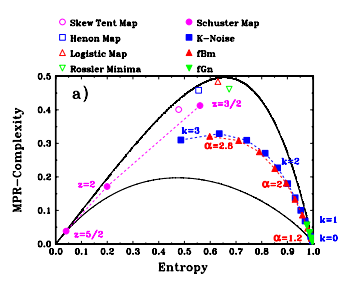

# Raw Text to time series

In [13]:
def raw_text_to_time_series(input_path, prepared_path, dictionary_path, table_path, pandas_path, lang):
    file_name = input_path.split('/')[-1]
    if lang == 'rus':
        prepare_russian_text(input_path, prepared_path)
    elif lang == 'chi':
        prepare_chi_text(input_path, prepared_path)
    else:
        prepare_english_text(input_path, prepared_path)

    table = pd.DataFrame()

    ready_arr = text_to_series(prepared_path+file_name, dictionary_path, table_path)

    print(ready_arr[:10])
    for (n, m) in [(3,5), (3,6), (3,7), (4,3),(4,4),(5,3),(6,2)]:
        table = table.append({'n':n, 'm':m, 'entropy':entropy_measure_m(ready_arr, n, m),
              'complexity':mpr_complexity_m(ready_arr, n, m), 'name': file_name, 'lang':lang}, ignore_index=True)
    if glob.glob(pandas_path):
      table.to_csv(pandas_path,index=False,mode='a',header=False)
    else:
      table.to_csv(pandas_path,index=False)
    return ready_arr

In [ ]:
#Create 3 time series matrice of normal russian text
input = '/content/drive/MyDrive/ML_Project4/input/russian_corpus_ben/115_Pinskij_1824.txt'
prepared = '/content/drive/MyDrive/ML_Project4/input/new_prep_rus_ben/'
dic = '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/russian_dictionary.txt'
sigma = '/content/drive/MyDrive/ML_Project4/input/table/ru_sigma_ben18.npy'
save = '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_ru.csv'
series_ru= raw_text_to_time_series(input,prepared,dic,sigma, save, 'ru')

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.00422598, -0.00109713, -0.00319101,
       -0.00853757,  0.00248667,  0.00048512, -0.00340805, -0.00114717,
        0.00424603, -0.00362913, -0.00698103,  0.00138333, -0.00173627,
        0.00348088, -0.0036557 ,  0.00048678]), array([-1.59071321e-04, -1.51626830e-05, -1.97181440e-04,  1.75238394e-05,
       -6.92996145e-05,  1.00058702e-05,  2.90473391e-05,  6.46081483e-05,
       -2.59773494e-05, -3.94841844e-05, -2.20583335e-05, -1.02377126e-06,
        4.20599862e-05, -1.60230745e-05,  5.33085340e-06, -3.55839624e-05,
        1.72541333e-05,  8.28485178e-06]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.0042

In [ ]:
input = '/content/drive/MyDrive/ML_Project4/input/russian_corpus_ben/1_DGlebov_1818.txt'
series_ru1= raw_text_to_time_series(input,prepared,dic,sigma, save, 'ru')

input = '/content/drive/MyDrive/ML_Project4/input/russian_corpus_ben/212_Pisarev_1820.txt'
series_ru2= raw_text_to_time_series(input,prepared,dic,sigma, save, 'ru')

[array([-3.68826993e-05, -8.33047003e-06, -2.11840319e-05,  5.07447848e-06,
       -5.18315341e-06,  3.13979157e-06, -1.03964740e-06,  7.56914924e-06,
        4.85749646e-06,  2.28869730e-05, -5.21758107e-06,  3.53600125e-06,
        9.39623109e-06, -9.15262072e-06, -1.85308440e-05, -8.78767689e-06,
       -1.28117902e-05,  4.51985870e-06]), array([-4.70640667e-05, -2.53762986e-05, -5.17356310e-05, -2.55304470e-05,
       -1.38969322e-05, -6.27778487e-06, -2.52116357e-06, -2.18956033e-05,
       -9.12251463e-06, -2.93811006e-06,  8.58746963e-06, -1.86530949e-06,
        5.47094481e-06, -5.68195543e-06,  9.64575765e-06, -5.07410778e-06,
        4.78285631e-06, -7.92309036e-06]), array([-0.00106882, -0.00025801, -0.00090708, -0.00177866,  0.00045229,
        0.00065966,  0.00014251, -0.00184363, -0.0003992 ,  0.0001691 ,
        0.00072365,  0.0001403 , -0.00052155,  0.00011074, -0.00042657,
       -0.00037963, -0.00076406, -0.00024306]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [ ]:
#Create 3 time series matrice of russian bot text
input = '/content/drive/MyDrive/ML_Project4/sub/ru_bot.txt'
prepared = '/content/drive/MyDrive/ML_Project4/input/new_prep_rus_ben/'
dic = '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/russian_dictionary.txt'
sigma = '/content/drive/MyDrive/ML_Project4/input/table/ru_sigma_ben18.npy'
save = '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_ru.csv'
series_ru_bot= raw_text_to_time_series(input,prepared,dic,sigma, save, 'ru')

[array([-5.83039827e-03, -6.45323713e-03,  1.13513453e-02, -5.93103161e-03,
        9.62140248e-03, -2.47333287e-03,  7.72277401e-03,  1.48227573e-03,
       -4.57433664e-05, -3.76257314e-03, -8.73803961e-03, -7.33030652e-03,
       -2.06566142e-02,  9.92473356e-04, -6.43595858e-03, -1.12117019e-02,
        8.64914046e-03, -1.55737519e-02]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-1.08134640e-02, -3.04963895e-04, -6.00012023e-03, -6.56953795e-03,
       -4.37786582e-03, -2.57972734e-03,  4.15960680e-05,  1.65090542e-03,
       -5.29696865e-03,  2.11547933e-03, -1.13913420e-04,  1.52422666e-03,
        4.93964965e-03, -2.13600552e-03, -7.68415192e-04, -2.59448318e-03,
        6.20871593e-03,  1.68476138e-03]), array([-5.29784428e-05, -2.85652489e-05, -5.82370661e-05, -2.87387687e-05,
       -1.56433109e-05, -7.06669206e-06, -2.83798935e-06, -2.4

In [ ]:
input = '/content/drive/MyDrive/ML_Project4/sub/ru_bot1.txt'
series_ru_bot1= raw_text_to_time_series(input,prepared,dic,sigma, save, 'ru')

input = '/content/drive/MyDrive/ML_Project4/sub/ru_bot2.txt'
series_ru_bot2= raw_text_to_time_series(input,prepared,dic,sigma, save, 'ru')

[array([-0.02705025, -0.00506015, -0.01586792, -0.01850904, -0.0024864 ,
       -0.00822338, -0.00197854, -0.00665201, -0.0073753 ,  0.00516954,
        0.00163211, -0.00034912,  0.00552601, -0.00291097, -0.00388859,
       -0.00550909, -0.0015333 , -0.00127811]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.00422598, -0.00109713, -0.00319101,
       -0.00853757,  0.00248667,  0.00048512, -0.00340805, -0.00114717,
        0.00424603, -0.00362913, -0.00698103,  0.00138333, -0.00173627,
        0.00348088, -0.0036557 ,  0.00048678]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 

In [ ]:
#Create 3 time series matrice of normal English text
series_eng = raw_text_to_time_series('/content/drive/MyDrive/ML_Project4/input/test_eng_ben/Sonnets 31-60(Poetry).txt',#/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/The Mysterious Affair at Styles(Fiction).txt
                        '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy', 
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')

series_eng1 = raw_text_to_time_series('/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/The Mysterious Affair at Styles(Fiction).txt',
                         '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy',
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')

series_eng2 = raw_text_to_time_series('/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/Summer Stillness(Poetry).txt',
                         '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy',
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.06782238,  0.05310814, -0.02858744, -0.0109557 , -0.00734296,
        0.07785295,  0.04719373, -0.00911355]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.04052645, -0.00310623, -0.00356062,  0.00924852, -0.00522382,
       -0.0209134 ,  0.01734051,  0.03892932]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

In [ ]:
#Create 3 time series matrice of English bot text
series_eng_bot = raw_text_to_time_series('/content/drive/MyDrive/ML_Project4/sub/eng_bot.txt',
                        '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy', 
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')

series_eng_bot1 = raw_text_to_time_series('/content/drive/MyDrive/ML_Project4/sub/eng_bot2.txt',
                        '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy', 
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')

series_eng_bot2 = raw_text_to_time_series('/content/drive/MyDrive/ML_Project4/sub/eng_bot1.txt',
                        '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy', 
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.67483626, -0.12423078, -0.15918416, -0.03001041, -0.14236713,
       -0.01620726,  0.06723674,  0.14669239]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

In [ ]:
input = '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/*三国演义_罗贯中_明_演义_ch.txt'
prepared = '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/'
dic = '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_chinese_dictionary.txt'
sigma = '/content/drive/MyDrive/ML_Project4/input/table/chi_sigma_ben8.npy'
save ='/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_chi.csv'
series_chi= raw_text_to_time_series(input,prepared,dic,sigma, save, 'chi')
input = '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/*Oliver_Twist_ch.txt'
series_chi1= raw_text_to_time_series(input,prepared,dic,sigma, save, 'chi')
input = '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/*老残游记_刘鹗_清_小说_ch.txt'
series_chi2= raw_text_to_time_series(input,prepared,dic,sigma, save, 'chi')

[array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-0.24715657, -0.00816322,  0.04060709,  0.03929834, -0.02428873,
        0.04313505, -0.00498113,  0.02204261]), array([-0.04549425, -0.02716786,  0.01282921,  0.00630262, -0.01238631,
       -0.00110507, -0.00129243, -0.00273832]), array([-0.30979284, -0.06220626,  0.04399292, -0.00828249, -0.02320219,
        0.00074927, -0.03193363, -0.0173497 ]), array([-0.23118251, -0.14303009,  0.08583094,  0.06799996,  0.03043201,
       -0.02857151,  0.00891372,  0.01793585]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.01896324, -0.02676165,  0.02201117,  0.01798399,  0.01853628,
       -0.00650479,  0.00047015, -0.0009577 ]), array([-0.02652268, -0.02027232,  0.005

In [ ]:
#To-do's Fake text
input = '/content/drive/MyDrive/ML_Project4/sub/chi_bot.txt'
prepared = '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/'
dic = '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_chinese_dictionary.txt'
sigma = '/content/drive/MyDrive/ML_Project4/input/table/chi_sigma_ben8.npy'
save ='/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_chi.csv'
series_chi_bot= raw_text_to_time_series(input,prepared,dic,sigma, save, 'chi')
input = '/content/drive/MyDrive/ML_Project4/sub/chi_bot1.txt'
series_chi_bot1= raw_text_to_time_series(input,prepared,dic,sigma, save, 'chi')
input = '/content/drive/MyDrive/ML_Project4/sub/chi_bot2.txt'
series_chi_bot2= raw_text_to_time_series(input,prepared,dic,sigma, save, 'chi')

[array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-0.24715657, -0.00816322,  0.04060709,  0.03929834, -0.02428873,
        0.04313505, -0.00498113,  0.02204261]), array([-0.04549425, -0.02716786,  0.01282921,  0.00630262, -0.01238631,
       -0.00110507, -0.00129243, -0.00273832]), array([-0.30979284, -0.06220626,  0.04399292, -0.00828249, -0.02320219,
        0.00074927, -0.03193363, -0.0173497 ]), array([-0.23118251, -0.14303009,  0.08583094,  0.06799996,  0.03043201,
       -0.02857151,  0.00891372,  0.01793585]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.01896324, -0.02676165,  0.02201117,  0.01798399,  0.01853628,
       -0.00650479,  0.00047015, -0.0009577 ]), array([-0.02652268, -0.02027232,  0.005

# Save Numpy of Time-Series

In [ ]:
path = '/content/drive/MyDrive/ML_Project4/input/time_series_numpy_ben/'

In [ ]:
series_chi = np.array(series_chi)
series_chi1 = np.array(series_chi1)
series_chi2 = np.array(series_chi2)

series_chi_bot = np.array(series_chi_bot)
series_chi_bot1 = np.array(series_chi_bot1)
series_chi_bot2 = np.array(series_chi_bot2)

series_eng = np.array(series_eng)
series_eng1 = np.array(series_eng1)
series_eng2 = np.array(series_eng2)

series_eng_bot = np.array(series_eng_bot)
series_eng_bot1 = np.array(series_eng_bot1)
series_eng_bot2 = np.array(series_eng_bot2)

series_ru = np.array(series_ru)
series_ru1 = np.array(series_ru1)
series_ru2 = np.array(series_ru2)

series_ru_bot = np.array(series_ru_bot)
series_ru_bot1 = np.array(series_ru_bot1)
series_ru_bot2 = np.array(series_ru_bot2)

f = path+'series_eng.npy'
np.save(f,series_eng)
f = path+'series_eng1.npy'
np.save(f,series_eng1)
f = path+'series_eng2.npy'
np.save(f,series_eng2)

f = path+'series_chi.npy'
np.save(f,series_chi)
f = path+'series_chi1.npy'
np.save(f,series_chi1)
f = path+'series_chi2.npy'
np.save(f,series_chi2)

f = path+'series_ru.npy'
np.save(f,series_ru)
f = path+'series_ru1.npy'
np.save(f,series_ru1)
f = path+'series_ru2.npy'
np.save(f,series_ru2)

f = path+'series_eng_bot.npy'
np.save(f,series_eng_bot)
f = path+'series_eng_bot1.npy'
np.save(f,series_eng_bot1)
f = path+'series_eng_bot2.npy'
np.save(f,series_eng_bot2)

f = path+'series_chi_bot.npy'
np.save(f,series_chi_bot)
f = path+'series_chi_bot1.npy'
np.save(f,series_chi_bot1)
f = path+'series_chi_bot2.npy'
np.save(f,series_chi_bot2)

f = path+'series_ru_bot.npy'
np.save(f,series_ru_bot)
f = path+'series_ru_bot1.npy'
np.save(f,series_ru_bot1)
f = path+'series_ru_bot2.npy'
np.save(f,series_ru_bot2)

# Load Numpy of Time-Series

In [21]:
path = '/content/drive/MyDrive/ML_Project4/input/time_series_numpy_ben/'

In [22]:
#Load numpy
f = path+'series_chi.npy'
series_chi  = np.load(f)
f = path+'series_chi1.npy'
series_chi1 = np.load(f,)
f = path+'series_chi2.npy'
series_chi2 = np.load(f)

f = path+'series_ru.npy'
series_ru =np.load(f)
f = path+'series_ru1.npy'
series_ru1 = np.load(f)
f = path+'series_ru2.npy'
series_ru2 =np.load(f)

f = path+'series_eng.npy'
series_eng = np.load(f)
f = path+'series_eng1.npy'
series_eng1 = np.load(f)
f = path+'series_eng2.npy'
series_eng2 = np.load(f)

f = path+'series_eng_bot.npy'
series_eng_bot = np.load(f)
f = path+'series_eng_bot1.npy'
series_eng_bot1 = np.load(f)
f = path+'series_eng_bot2.npy'
series_eng_bot2 = np.load(f)

f = path+'series_chi_bot.npy'
series_chi_bot = np.load(f)
f = path+'series_chi_bot1.npy'
series_chi_bot1 =np.load(f)
f = path+'series_chi_bot2.npy'
series_chi_bot2 =np.load(f)

f = path+'series_ru_bot.npy'
series_ru_bot = np.load(f)
f = path+'series_ru_bot1.npy'
series_ru_bot1 = np.load(f)
f = path+'series_ru_bot2.npy'
series_ru_bot2 = np.load(f)

# Bot Detection - Entropy

In [14]:
import math

def get_split_index_m(A):
    i = len(A) - 1
    while i > 0:
        if A[i] < A[i - 1]:
            i -= 1
        else:
            break
    return i - 1


def get_change_index_m(A, i):
    j = len(A) - 1
    while j >= i:
        if A[j] > A[i]:
            break
        else:
            j -= 1
    return j


def swap_m(A, i, j):
    A[i], A[j] = (A[j], A[i])


# reverse A[start:]
def reverse_m(A, start):
    left = start
    right = len(A) - 1
    while left < right:
        swap_m(A, left, right)
        left += 1
        right -= 1


def next_permutation_m(A, v):
    i = v - 1
    while i >= 0:
        split_index = get_split_index_m(A[i])
        # the Array is sorted in descreased order
        if split_index == -1:
            reverse_m(A[i], 0)
            i -= 1
        else:
            change_index = get_change_index_m(A[i], split_index)
            swap_m(A[i], split_index, change_index)
            reverse_m(A[i], split_index + 1)
            break


def factorial_m(n):
    ans = 1
    for i in range(2, n + 1):
        ans *= i
    return ans


def permutations_m(d, v):
    a = []
    for i in range(v):
        a.append([])
        for j in range(d):
            a[-1].append(j + 1)
    perm = dict()
    perm[str(a)] = 0
    for j in range(factorial_m(d) ** v - 1):
        next_permutation_m(a, v)
        perm[str(a)] = j + 1
    return perm


def s_max_m(d, v):
    return math.log(factorial_m(d) ** v)


def s_max_list_m(d, v):
    return [1 / (factorial_m(d) ** v)] * (factorial_m(d) ** v)


def p_m(arr, d, v): 
    pr = [0] * (factorial_m(d) ** v)
    permutation_dict = permutations_m(d, v)
    for i in range(d - 1, len(arr)):
        full_curr_perm = []
        for l in range(v):
            curr = []
            for j in range(i - d + 1, i + 1):
                curr.append([arr[j][l], len(curr) + 1])
            curr.sort()
            curr_perm = []
            for k in curr:
                curr_perm.append(k[1])
            full_curr_perm.append(curr_perm)
        pr[permutation_dict[str(full_curr_perm)]] += 1
    for i in range(len(pr)):
        pr[i] /= len(arr) - d + 1
    return pr


def s_m(pr):
    entropy = 0
    for i in range(len(pr)):
        if pr[i] != 0:
            entropy -= pr[i] * math.log(pr[i])
    return entropy

def q_0_calculation_m(d, v):
    pr = [0] * (factorial_m(d) ** v)
    pr[0] = 1
    b = s_max_list_m(d, v)
    b = [pr + b for pr, b in zip(pr, b)]
    b = [i * 0.5 for i in b]
    return 1 / (s_m(b) - s_m(pr) / 2 - s_max_m(d, v) / 2)

def q_j_m(arr, d, v):
    pr = p_m(arr, d, v)
    b = s_max_list_m(d, v)
    b = [pr + b for pr, b in zip(pr, b)]
    b = [i * 0.5 for i in b]
    return q_0_calculation_m(d, v) * (s_m(b) - s_m(pr) / 2 - s_max_m(d, v) / 2)

def s_b(N, p, m, n):
    if p != 0:
        return -(n * p * math.log(p) + (N - m - n) * (1 - p * n) / (N - m - n) * math.log((1 - p * n) / (N - m - n)))
    else:
        return math.log(N - m - n)

def s_b_1(N, p, m, n):
    return -(m / N * math.log(1 / N) + n * (p + 1 / N) / 2 * math.log((p + 1 / N) / 2) + (N - m - n) * ((1 - p * n) / (N - m - n) + 1 / N) / 2 * math.log((((1 - p * n) / (N - m - n)) + 1 / N) / 2))

def entropy_measure_b(N, p, m, n):
    return s_b(N, p, m, n) / math.log(N)

def q_0_calculation_b(N, p, m, n):
    return 1 / (s_b(N, 1 / 2 / N, 0, N - 1) - math.log(N) / 2)


def q_j_b(N, p, m, n):
    return q_0_calculation_b(N, p, m, n) * (s_b_1(N, p, m, n) - s_b(N, p, m, n) / 2 - math.log(N) / 2)

def mpr_complexity_b(N, p, m, n):
    return q_j_b(N, p, m, n) * entropy_measure_b(N, p, m, n)

def borders(N, x, y):
    i = 1;
    while (i * 100 < N):
        for n in range (N - i * 100, N - 1, i):
            plt.scatter(entropy_measure_b(N, 0, 0, n), mpr_complexity_b(N, 0, 0, n), c = "red")
        i *= 2
    for n in range (0, N - 1, i):
        plt.scatter(entropy_measure_b(N, 0, 0, n), mpr_complexity_b(N, 0, 0, n), c = "red")
    
    p = 0.01
    while p < 0.99:
        p += 0.01
        plt.scatter(entropy_measure_b(N, p, 0, 1), mpr_complexity_b(N, p, 0, 1), c="green")

    plt.scatter(x, y, c="blue")
    #plt.scatter(entropy_measure_b(N, 0.01, 0, 1), mpr_complexity_b(N, 0.01, 0, 1), c = "blue")
    plt.xlabel('entropy')
    plt.ylabel('mpr_complexity')
    #ax = plt.subplots()
    plt.title('n = 9')
    plt.show()

def entropy_measure_m(arr, d, v):
    return s_m(p_m(arr, d, v))/s_max_m(d, v)

def mpr_complexity_m(arr, d, v):
    return q_j_m(arr, d, v) * entropy_measure_m(arr, d, v)

In [15]:
def bot_check(series):
  series = np.array(series)
  print(f'The shape of series {series.shape}')
  borders(331776, entropy_measure_m(series[:,:4],4, 4), mpr_complexity_m(series[:,:4],4, 4))
  print(f'Entropy Measure: { entropy_measure_m(series[:,:4],4, 4)}')
  print(f'MPR Complexity Measure {mpr_complexity_m(series[:,:4],4, 4)}')

## Normal English Text

In [ ]:
series_eng =np.array(series_eng)
series_eng1 = np.array(series_eng1)
series_eng2 = np.array(series_eng2)
series_eng.shape,series_eng1.shape,series_eng2.shape

((2710, 8), (41258, 8), (51, 8))

The shape of series (2710, 8)


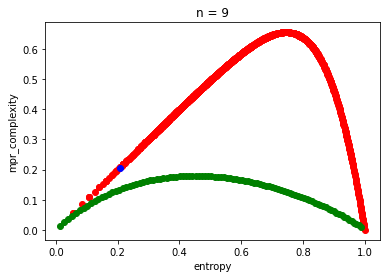

Entropy Measure: 0.20684067437399617
MPR Complexity Measure 0.20618980127435738


In [ ]:
bot_check(series_eng)

The shape of series (41258, 8)


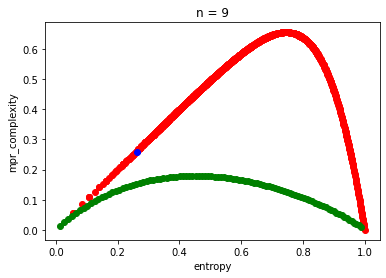

Entropy Measure: 0.2622612211233616
MPR Complexity Measure 0.25872551926892434


In [ ]:
bot_check(series_eng1) 

The shape of series (51, 8)


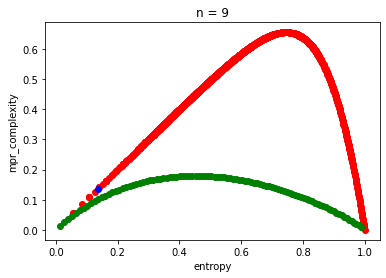

Entropy Measure: 0.1371300913673547
MPR Complexity Measure 0.1370880192331305


In [ ]:
bot_check(series_eng2)

## English Bot Text

In [ ]:
series_eng_bot =np.array(series_eng_bot)
series_eng_bot1 = np.array(series_eng_bot1)
series_eng_bot2 = np.array(series_eng_bot2)
series_eng_bot.shape,series_eng_bot1.shape,series_eng_bot2.shape

((2087, 8), (1808, 8), (2036, 8))

The shape of series (2087, 8)


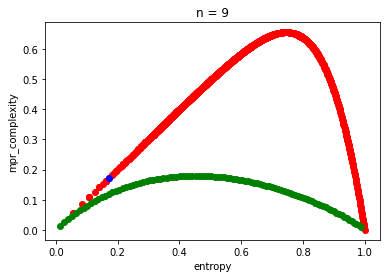

Entropy Measure: 0.17237305522333232
MPR Complexity Measure 0.1720979493089503


In [ ]:
bot_check(series_eng_bot)

The shape of series (2036, 8)


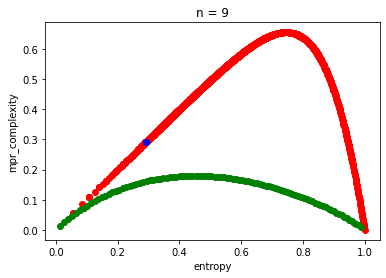

Entropy Measure: 0.2916118415931757
MPR Complexity Measure 0.29063656639059676


In [ ]:
bot_check(series_eng_bot1)

The shape of series (2036, 8)


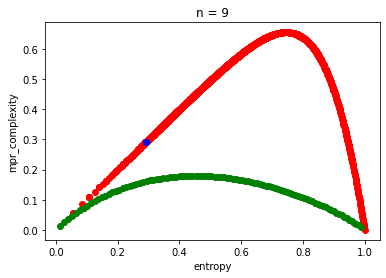

Entropy Measure: 0.2916118415931757
MPR Complexity Measure 0.29063656639059676


In [ ]:
bot_check(series_eng_bot2)

## Normal Chinese Text

In [ ]:
series_chi=np.array(series_chi)
series_chi1_ = np.array(series_chi1)
series_chi2 = np.array(series_chi2)
series_chi.shape,series_chi1.shape,series_chi2.shape

((4131, 8), (4131, 8), (4131, 8))

The shape of series (4131, 8)


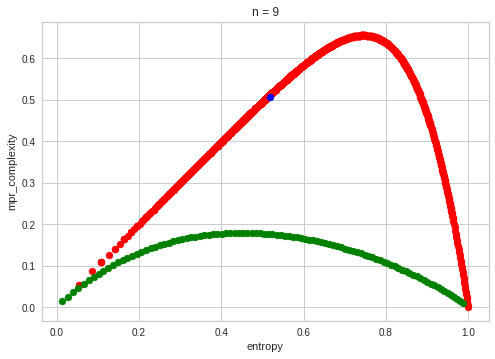

Entropy Measure: 0.5188504843124849
MPR Complexity Measure 0.5069870180500268


In [ ]:
bot_check(series_chi) 

The shape of series (4131, 8)


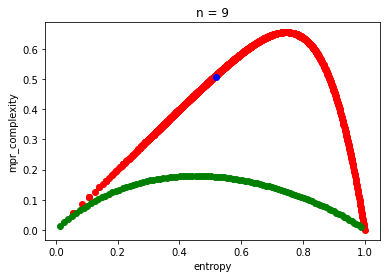

Entropy Measure: 0.5188504843124849
MPR Complexity Measure 0.5069870180500268


In [ ]:
bot_check(series_chi1)

The shape of series (4131, 8)


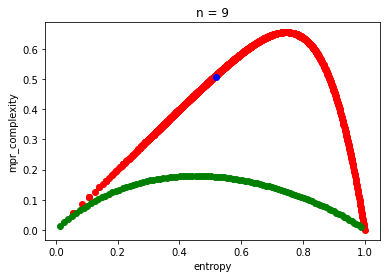

Entropy Measure: 0.5188504843124849
MPR Complexity Measure 0.5069870180500268


In [ ]:
bot_check(series_chi2)

## Bot Chinese Text 

In [ ]:
series_chi_bot =np.array(series_chi_bot)
series_chi_bot1 = np.array(series_chi_bot1)
series_chi_bot2 = np.array(series_chi_bot2)
series_chi_bot.shape,series_chi_bot1.shape,series_chi_bot2.shape

((4131, 8), (4131, 8), (4131, 8))

The shape of series (47765, 8)


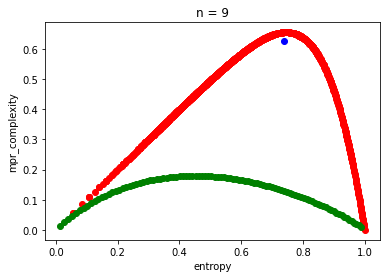

Entropy Measure: 0.7388320316556493
MPR Complexity Measure 0.6277383428719091


In [ ]:
bot_check(series_chi_bot)

The shape of series (4131, 8)


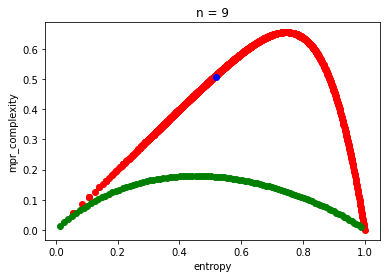

Entropy Measure: 0.5188504843124849
MPR Complexity Measure 0.5069870180500268


In [ ]:
bot_check(series_chi_bot1)

The shape of series (4131, 8)


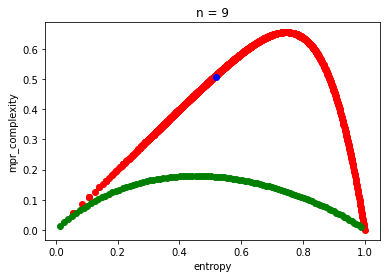

Entropy Measure: 0.5188504843124849
MPR Complexity Measure 0.5069870180500268


In [ ]:
bot_check(series_chi_bot2)

## Normal Russian Text

In [ ]:
series_ru =np.array(series_ru)
series_ru1 = np.array(series_ru1)
series_ru2 = np.array(series_ru2)
series_ru.shape,series_ru1.shape,series_ru2.shape

((101, 18), (956, 18), (956, 18))

The shape of series (101, 18)


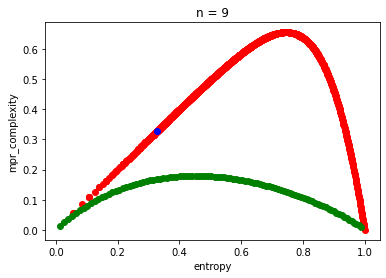

Entropy Measure: 0.3273374966789785
MPR Complexity Measure 0.3268573854272381


In [ ]:
bot_check(series_ru)

The shape of series (956, 18)


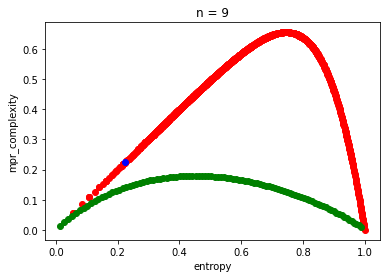

Entropy Measure: 0.22421249562659876
MPR Complexity Measure 0.22408162636190118


In [ ]:
bot_check(series_ru1)

The shape of series (956, 18)


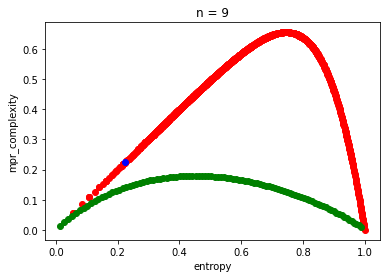

Entropy Measure: 0.22421249562659876
MPR Complexity Measure 0.22408162636190118


In [ ]:
bot_check(series_ru2)

## Russian Bot Text

In [ ]:
series_ru_bot =np.array(series_ru_bot)
series_ru_bot1 = np.array(series_ru_bot1)
series_ru_bot2 = np.array(series_ru_bot2)
series_ru_bot.shape,series_ru_bot1.shape,series_ru_bot2.shape

((579, 18), (579, 18), (579, 18))

The shape of series (413, 18)


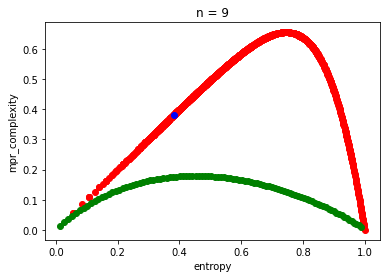

Entropy Measure: 0.38387038970539455
MPR Complexity Measure 0.3826058506664877


In [ ]:
bot_check(series_ru_bot) 

The shape of series (620, 18)


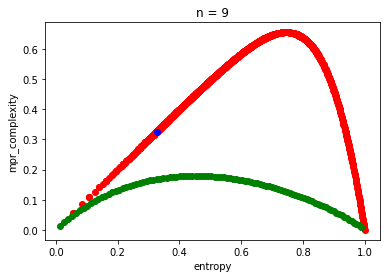

Entropy Measure: 0.32653926968405383
MPR Complexity Measure 0.3259731026799792


In [127]:
bot_check(series_ru_bot1) 

The shape of series (579, 18)


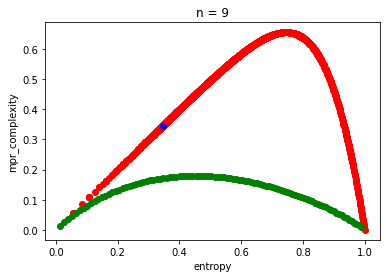

Entropy Measure: 0.34667051819699174
MPR Complexity Measure 0.34579193054448115


In [ ]:
bot_check(series_ru_bot2) 

In [ ]:
ru_entropy = pd.read_csv('/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_ru.csv')
ru_entropy

,complexity,entropy,lang,m,n,name
0,0.374050,0.383547,ru,5.0,3.0,115_Pinskij_1824.txt
1,0.409454,0.423659,ru,5.0,3.0,1_DGlebov_1818.txt
2,0.417878,0.433214,ru,5.0,3.0,212_Pisarev_1820.txt
3,0.462079,0.490475,ru,5.0,3.0,ru_bot.txt
4,0.389930,0.402717,ru,5.0,3.0,ru_bot1.txt
5,0.290264,0.293858,ru,5.0,3.0,ru_bot2.txt


In [ ]:
eng_entropy = pd.read_csv('/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv')
eng_entropy

,complexity,entropy,lang,m,n,name
0,0.223842,0.233328,eng,5.0,3.0,Sonnets 31-60(Poetry).txt
1,0.153586,0.154585,eng,5.0,3.0,Summer Stillness(Poetry).txt
2,0.263468,0.288652,eng,5.0,3.0,The Mysterious Affair at Styles(Fiction).txt
3,0.231451,0.242856,eng,5.0,3.0,eng_bot.txt
4,0.299573,0.309960,eng,5.0,3.0,eng_bot1.txt
5,0.177086,0.180155,eng,5.0,3.0,eng_bot2.txt


In [ ]:
chi_entropy = pd.read_csv('/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_chi.csv')
chi_entropy

,Unnamed: 0,complexity,entropy,lang,m,n,name
0,0,0.475344,0.582792,chi,5.0,3.0,*Oliver_Twist_ch.txt
1,1,0.385961,0.806052,chi,5.0,3.0,*三国演义_罗贯中_明_演义_ch.txt
2,2,0.383237,0.800521,chi,5.0,3.0,*水浒传_施耐庵_明_小说_ch.txt
3,3,0.407438,0.820432,chi,5.0,3.0,chi_bot.txt
4,4,0.475344,0.582792,chi,5.0,3.0,chi_bot1.txt
5,5,0.475344,0.582792,chi,5.0,3.0,chi_bot2.txt


## Summary

The results of entropy complexity part is not ideal enough. This may be because we did not use the same amount of corpus for making dictionary and word vectors.

# Bot Detection - Clustering

Reference: https://github.com/dougfoo/machineLearning/blob/master/covid/COVID-global-clustering.ipynb<br>
Approach:<br>
1.Apply PCA to reduce the dimensions of time-series data<br>
2.Kmeans clustering<br>3.Feature Engineering <br>4.Classification model training and prediction  <br>5.Model explanation<br>
Metrics:<br>
F1-score


## Normal English Text

[Text(0.5, 1.0, 'PCA')]

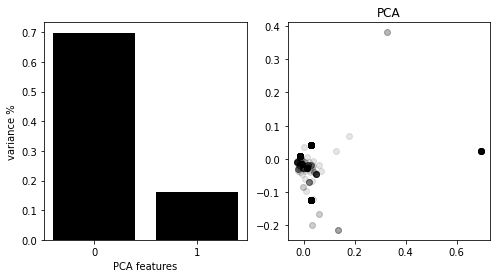

In [131]:
# Source: https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters

plotX = series_eng.copy()

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(plotX)
PCA_components = pd.DataFrame(principalComponents)

# Plot the explained variances
features = range(pca.n_components_)

fig,ax = plt.subplots(1,2, figsize=(8,4))

ax[0].bar(features, pca.explained_variance_ratio_, color='black')
ax[0].set(xlabel = 'PCA features')
ax[0].set(ylabel = 'variance %')
ax[0].set(xticks = features)

ax[1].scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')

ax[1].set(title='PCA')

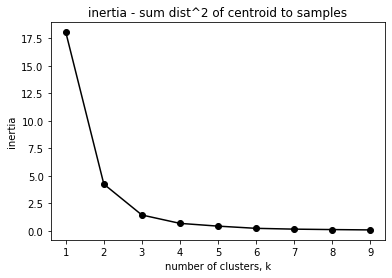

In [24]:
# KMeans on PCA columns - the elbow check !
def elbow_check(df_km):
    ks = range(1, 10)
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(df_km.iloc[:,:3])
        inertias.append(model.inertia_)

    plt.plot(ks, inertias, '-o', color='black')
    plt.title('inertia - sum dist^2 of centroid to samples')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()
    
elbow_check(PCA_components)

In [25]:
def plot_clusters(cluster_name, cluster_cases, df_comp, dims=2):
    fig,ax = plt.subplots(1,len(cluster_cases), figsize=(16,4))

    for c,clusters in enumerate(cluster_cases):
        model = KMeans(n_clusters=clusters)
        df_comp2 = df_comp.copy()
#        m = model.fit(df_comp2.iloc[:,:dims])
        m = model.fit(df_comp2)
        df_comp2.insert(0, 'cluster', m.labels_)

        datas = []
        for i in range(clusters): 
            tup = []
            for j in range(dims):  ## should be cluster dims? pca dims?
                tup.append(df_comp2[df_comp2['cluster']==i][j])
            datas.append(tup)

        groups = [cluster_name+str(i) for i in range(clusters)]
        colors = ('green','red','blue','yellow','purple','brown')

        for data,color,group in zip(datas,colors,groups):
            x,y = data[0],data[1]
            ax[c].scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=100, label=group)
            ax[c].set_title(f'{cluster_name} Kmeans {clusters} clusters')
            ax[c].set(xlabel=cluster_name+'1')
            ax[c].set(ylabel=cluster_name+'2')
    plt.show()

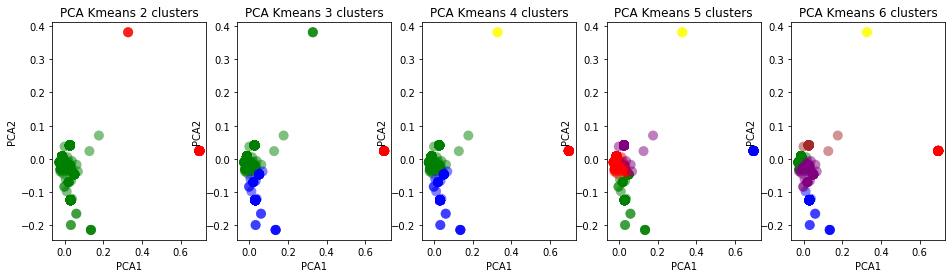

In [26]:
cluster_cases = [2,3,4,5,6]

plot_clusters('PCA', cluster_cases, PCA_components)

By elbow method and the visualization above, we choose 3 for the number of clusters.

In [27]:
def plot_big(clustering_name, reducer_name, model, df_comp,title, dims=2):
    df_comp2 = df_comp.copy()
    fig,ax = plt.subplots(figsize=(16,12))

    m = model.fit(df_comp2)  # first 3 cols, or dims
    df_comp2.insert(0, 'cluster', m.labels_)
    
    datas = []
    for i in range(len(set(m.labels_))):
        tup = []
        for j in range(dims):
            tup.append(df_comp2[df_comp2['cluster']==i][j])
        datas.append(tup)
    groups = [clustering_name+str(i) for i in range(len(set(m.labels_)))]
    colors = ('green','red','yellow','cyan','purple','brown')

    for data,color,group in zip(datas,colors,groups):
        x,y = data[0],data[1]
        ax.scatter(x, y, alpha=0.5, c=color, edgecolors='none', s=500, label=group)
        ax.set_title(title+f': {reducer_name}+{clustering_name} {len(set(m.labels_))} clusters' )
        ax.set(xlabel=f'{reducer_name}1')
        ax.set(ylabel=f'{reducer_name}2')
    plt.legend(loc=1)
    plt.show()
    return df_comp2

In [30]:
def PCA_KMeans(X,title):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(X)
  PCA_components = pd.DataFrame(principalComponents)
  clusters=3
  model = KMeans(n_clusters=clusters)
  res = plot_big('KMeans','PCA',model, PCA_components, title)
  return res

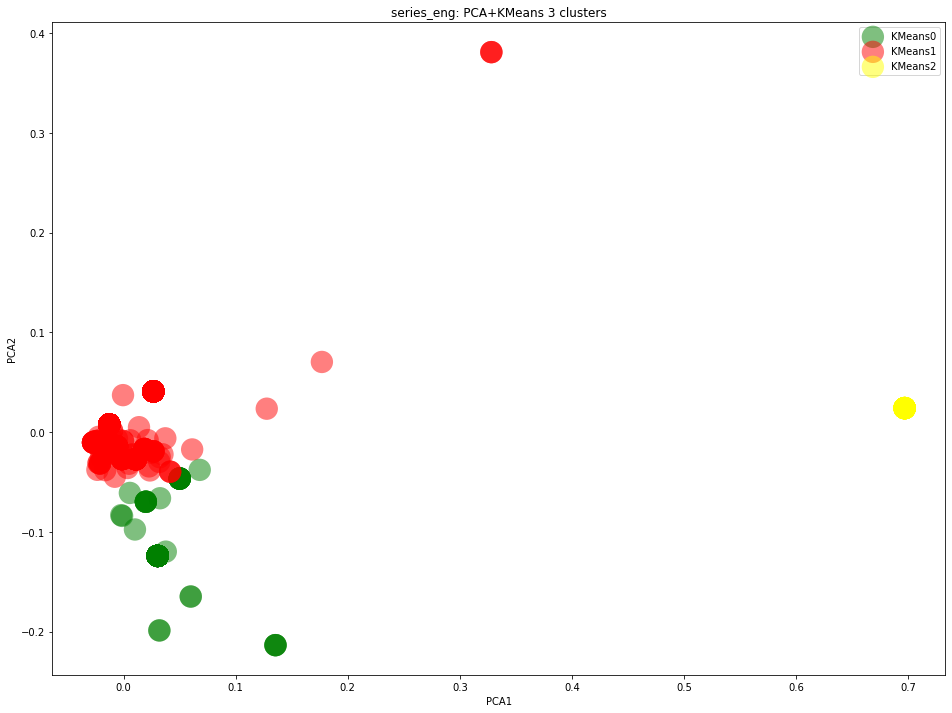

In [ ]:
# zoom on n cluster solution
clusters=3
model = KMeans(n_clusters=clusters)
series_eng_cluster = plot_big('KMeans','PCA',model, PCA_components,title='series_eng')

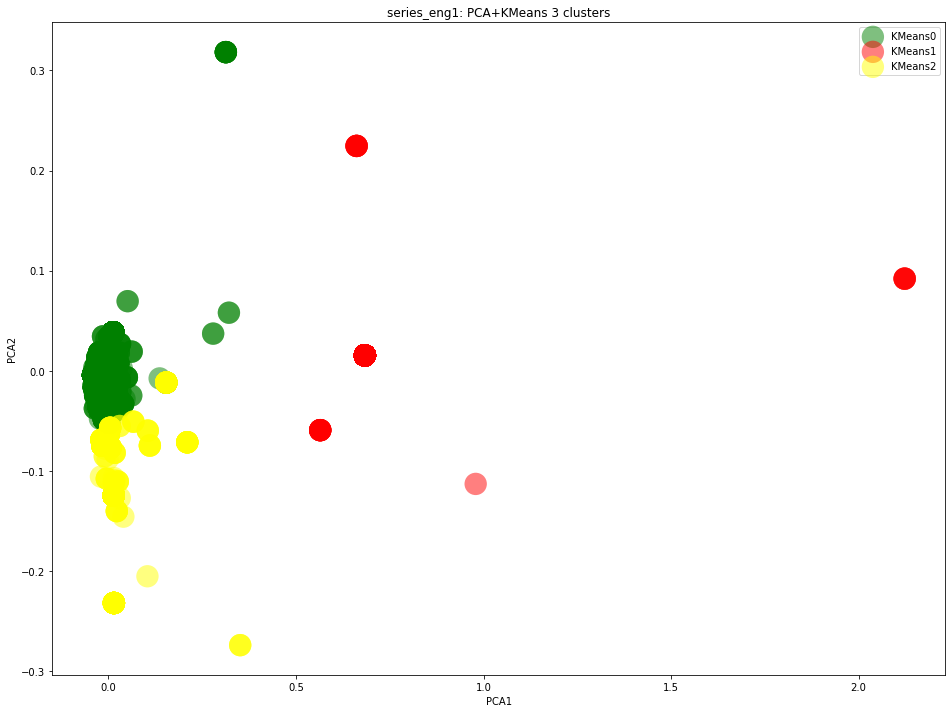

In [ ]:
series_eng1_cluster = PCA_KMeans(series_eng1,'series_eng1')

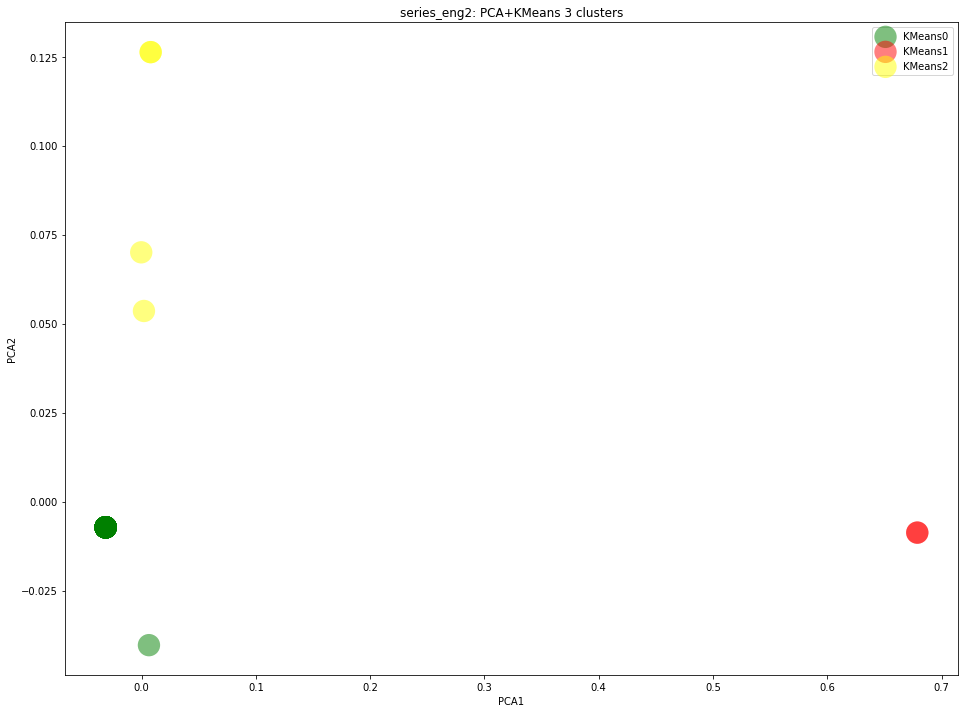

In [ ]:
series_eng2_cluster = PCA_KMeans(series_eng2,'series_eng2')

## English bot text

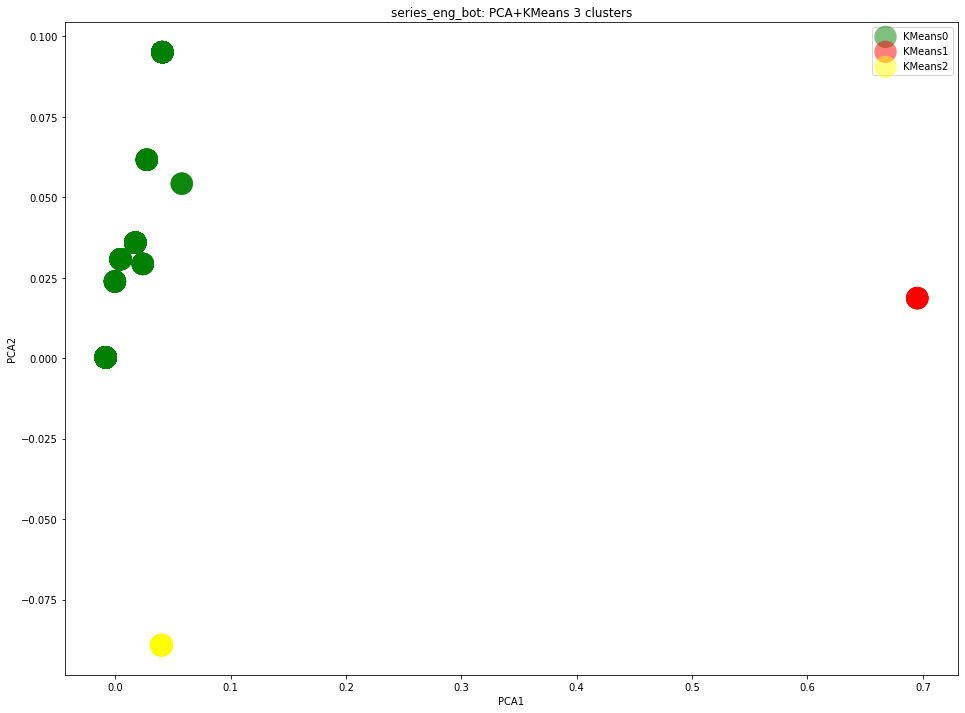

In [ ]:
series_eng_bot_cluster = PCA_KMeans(series_eng_bot,'series_eng_bot')

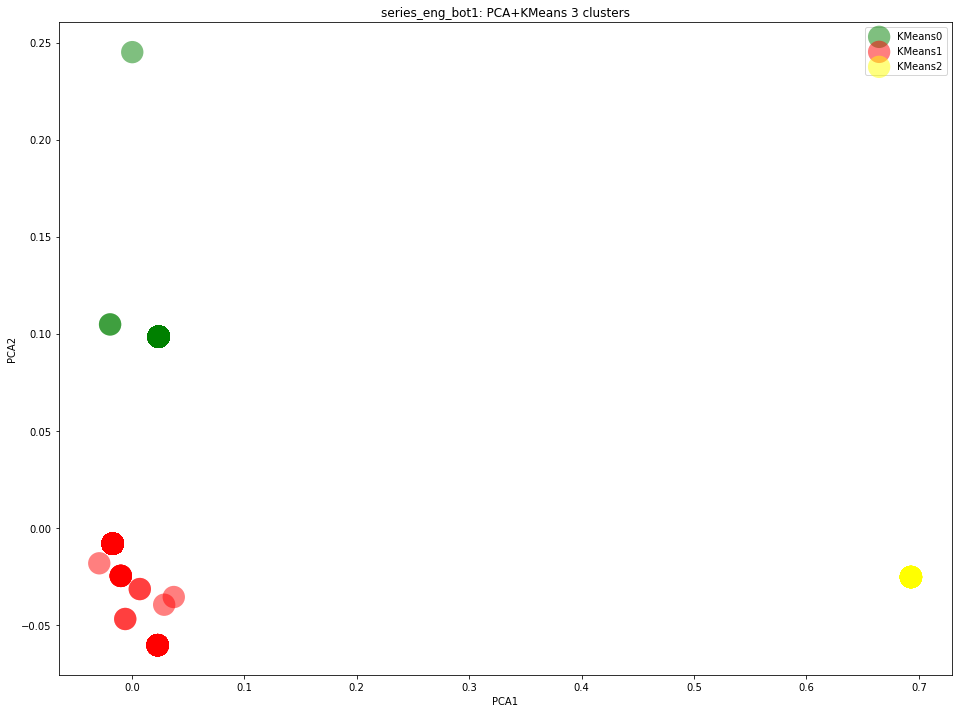

In [ ]:
series_eng_bot1_cluster = PCA_KMeans(series_eng_bot1,'series_eng_bot1')

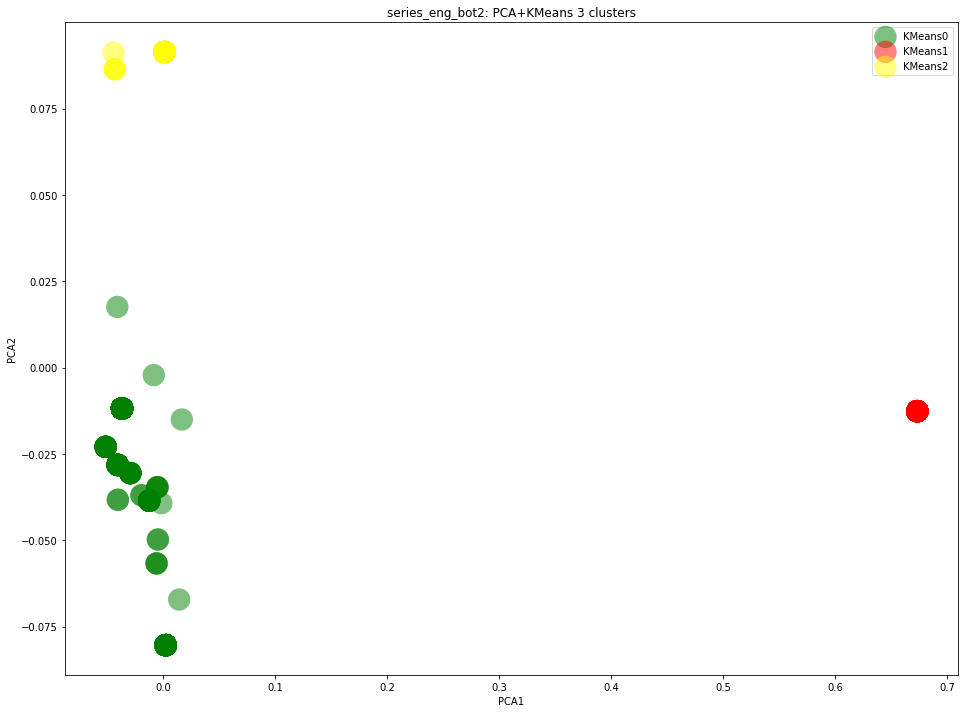

In [ ]:
series_eng_bot2_cluster = PCA_KMeans(series_eng_bot2,'series_eng_bot2')

## Normal Chinese Text

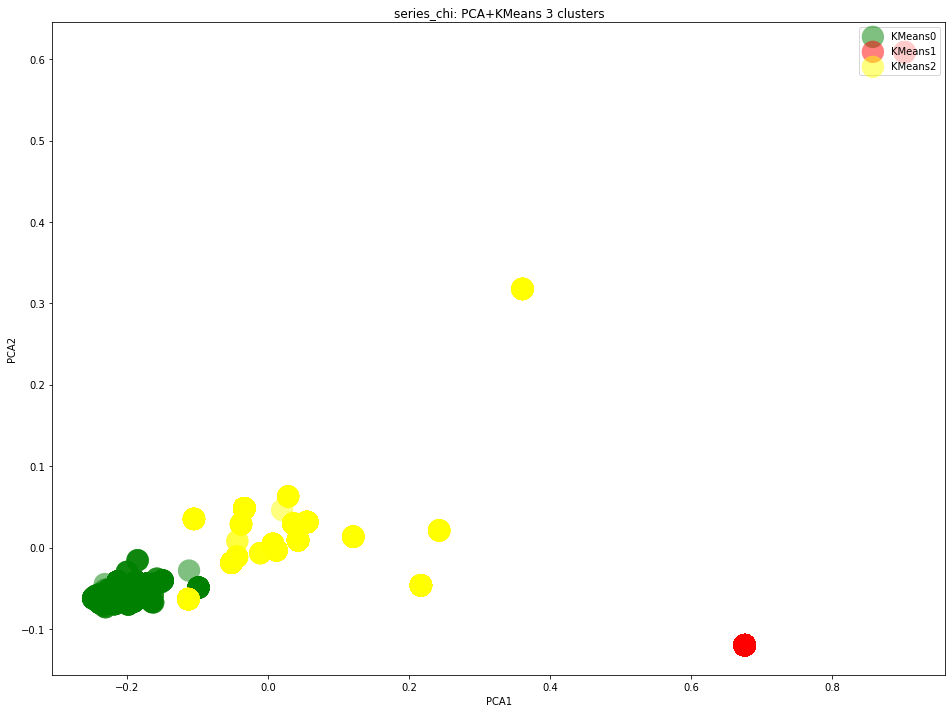

In [ ]:
series_chi_cluster = PCA_KMeans(series_chi,'series_chi')

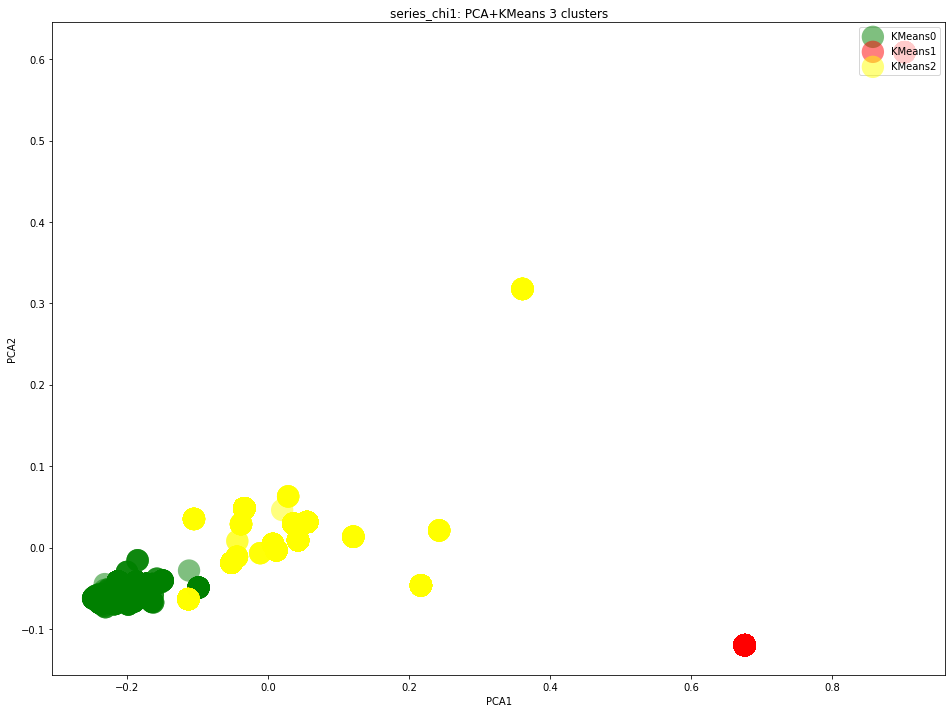

In [ ]:
series_chi1_cluster =PCA_KMeans(series_chi1,'series_chi1')

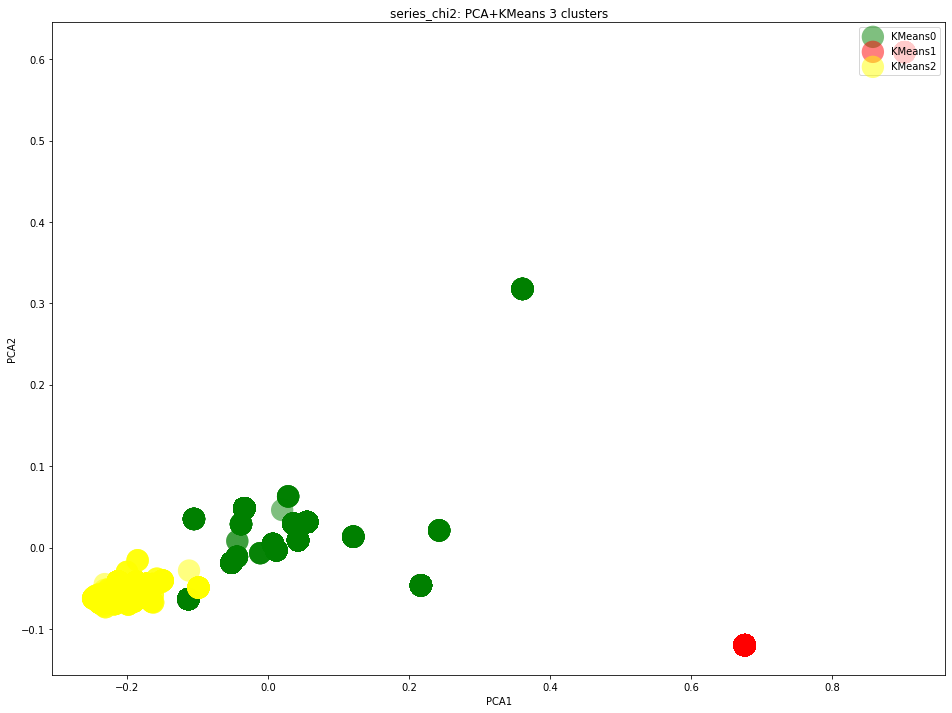

In [ ]:
series_chi2_cluster =PCA_KMeans(series_chi2,'series_chi2')

## Chinese Bot Text

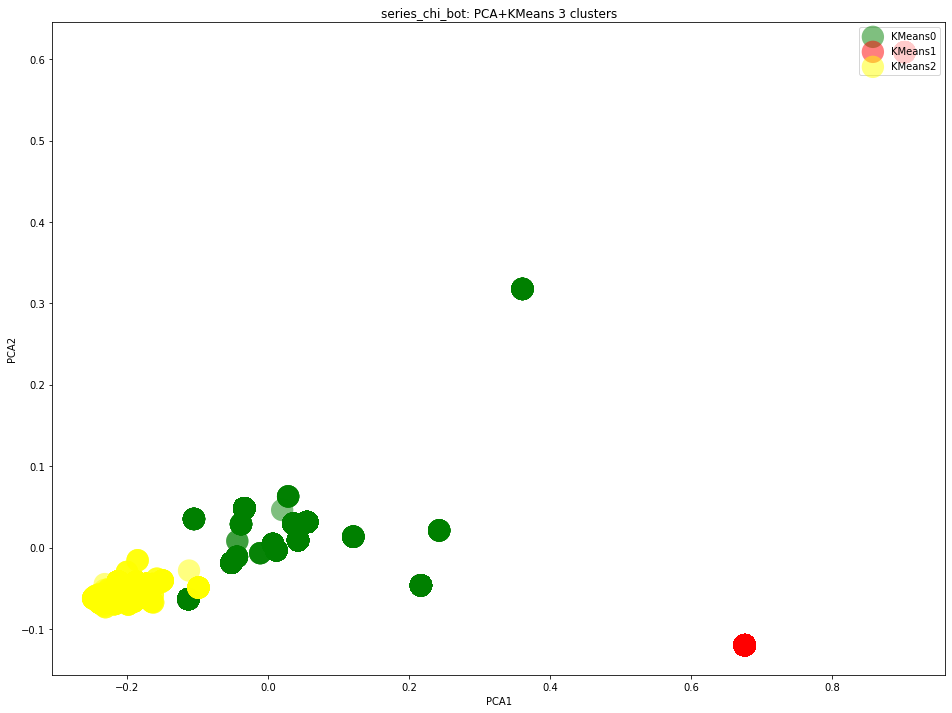

In [ ]:
series_chi_bot_cluster = PCA_KMeans(series_chi_bot,'series_chi_bot')

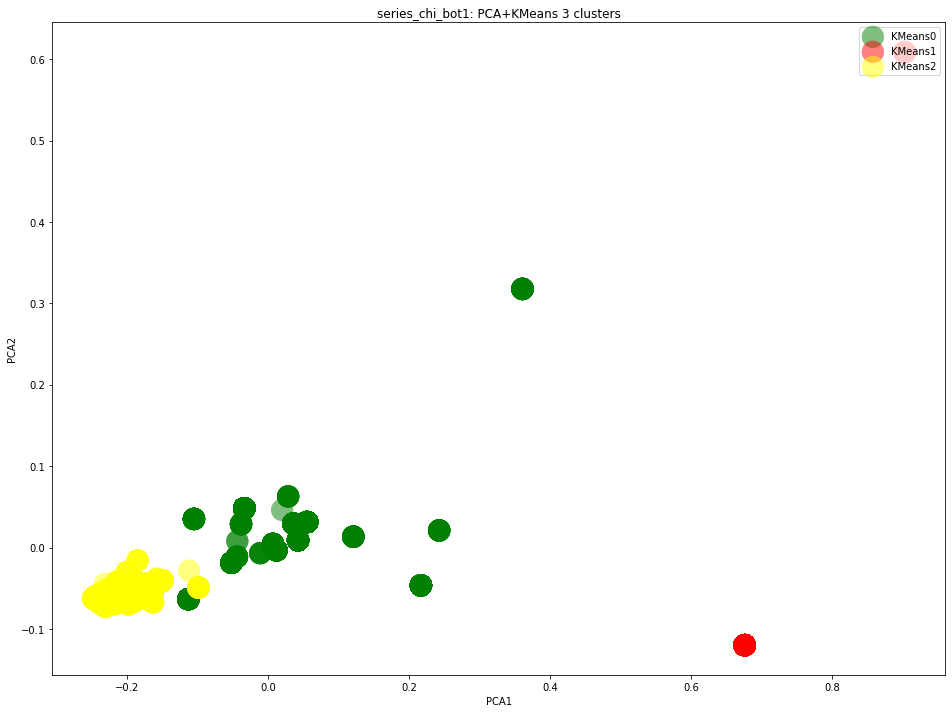

In [ ]:
series_chi_bot1_cluster = PCA_KMeans(series_chi_bot1,'series_chi_bot1')

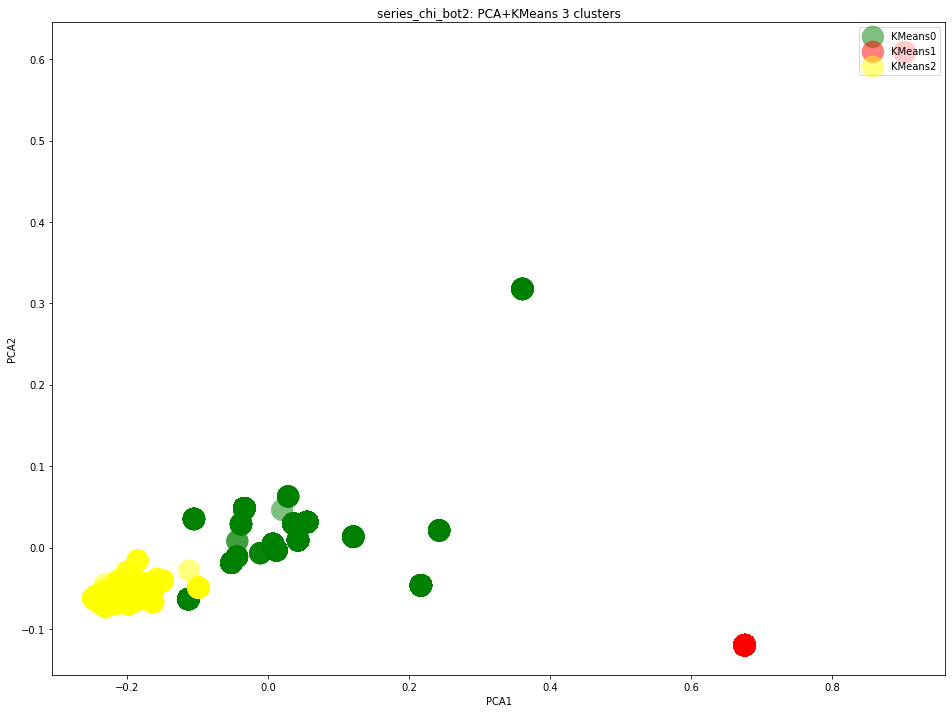

In [ ]:
series_chi_bot2_cluster = PCA_KMeans(series_chi_bot2,'series_chi_bot2')

## Normal Russian Text

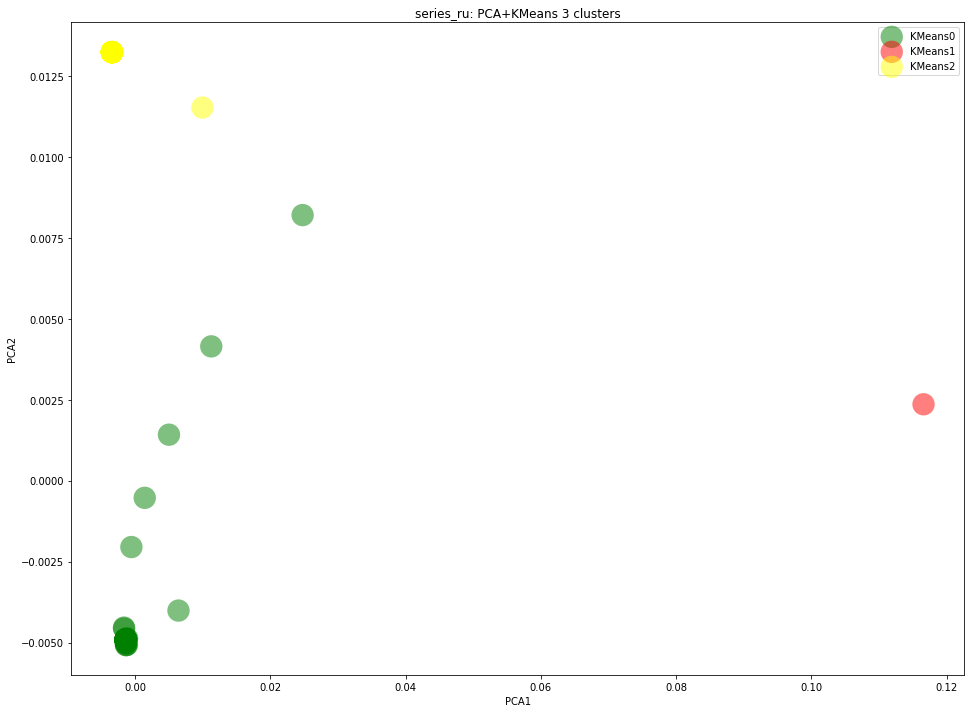

In [ ]:
series_ru_cluster = PCA_KMeans(series_ru,'series_ru')

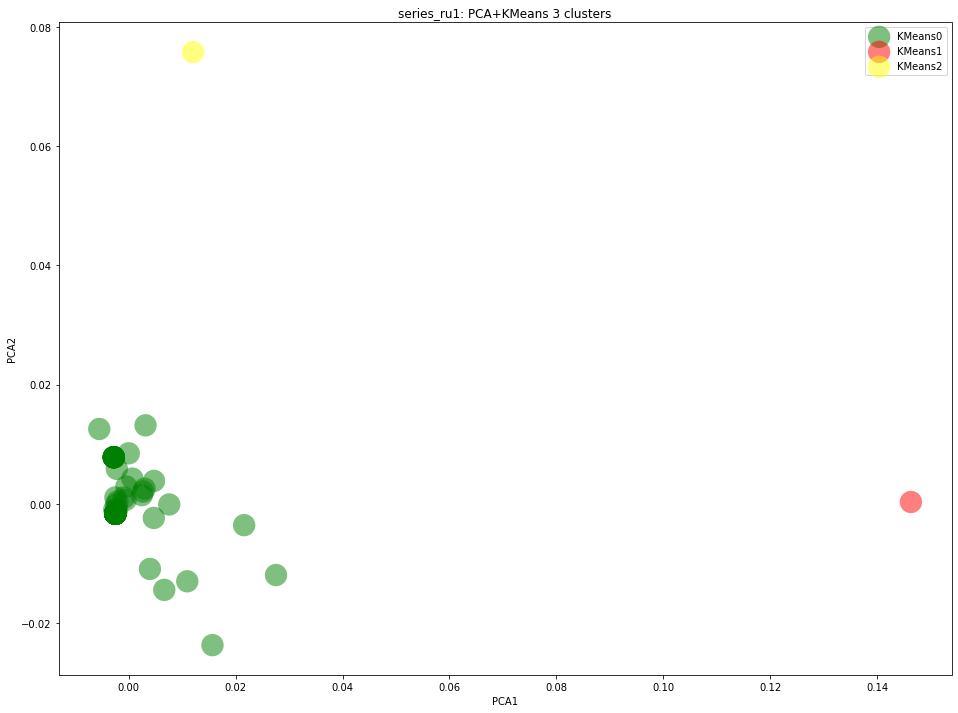

In [ ]:
series_ru1_cluster = PCA_KMeans(series_ru1,'series_ru1')

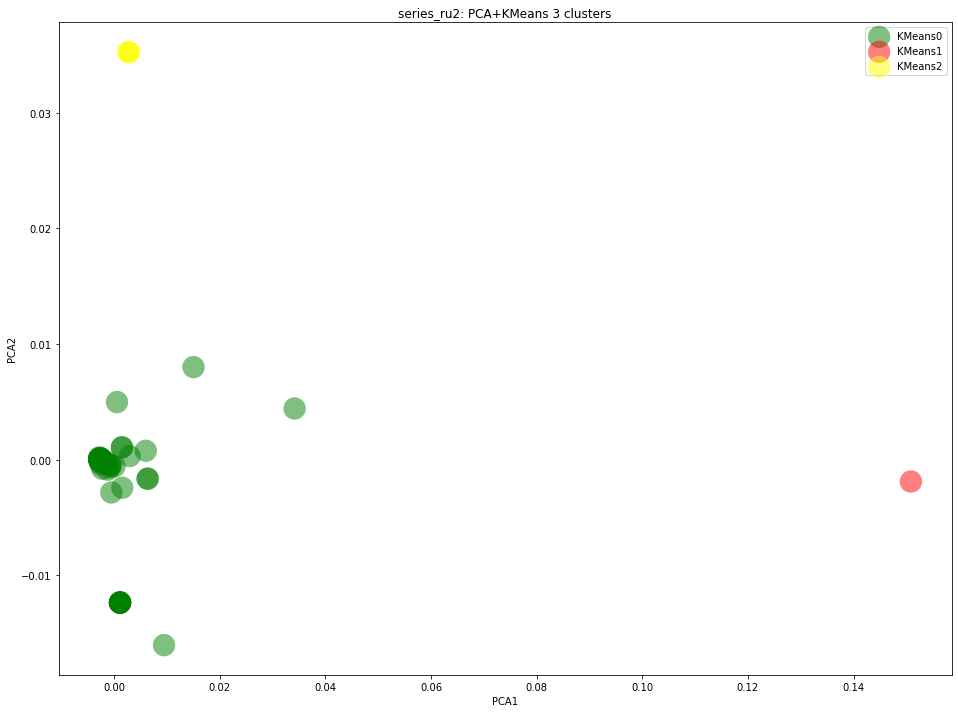

In [ ]:
series_ru2_cluster = PCA_KMeans(series_ru2,'series_ru2')

## Russian Bot Text

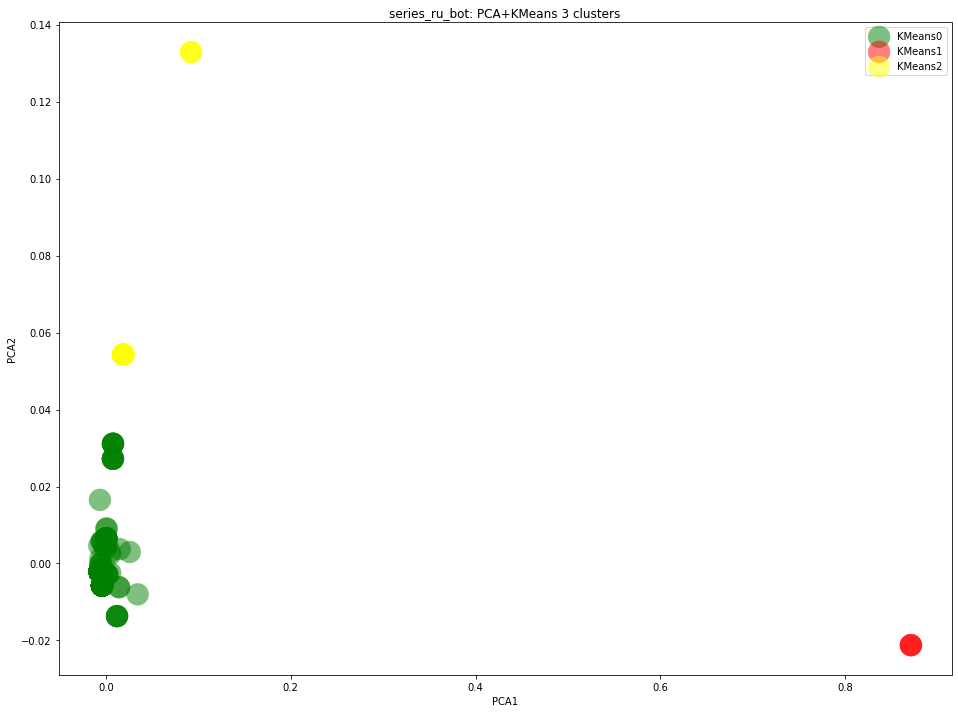

In [ ]:
series_ru_bot_cluster = PCA_KMeans(series_ru_bot,'series_ru_bot')


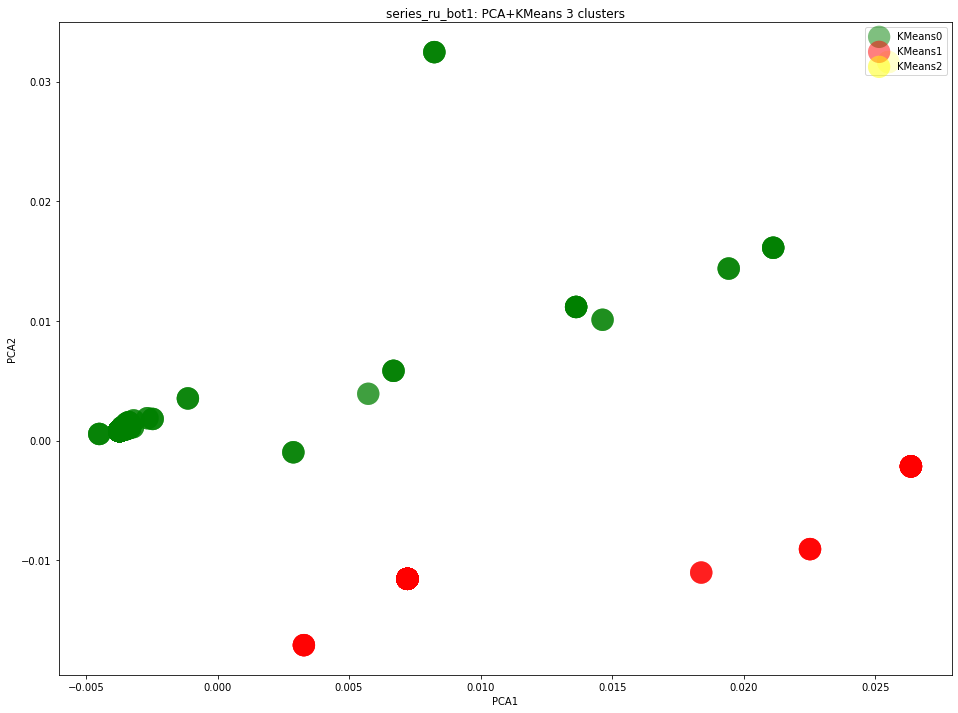

In [ ]:
series_ru_bot1_cluster = PCA_KMeans(series_ru_bot1,'series_ru_bot1') #abnormal


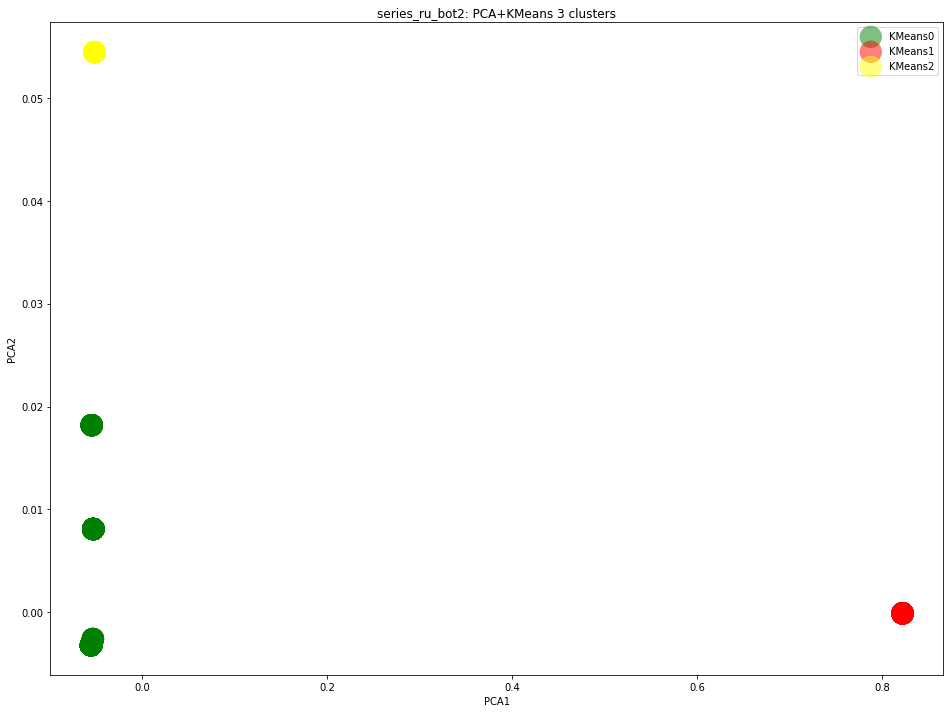

In [ ]:
series_ru_bot2_cluster = PCA_KMeans(series_ru_bot2,'series_ru_bot2')

According to the graphs,if the shape of clustering tends to more vertical line with distant dots, such as two groups out of three clusters can be seperated by a vertical line,the more likely the text is generated by bot after applying the KMeans-clusteing and PCA to the time-series of raw normal text and bot text. <br>
Next, we define metrics and use supervised classification model to detect which text is from bot.

## Feature Engineering

1.Label the clustered data with 0 for normal, 1 for bot generated.<br>
2.Encode the language column into number.<br>
3.Use Classfication models to predict whether the cluster of the language belongs to a bot or not.<br>
Metrics: F1-Score

In [31]:
ru_files = glob.glob('/content/drive/MyDrive/ML_Project4/input/RuLit/10/*')
eng_files = glob.glob('/content/drive/MyDrive/ML_Project4/input/EnLit/Charles Darwin/*')
chi_files = glob.glob('/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/*')#

In [33]:
def series_to_cluster(files,lang,limit = 5,is_bot=0):
  if limit > len(files): #Shorten the running time
    limit = len(files)
  df = pd.DataFrame()
  if lang == 'eng':
    for f in tqdm(files[:limit]):
      series = raw_text_to_time_series(f,
                        '/content/drive/MyDrive/ML_Project4/input/new_prep_eng_ben1/',
                        '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_english_dictionary_ben.txt',
                        '/content/drive/MyDrive/ML_Project4/input/table/en_sigma_v8.npy', 
                        '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_eng.csv', 'eng')
      series = np.array(series)
      cluster = PCA_KMeans(series,title='Normal English Text')
      df = df.append(cluster)
  elif lang == 'chi':
    prepared = '/content/drive/MyDrive/ML_Project4/input/new_prep_chi_ben/'
    dic = '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/new_chinese_dictionary.txt'
    sigma = '/content/drive/MyDrive/ML_Project4/input/table/chi_sigma_ben8.npy'
    save ='/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_chi.csv'
    for f in tqdm(files[:limit]):
        series= raw_text_to_time_series(f,prepared,dic,sigma, save, 'chi')
        series = np.array(series)        
        cluster = PCA_KMeans(series,title='Normal Chinese Text')
        df = df.append(cluster)  
  else:
    prepared = '/content/drive/MyDrive/ML_Project4/input/new_prep_rus_ben/'
    dic = '/content/drive/MyDrive/ML_Project4/input/dictionaries_ben/russian_dictionary.txt'
    sigma = '/content/drive/MyDrive/ML_Project4/input/table/ru_sigma_ben18.npy'
    save = '/content/drive/MyDrive/ML_Project4/input/ideal_table/ideal_table_ru.csv'
    for f in tqdm(files[:limit]):
        series = raw_text_to_time_series(f,prepared,dic,sigma, save, 'ru')
        series = np.array(series)
        cluster = PCA_KMeans(series,title='Normal Russian Text')
        display(cluster[:10])
        df = df.append(cluster)
  df['lang'] = lang
  df['is_bot'] = 0
  if is_bot ==1:
    df['is_bot'] = 1
  df.columns = ['cluster', '0', '1', 'lang', 'is_bot']
  return df 

  0%|          | 0/3 [00:00<?, ?it/s]

[array([-0.02705025, -0.00506015, -0.01586792, -0.01850904, -0.0024864 ,
       -0.00822338, -0.00197854, -0.00665201, -0.0073753 ,  0.00516954,
        0.00163211, -0.00034912,  0.00552601, -0.00291097, -0.00388859,
       -0.00550909, -0.0015333 , -0.00127811]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.00422598, -0.00109713, -0.00319101,
       -0.00853757,  0.00248667,  0.00048512, -0.00340805, -0.00114717,
        0.00424603, -0.00362913, -0.00698103,  0.00138333, -0.00173627,
        0.00348088, -0.0036557 ,  0.00048678]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 

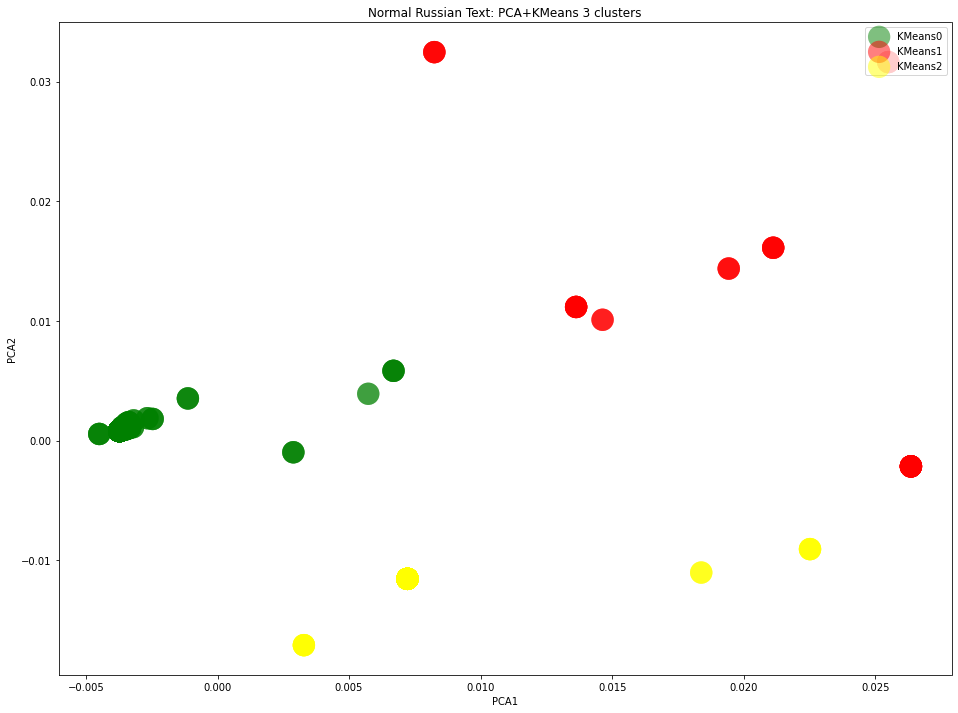

,cluster,0,1
0,1,0.021121,0.016126
1,0,-0.003735,0.000801
2,0,-0.003735,0.000801
3,0,-0.003735,0.000801
4,2,0.007218,-0.011548
5,0,-0.003735,0.000801
6,0,-0.003735,0.000801
7,0,-0.003735,0.000801
8,0,-0.003694,0.000831
9,0,-0.003735,0.000801


 33%|███▎      | 1/3 [00:46<01:33, 46.94s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.62809956, -0.10658987, -0.19399989, -0.04957799,  0.03002634,
        0.10645987,  0.11868649, -0.09429511, -0.20740577,  0.26219961,
       -0.04711578, -0.1279083 ,  0.17618214, -0.062096  , -0.33417292,
        0.0562477 , -0.09577981, -0.01653847]), array([0., 0., 0., 0., 0., 0., 

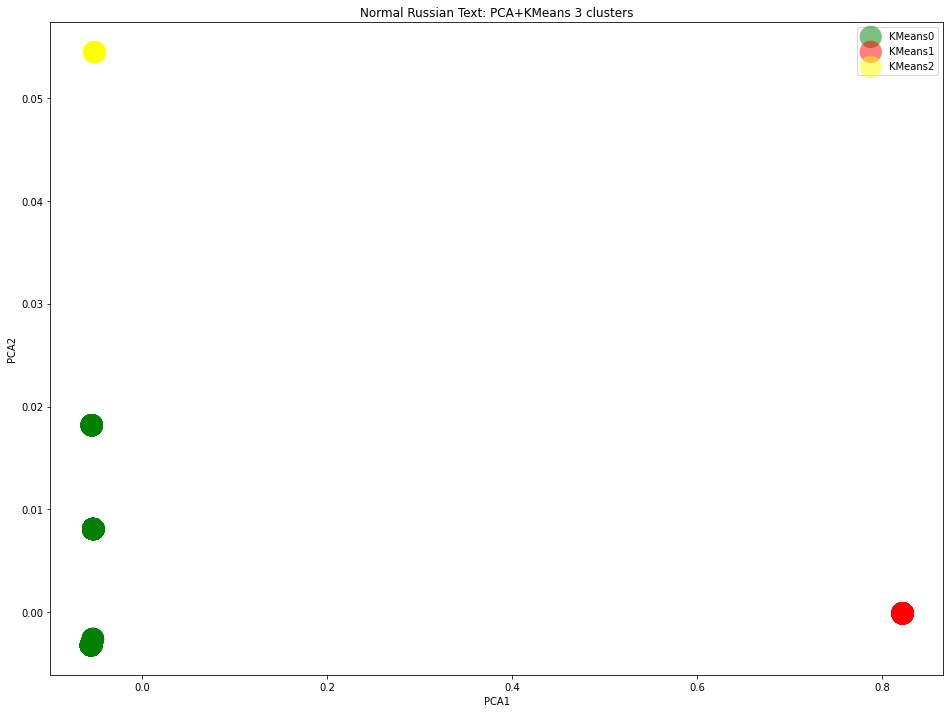

,cluster,0,1
0,0,-0.055599,-0.003201
1,0,-0.055599,-0.003201
2,0,-0.055599,-0.003201
3,0,-0.055599,-0.003201
4,0,-0.055599,-0.003201
5,0,-0.055599,-0.003201
6,0,-0.055599,-0.003201
7,0,-0.055599,-0.003201
8,1,0.822291,-0.000113
9,0,-0.055599,-0.003201


 67%|██████▋   | 2/3 [01:31<00:46, 46.21s/it]

[array([-5.83039827e-03, -6.45323713e-03,  1.13513453e-02, -5.93103161e-03,
        9.62140248e-03, -2.47333287e-03,  7.72277401e-03,  1.48227573e-03,
       -4.57433664e-05, -3.76257314e-03, -8.73803961e-03, -7.33030652e-03,
       -2.06566142e-02,  9.92473356e-04, -6.43595858e-03, -1.12117019e-02,
        8.64914046e-03, -1.55737519e-02]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-1.08134640e-02, -3.04963895e-04, -6.00012023e-03, -6.56953795e-03,
       -4.37786582e-03, -2.57972734e-03,  4.15960680e-05,  1.65090542e-03,
       -5.29696865e-03,  2.11547933e-03, -1.13913420e-04,  1.52422666e-03,
        4.93964965e-03, -2.13600552e-03, -7.68415192e-04, -2.59448318e-03,
        6.20871593e-03,  1.68476138e-03]), array([-5.29784428e-05, -2.85652489e-05, -5.82370661e-05, -2.87387687e-05,
       -1.56433109e-05, -7.06669206e-06, -2.83798935e-06, -2.4

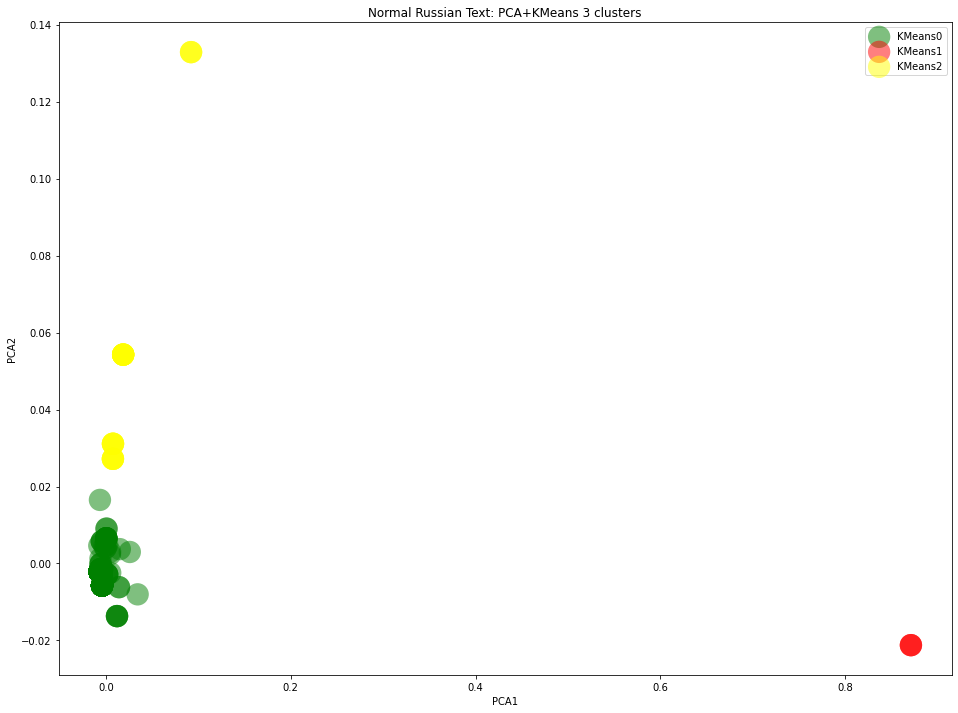

,cluster,0,1
0,0,-0.005735,-0.000124
1,0,-0.006756,-0.002131
2,0,-0.006756,-0.002131
3,0,0.004439,0.002364
4,0,-0.006700,-0.002098
5,0,-0.006756,-0.002131
6,0,-0.006756,-0.002131
7,0,-0.006756,-0.002131
8,0,-0.004178,-0.005737
9,0,-0.006652,-0.002070


100%|██████████| 3/3 [02:15<00:00, 45.29s/it]


In [74]:
ru_clusters = series_to_cluster(ru_files,'rus')


  0%|          | 0/5 [00:00<?, ?it/s]

[array([-0.00538732, -0.0060948 , -0.00645606, -0.00490894,  0.01773244,
        0.002119  , -0.00048123,  0.00265442, -0.00733023, -0.01211813,
       -0.00180087,  0.00716233,  0.0025304 , -0.00691348, -0.00050415,
        0.00396405,  0.00406746, -0.0040211 ]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.00422598, -0.00109713, -0.00319101,
       -0.00853757,  0.00248667,  0.00048512, -0.00340805, -0.00114717,
        0.00424603, -0.00362913, -0.00698103,  0.00138333, -0.00173627,
        0.00348088, -0.0036557 ,  0.00048678]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 

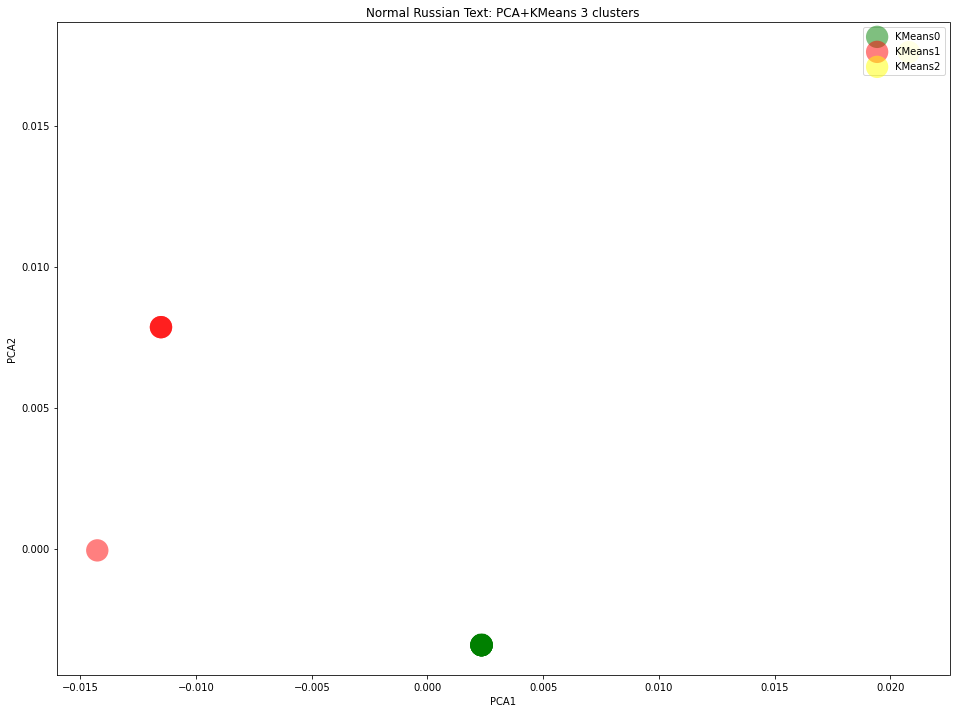

,cluster,0,1
0,2,0.020808,0.017613
1,0,0.002335,-0.003428
2,0,0.002335,-0.003428
3,0,0.002335,-0.003428
4,0,0.002335,-0.003428
5,1,-0.011519,0.007855
6,0,0.002335,-0.003428
7,0,0.002335,-0.003428
8,1,-0.014272,-0.000066
9,0,0.002335,-0.003428


 20%|██        | 1/5 [00:46<03:05, 46.28s/it]

[array([-4.30115466e-05, -2.31912353e-05, -4.72808590e-05, -2.33321106e-05,
       -1.27003166e-05, -5.73722704e-06, -2.30407510e-06, -2.00102504e-05,
       -8.33700719e-06, -2.68511980e-06,  7.84803302e-06, -1.70469429e-06,
        4.99986112e-06, -5.19270236e-06,  8.81519561e-06, -4.63719432e-06,
        4.37102148e-06, -7.24086110e-06]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-4.70640667e-05, -2.53762986e-05, -5.17356310e-05, -2.55304470e-05,
       -1.38969322e-05, -6.27778487e-06, -2.52116357e-06, -2.18956033e-05,
       -9.12251463e-06, -2.93811006e-06,  8.58746963e-06, -1.86530949e-06,
        5.47094481e-06, -5.68195543e-06,  9.64575765e-06, -5.07410778e-06,
        4.78285631e-06, -7.92309036e-06]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

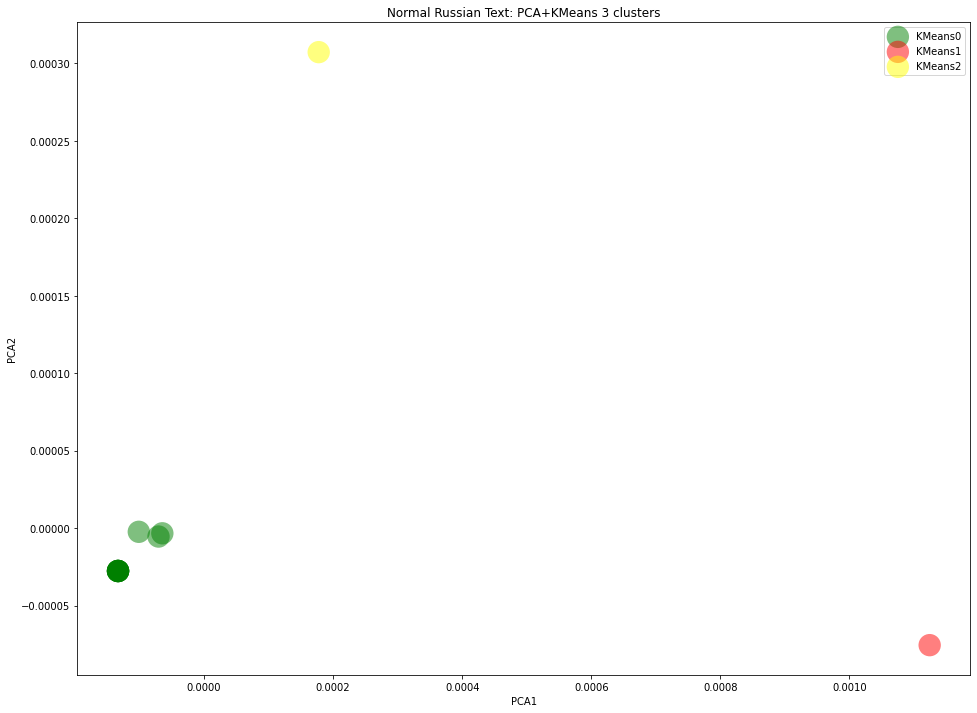

,cluster,0,1
0,0,-0.000071,-0.000005
1,0,-0.000133,-0.000028
2,0,-0.000133,-0.000028
3,0,-0.000065,-0.000003
4,0,-0.000133,-0.000028
5,0,-0.000133,-0.000028
6,2,0.000178,0.000307
7,0,-0.000133,-0.000028
8,0,-0.000101,-0.000002
9,0,-0.000133,-0.000028


 40%|████      | 2/5 [01:30<02:17, 45.76s/it]

[array([-4.70640667e-05, -2.53762986e-05, -5.17356310e-05, -2.55304470e-05,
       -1.38969322e-05, -6.27778487e-06, -2.52116357e-06, -2.18956033e-05,
       -9.12251463e-06, -2.93811006e-06,  8.58746963e-06, -1.86530949e-06,
        5.47094481e-06, -5.68195543e-06,  9.64575765e-06, -5.07410778e-06,
        4.78285631e-06, -7.92309036e-06]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.00422598, -0.00109713, -0.00319101,
       -0.00853757,  0.00248667,  0.00048512, -0.00340805, -0.00114717,
        0.00424603, -0.00362913, -0.00698103,  0.00138333, -0.00173627,
        0.00348088, -0.0036557 ,  0.00048678]), array([-2.30436883e-04, -1.24248403e-04, -2.53309974e-04, -1.25003151e-04,
       -6.80426907e-05, -3.07375303e-05, -1.23442175e-05, -1.07206090e-04,
       -4.46660049e-05, -1.43856868e-05,  4.20462971e-05, -9.13299963e-06,
        2.67870491e-05, -2.78202074e-05,  4.72279274e-05, -2.48440405e-05,
    

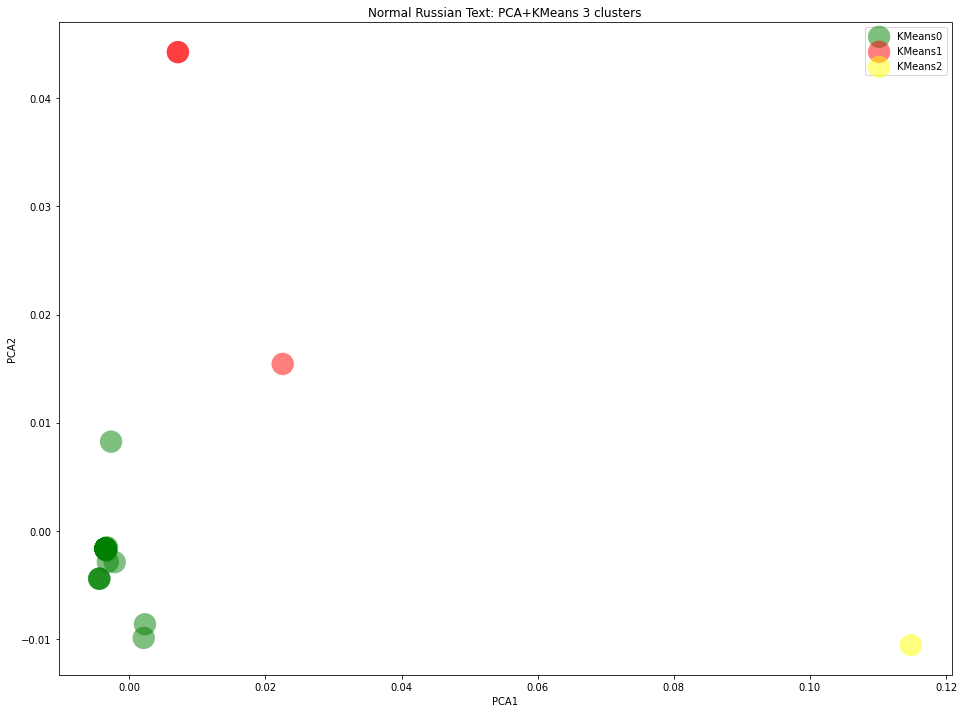

,cluster,0,1
0,0,-0.003467,-0.001640
1,0,-0.003476,-0.001639
2,0,-0.004402,-0.004417
3,0,-0.003431,-0.001641
4,0,-0.003476,-0.001639
5,0,-0.003467,-0.001640
6,0,-0.003253,-0.001518
7,0,-0.003476,-0.001639
8,0,-0.002672,0.008251
9,1,0.022547,0.015437


 60%|██████    | 3/5 [02:16<01:31, 45.78s/it]

[array([-4.76213025e-05, -2.56767525e-05, -5.23481779e-05, -2.58327260e-05,
       -1.40614711e-05, -6.35211348e-06, -2.55101400e-06, -2.21548459e-05,
       -9.23052467e-06, -2.97289711e-06,  8.68914477e-06, -1.88739464e-06,
        5.53572048e-06, -5.74922945e-06,  9.75996286e-06, -5.13418492e-06,
        4.83948505e-06, -8.01689929e-06]), array([-4.70640667e-05, -2.53762986e-05, -5.17356310e-05, -2.55304470e-05,
       -1.38969322e-05, -6.27778487e-06, -2.52116357e-06, -2.18956033e-05,
       -9.12251463e-06, -2.93811006e-06,  8.58746963e-06, -1.86530949e-06,
        5.47094481e-06, -5.68195543e-06,  9.64575765e-06, -5.07410778e-06,
        4.78285631e-06, -7.92309036e-06]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

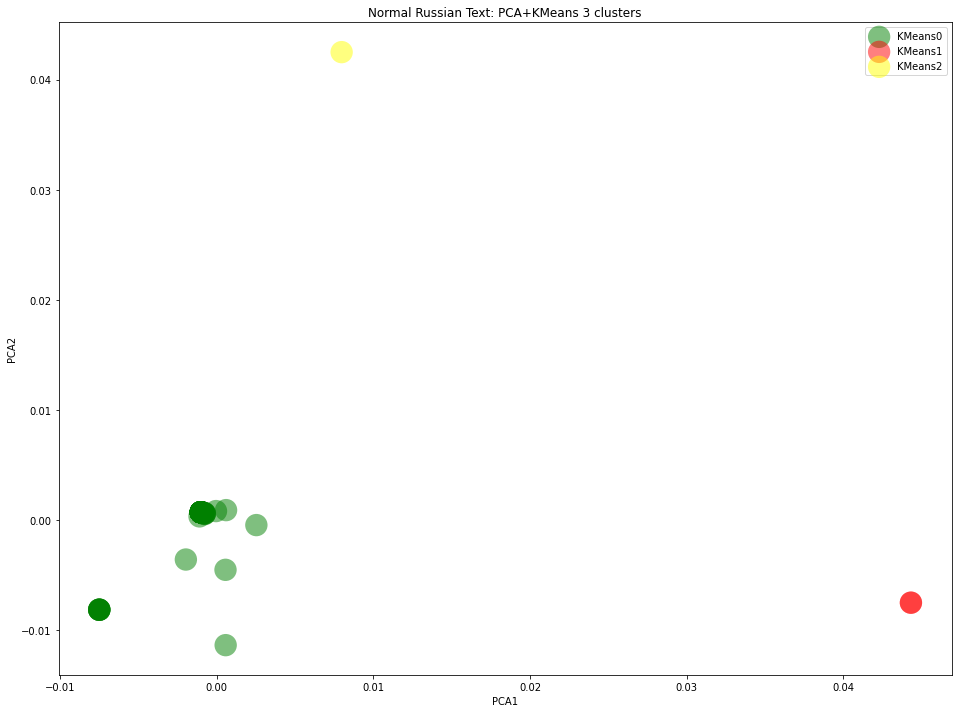

,cluster,0,1
0,0,-0.000965,0.000718
1,0,-0.000965,0.000718
2,0,-0.001012,0.000734
3,0,-0.001012,0.000734
4,0,-0.001012,0.000734
5,0,-0.001012,0.000734
6,1,0.044314,-0.007476
7,0,-0.001966,-0.003559
8,0,-0.007493,-0.008113
9,0,-0.001012,0.000734


 80%|████████  | 4/5 [03:02<00:45, 45.81s/it]

[array([-3.37300699e-04, -4.69598446e-05, -2.21010394e-04, -2.64557199e-05,
       -9.14945013e-05,  3.30352873e-05,  5.10903091e-05,  7.79191946e-05,
       -4.49183826e-05,  4.25736960e-05, -4.89415889e-06, -3.79415799e-05,
        8.31198552e-05, -6.33669980e-05, -7.64290221e-05, -9.98611244e-05,
       -6.81091464e-05,  1.86646450e-05]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-2.79691124e-04, -2.57078608e-05, -1.95612818e-04, -5.49263471e-05,
       -9.58311604e-05,  2.93494348e-05,  6.98004595e-05,  6.85488060e-05,
       -7.76963183e-05, -4.01870408e-05,  1.53295766e-05, -6.32806088e-05,
        6.76507085e-05, -4.33370156e-05, -2.12509392e-05, -9.16321018e-05,
       -3.42652601e-05,  5.21259713e-06]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00106882, -0.00025801, -0.00090708, -0.00177866,  0.00045229,
        0.00065966,  0.00014251, -0.00184363, -0.0003992 ,  0.000

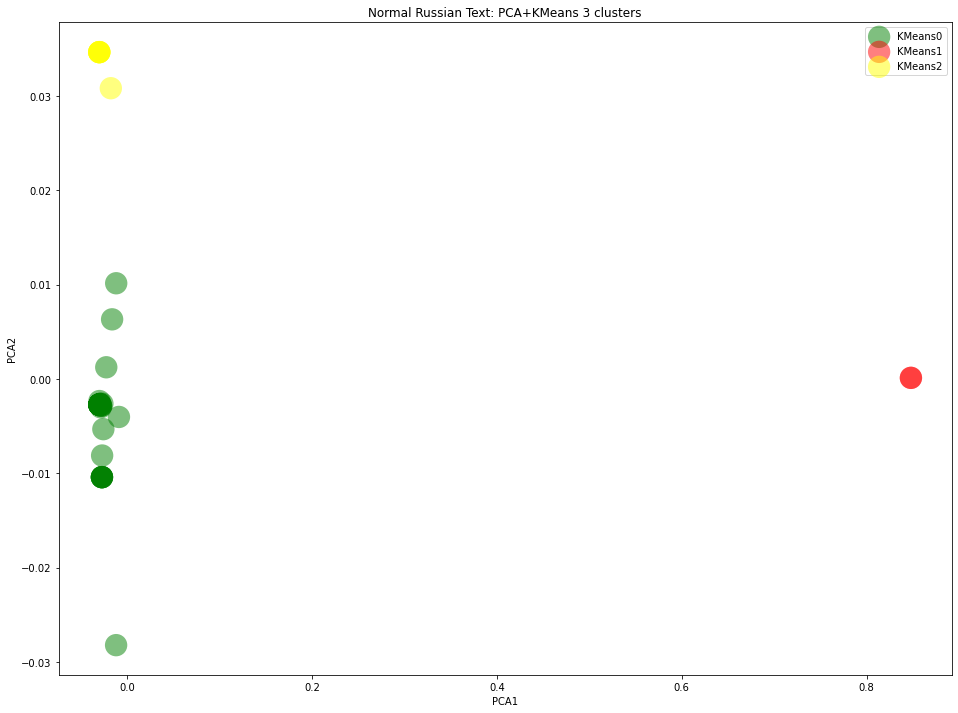

,cluster,0,1
0,0,-0.029461,-0.002691
1,0,-0.029837,-0.002717
2,0,-0.029548,-0.002718
3,0,-0.029837,-0.002717
4,0,-0.028230,-0.002833
5,0,-0.029205,-0.002636
6,0,-0.011761,0.010159
7,0,-0.027195,-0.010409
8,0,-0.029837,-0.002717
9,0,-0.029837,-0.002717


  0%|          | 0/5 [00:00<?, ?it/s]

[array([-4.29669947e-04,  1.14102673e-04, -3.94091317e-05, -5.71300976e-05,
        4.70148334e-05,  4.68532081e-04, -1.71047142e-05,  1.94196560e-04]), array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-0.24715657, -0.00816322,  0.04060709,  0.03929834, -0.02428873,
        0.04313505, -0.00498113,  0.02204261]), array([-0.04682796, -0.01281701,  0.01840599,  0.01097945, -0.0110916 ,
        0.00723131,  0.00244292,  0.00917194]), array([-0.00761847, -0.00513283,  0.00717971,  0.00093149, -0.00680368,
       -0.0015655 ,  0.00014597, -0.0012818 ]), array([-0.03808265,  0.01199405, -0.0067608 , -0.00516762,  0.00327126,
        0.01671487, -0.00314295,  0.00941205]), array([-9.87245546e-04,  1.97350802e-04, -2.73541594e-04, -3.94470121e-05,
        6.34529756e-05,  6.49296014e-04,  5.66569431e-04,  2.54600707e-04]), array([-1.14356306e-03,  3.17692049e-04, -1.21433298e-04, -2.56485275e-04,
        1.63257826e-

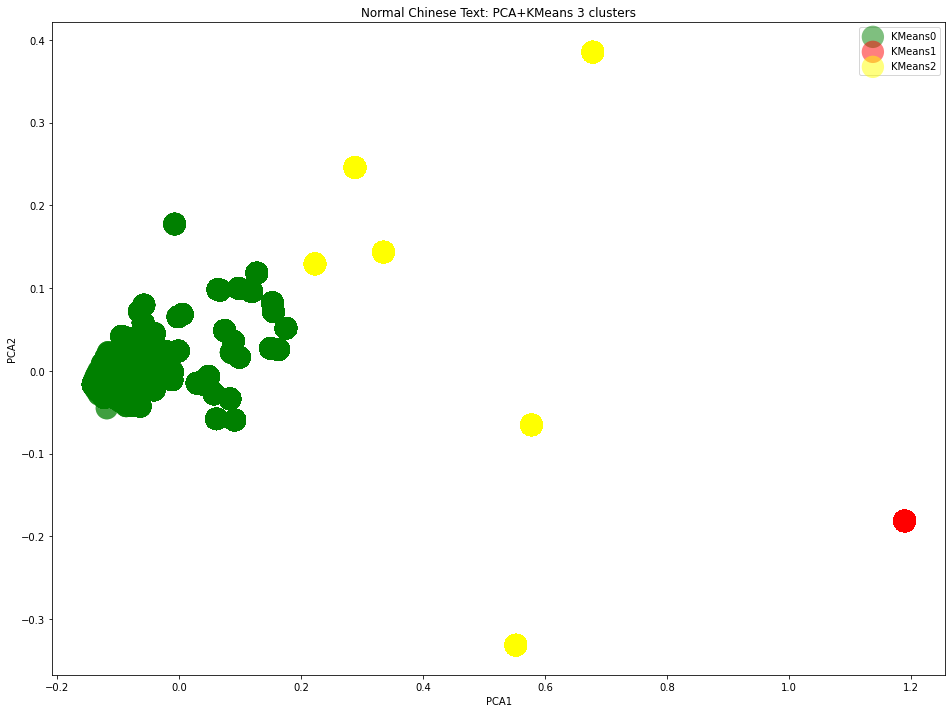

 20%|██        | 1/5 [01:02<04:09, 62.28s/it]

[array([-2.60152728e-04,  6.70182083e-05, -1.26836315e-05, -2.55600480e-04,
        9.95557276e-05, -6.65242305e-05, -1.49517544e-04, -9.59543795e-05]), array([-0.07067966, -0.03030328,  0.01067095,  0.0113493 ,  0.00044464,
        0.00110724,  0.00725607,  0.00300857]), array([-1.00541044e-03, -1.05642023e-03,  2.09856645e-04,  2.07541247e-04,
       -8.71023844e-04, -2.85848698e-04,  7.39493441e-05, -2.20678736e-04]), array([-0.00246208, -0.00364875,  0.00113684,  0.00083016, -0.00181459,
       -0.00066659, -0.00024087, -0.00015993]), array([-3.29253270e-03, -1.66400476e-03,  9.59786048e-04,  1.79550383e-03,
        1.55242154e-03, -8.24070374e-04,  1.95297439e-05, -6.45246925e-04]), array([-0.02481319,  0.00959734, -0.00694111, -0.0061279 ,  0.00385106,
       -0.00716573,  0.00062639,  0.00016138]), array([-3.71262511e-03, -9.78931156e-04,  1.29969788e-03,  2.25537951e-03,
       -1.31272285e-03, -4.29916294e-04, -2.31149987e-03,  5.89749517e-05]), array([-0.08041634,  0.01914189

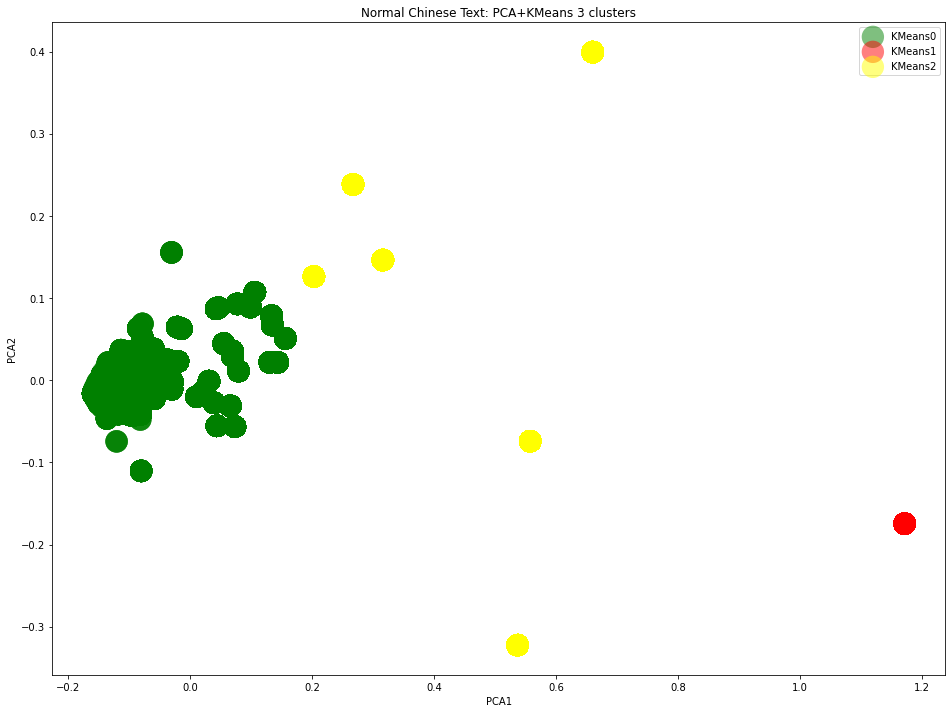

 40%|████      | 2/5 [02:51<03:49, 76.41s/it]

[array([-0.04021007,  0.02059223, -0.01962825,  0.00362318,  0.00283012,
       -0.03327043,  0.01703883, -0.02706891]), array([-0.07235282,  0.0456077 , -0.05369712,  0.08309634, -0.01466064,
        0.00812108, -0.06649483, -0.00510962]), array([-1.92341530e-04,  6.18144648e-05, -2.67912988e-05, -1.61561953e-04,
        5.48997318e-05, -1.41373465e-04, -6.54008284e-05,  1.36327820e-04]), array([-3.46285924e-04, -3.70949966e-04,  3.33303937e-04,  7.43597518e-05,
       -4.57476974e-04, -1.25279728e-04, -2.04685701e-05, -5.50335511e-05]), array([-0.04021007,  0.02059223, -0.01962825,  0.00362318,  0.00283012,
       -0.03327043,  0.01703883, -0.02706891]), array([-0.07235282,  0.0456077 , -0.05369712,  0.08309634, -0.01466064,
        0.00812108, -0.06649483, -0.00510962]), array([-0.01551436,  0.00763791, -0.00749871,  0.00385944,  0.00092352,
       -0.00962878,  0.01736099, -0.01308646]), array([-0.04549425, -0.02716786,  0.01282921,  0.00630262, -0.01238631,
       -0.00110507, -0.

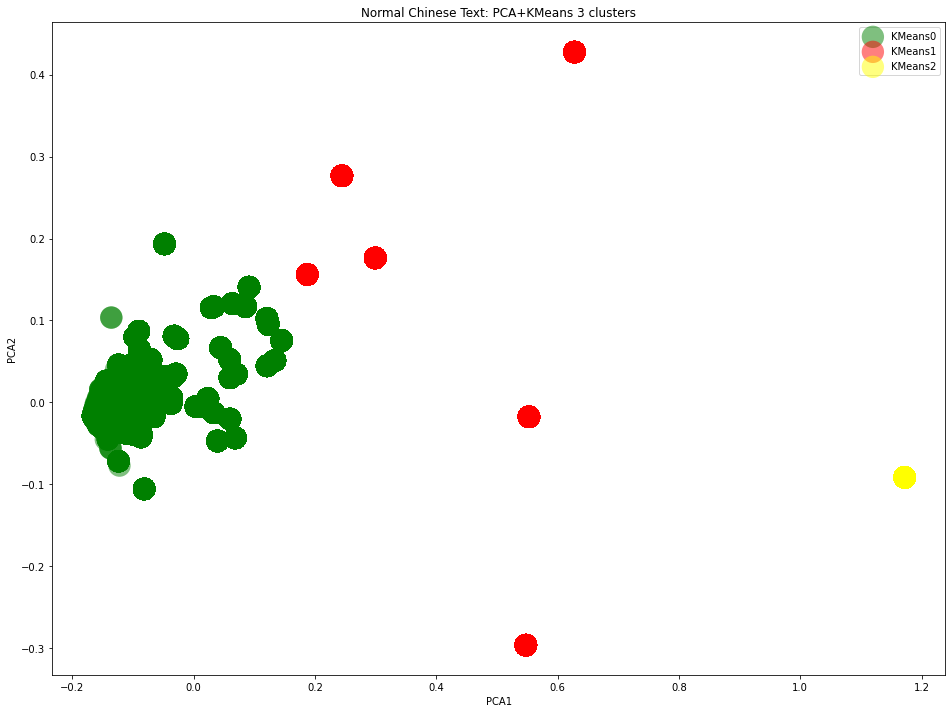

 60%|██████    | 3/5 [05:05<03:07, 93.63s/it]

[array([-0.00573095, -0.00567828,  0.00348089,  0.00072303, -0.00435821,
       -0.00166962, -0.00065992, -0.00087034]), array([-0.01383623, -0.00135311,  0.00071505,  0.00061556, -0.00189831,
        0.00263421,  0.00143312, -0.00169008]), array([-1.83712760e-03,  1.51551835e-04,  4.15153428e-05,  4.44321439e-04,
        6.18355669e-04,  5.30487936e-04,  1.10004177e-03, -4.94443400e-05]), array([-1.49621903e-03,  7.92475418e-04, -1.05173986e-03,  1.73273028e-03,
       -2.44424628e-04,  7.21286061e-04, -2.18877855e-03, -4.83979735e-05]), array([-0.0042949 ,  0.00024258, -0.00015687,  0.00260974,  0.00174479,
        0.00015395, -0.00229382, -0.0006208 ]), array([-0.00296581, -0.00726373, -0.0025108 ,  0.00050494,  0.00061125,
        0.00029068,  0.00051605,  0.00024502]), array([-0.03022679,  0.00833067, -0.00465583, -0.00841488,  0.00370777,
       -0.00015176, -0.00165007, -0.00529094]), array([-0.05234367,  0.01224866, -0.002238  , -0.0332733 ,  0.01199044,
        0.01073025, -0.

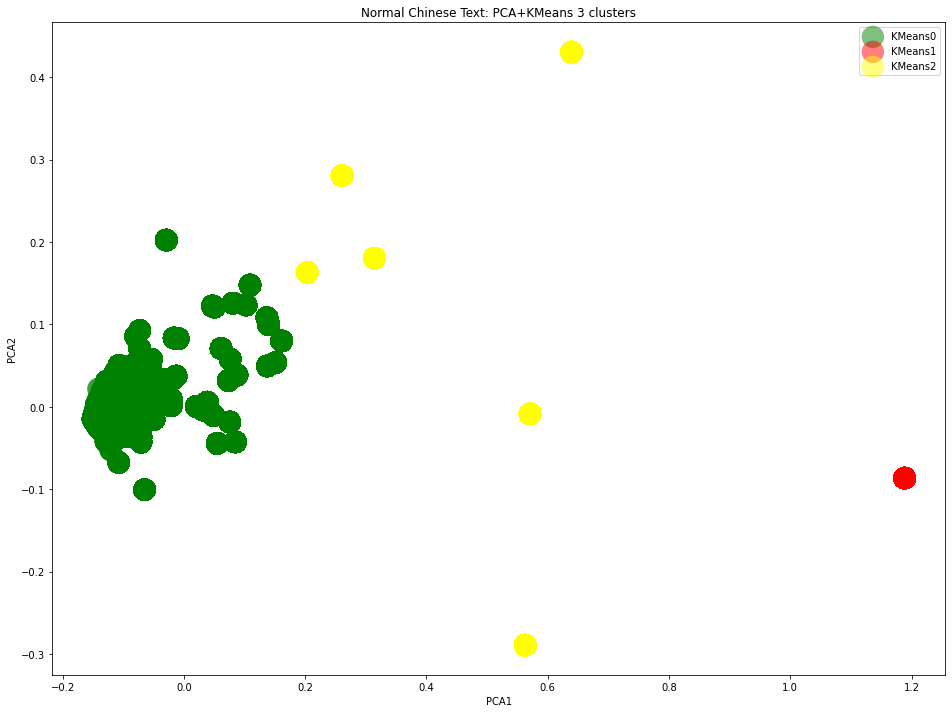

 80%|████████  | 4/5 [08:19<02:03, 123.89s/it]

[array([-4.29669947e-04,  1.14102673e-04, -3.94091317e-05, -5.71300976e-05,
        4.70148334e-05,  4.68532081e-04, -1.71047142e-05,  1.94196560e-04]), array([-0.00310891,  0.00061737, -0.00106788,  0.00232782, -0.00123947,
        0.00161477, -0.00320401, -0.00017769]), array([-0.0271901 ,  0.00812839, -0.00670395,  0.00076431, -0.00238619,
       -0.00166114, -0.01082345,  0.00856127]), array([-0.0356294 ,  0.02441858, -0.03054214,  0.05713152, -0.01133768,
        0.01774718, -0.05173985,  0.0023145 ]), array([-0.04901559,  0.00774367,  0.00047063, -0.0071802 , -0.01565507,
       -0.00982843,  0.00875619,  0.00617006]), array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-2.23324130e-02, -4.54278469e-05,  8.89164418e-04,  2.00437425e-03,
       -3.47357731e-04, -1.07406926e-03,  1.94494452e-03, -3.80071284e-03]), array([-1.68057091e-03,  4.35015660e-04, -3.44850926e-04,  1.91748425e-05,
        2.45291077e-

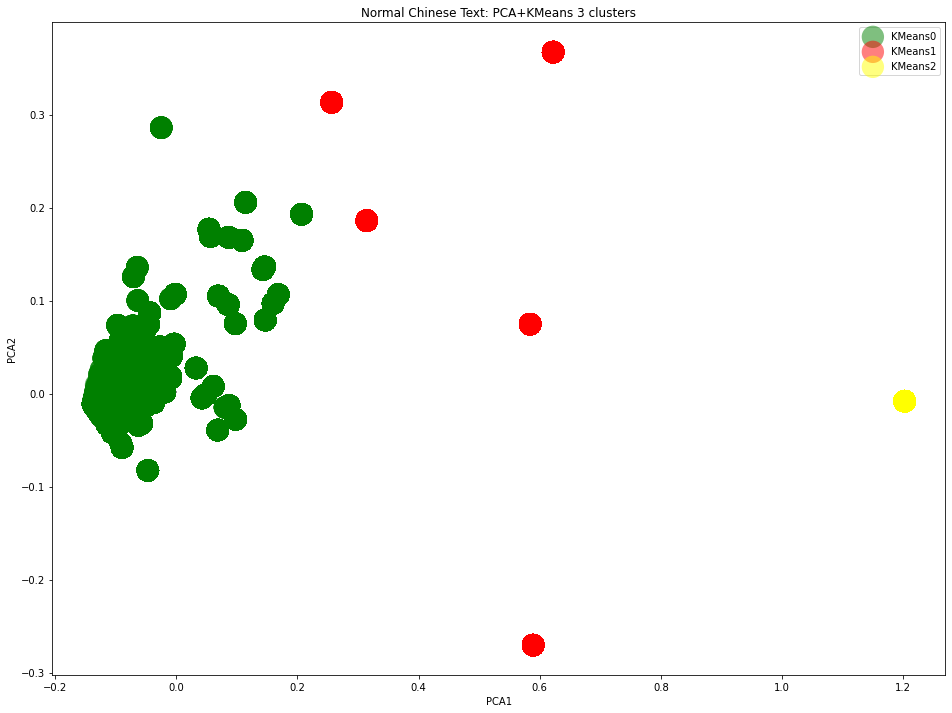

  0%|          | 0/5 [00:00<?, ?it/s]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

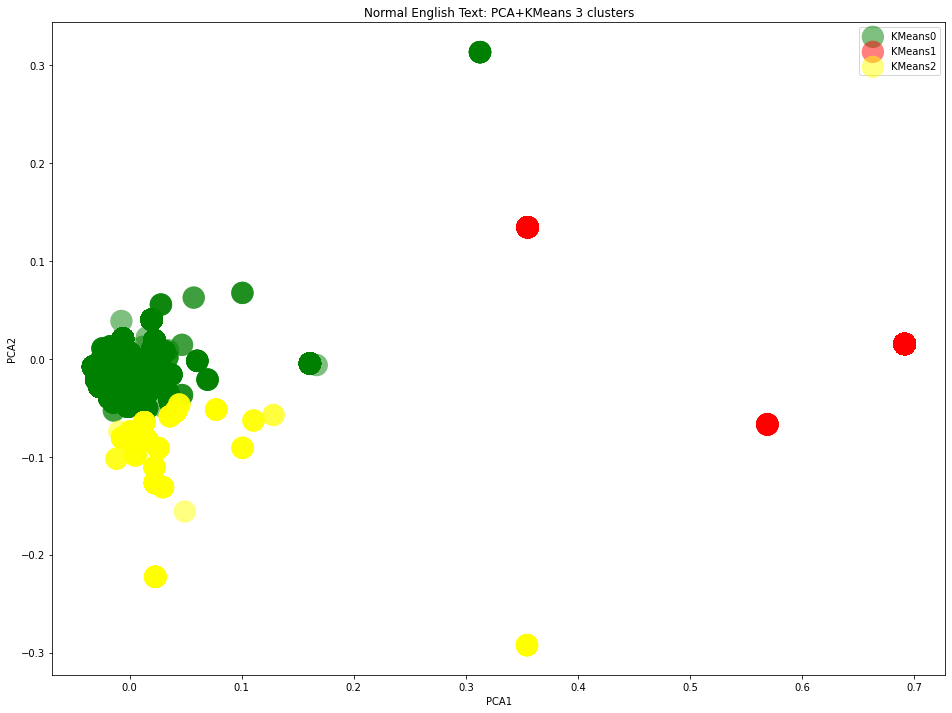

 20%|██        | 1/5 [02:00<08:01, 120.39s/it]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-2.05780034e-02,  1.85652463e-02, -1.01972900e-02, -6.01742685e-04,
       -1.16353087e-02, -1.06822659e-05, -1.05983580e-02, -9.65071101e-03]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([

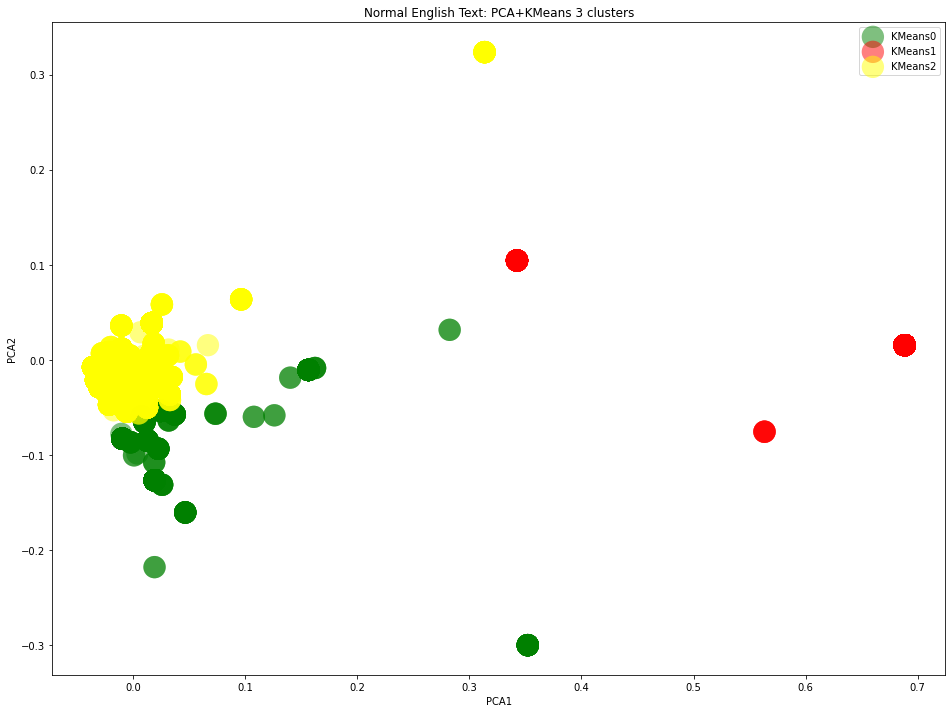

 40%|████      | 2/5 [03:56<05:56, 118.96s/it]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

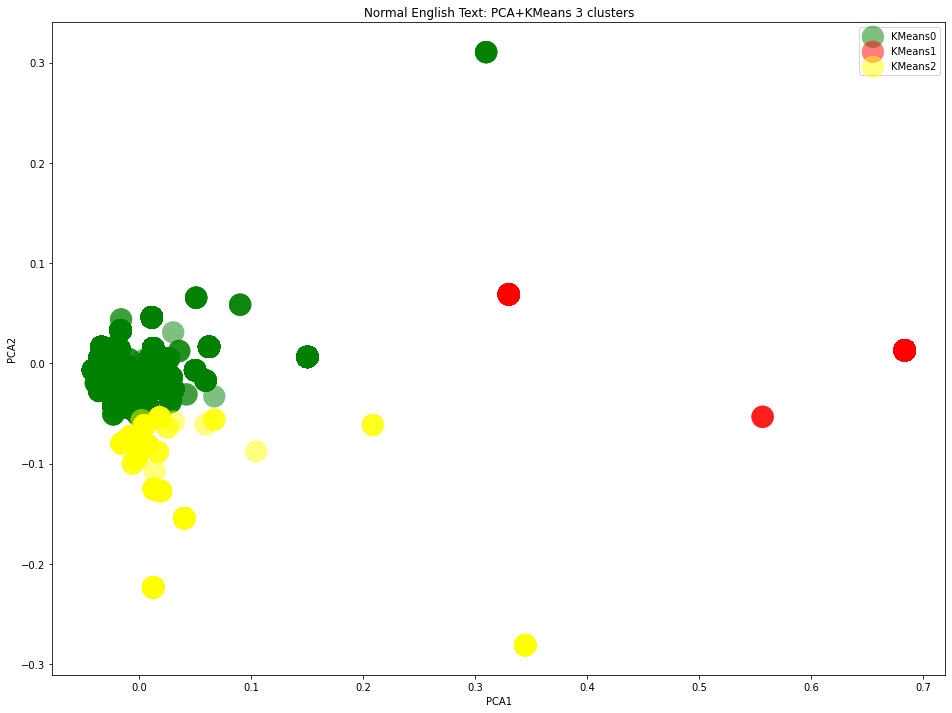

 60%|██████    | 3/5 [06:54<04:33, 136.79s/it]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.06782238,  0.05310814, -0.02858744, -0.0109557 , -0.00734296,
        0.07785295,  0.04719373, -0.00911355]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

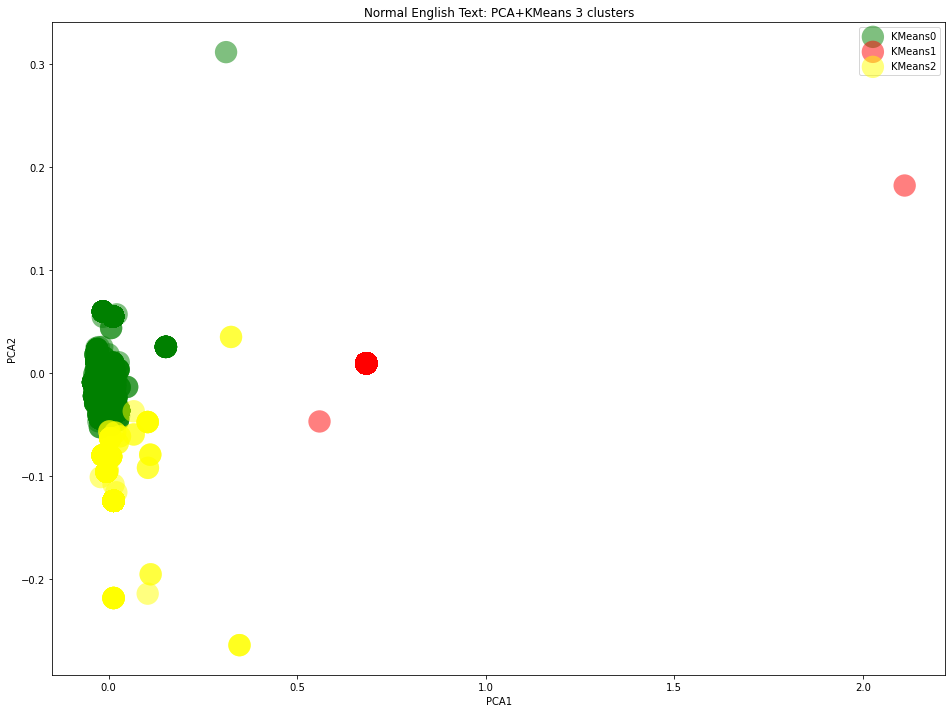

 80%|████████  | 4/5 [07:57<01:54, 114.61s/it]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

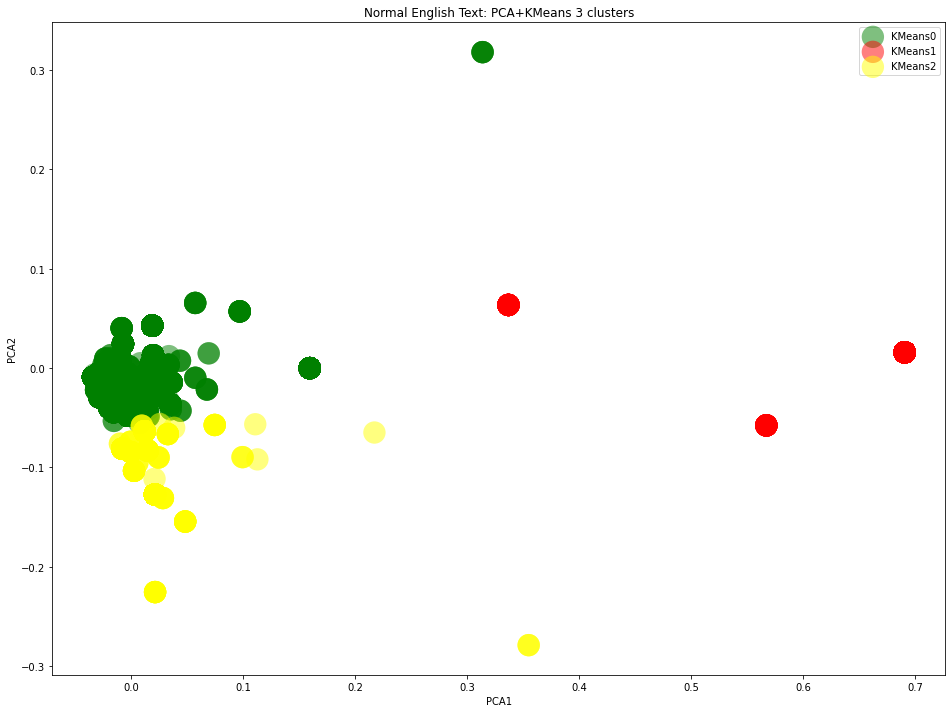

100%|██████████| 5/5 [11:04<00:00, 132.94s/it]


In [34]:
ru_clusters = series_to_cluster(ru_files,'rus')
chi_clusters = series_to_cluster(chi_files,'chi')
eng_clusters = series_to_cluster(eng_files,'eng')

In [75]:
eng_clusters.shape,chi_clusters.shape,ru_clusters.shape

((371398, 5), (1001374, 5), (2155, 5))

In [76]:
df = pd.DataFrame()
for c in [eng_clusters,chi_clusters,ru_clusters]:
  df = df.append(c)
df

,cluster,0,1,lang,is_bot
0,0,-0.018431,0.007271,eng,0
1,0,-0.018431,0.007271,eng,0
2,0,-0.018431,0.007271,eng,0
3,0,-0.018431,0.007271,eng,0
4,0,-0.018431,0.007271,eng,0
...,...,...,...,...,...
574,0,-0.006756,-0.002131,rus,0
575,0,-0.006756,-0.002131,rus,0
576,0,-0.006756,-0.002131,rus,0
577,0,-0.006756,-0.002131,rus,0


In [77]:
#Remove duplicates
df = df.drop_duplicates(['cluster','0','1','lang'])
df.tail(5)

,cluster,0,1,lang,is_bot
212,0,-0.006219,-0.001920,rus,0
226,0,-0.006329,-0.002071,rus,0
232,0,-0.006222,-0.001859,rus,0
576,0,-0.006756,-0.002131,rus,0
578,0,-0.006756,-0.002131,rus,0


In [78]:
#Save normal text clusters
df.to_csv('/content/drive/MyDrive/ML_Project4/sub/clusters_normal.csv',index=False)

In [79]:
#Read normal text clusters
df = pd.read_csv('/content/drive/MyDrive/ML_Project4/sub/clusters_normal.csv')
df

,cluster,0,1,lang,is_bot
0,0,-0.018431,0.007271,eng,0
1,0,-0.018431,0.007271,eng,0
2,0,-0.018431,0.007271,eng,0
3,0,-0.018431,0.007271,eng,0
4,0,-0.018431,0.007271,eng,0
...,...,...,...,...,...
53874,0,-0.006219,-0.001920,rus,0
53875,0,-0.006329,-0.002071,rus,0
53876,0,-0.006222,-0.001859,rus,0
53877,0,-0.006756,-0.002131,rus,0


In [38]:
bot_files = glob.glob('/content/drive/MyDrive/ML_Project4/sub/*')
bot_files = [f for f in bot_files if 'bot' in f.split('/')[-1]]
bot_files

['/content/drive/MyDrive/ML_Project4/sub/chi_bot.txt',
 '/content/drive/MyDrive/ML_Project4/sub/eng_bot.txt',
 '/content/drive/MyDrive/ML_Project4/sub/chi_bot1.txt',
 '/content/drive/MyDrive/ML_Project4/sub/chi_bot2.txt',
 '/content/drive/MyDrive/ML_Project4/sub/eng_bot1.txt',
 '/content/drive/MyDrive/ML_Project4/sub/eng_bot2.txt',
 '/content/drive/MyDrive/ML_Project4/sub/ru_bot1.txt',
 '/content/drive/MyDrive/ML_Project4/sub/ru_bot2.txt',
 '/content/drive/MyDrive/ML_Project4/sub/ru_bot.txt']

  0%|          | 0/3 [00:00<?, ?it/s]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.67483626, -0.12423078, -0.15918416, -0.03001041, -0.14236713,
       -0.01620726,  0.06723674,  0.14669239]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.001

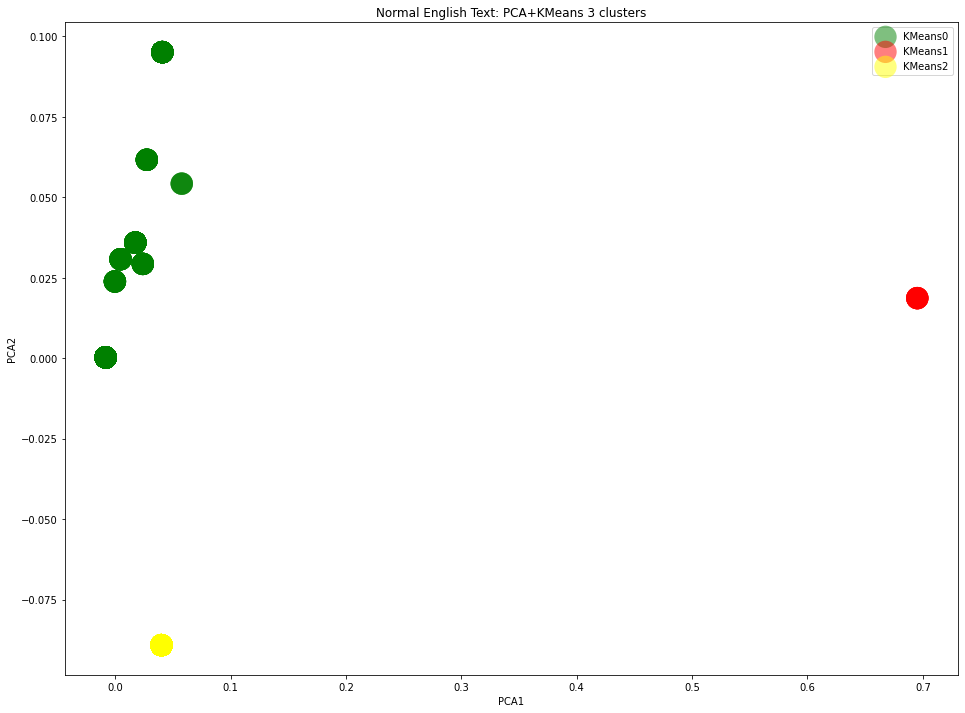

 33%|███▎      | 1/3 [00:47<01:35, 47.64s/it]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.05548537,  0.05690754, -0.02364612, -0.0233425 , -0.01344877,
       -0.00762159,  0.01584969,  0.01852931]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-9.21671573e-02, -1.18210701e-02,  8.43387235e-02, -2.93576701e-05,
       -5.01643159e-02,  2.87925680e-03, -5.54333583e-02, -2.05601531e-02]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([

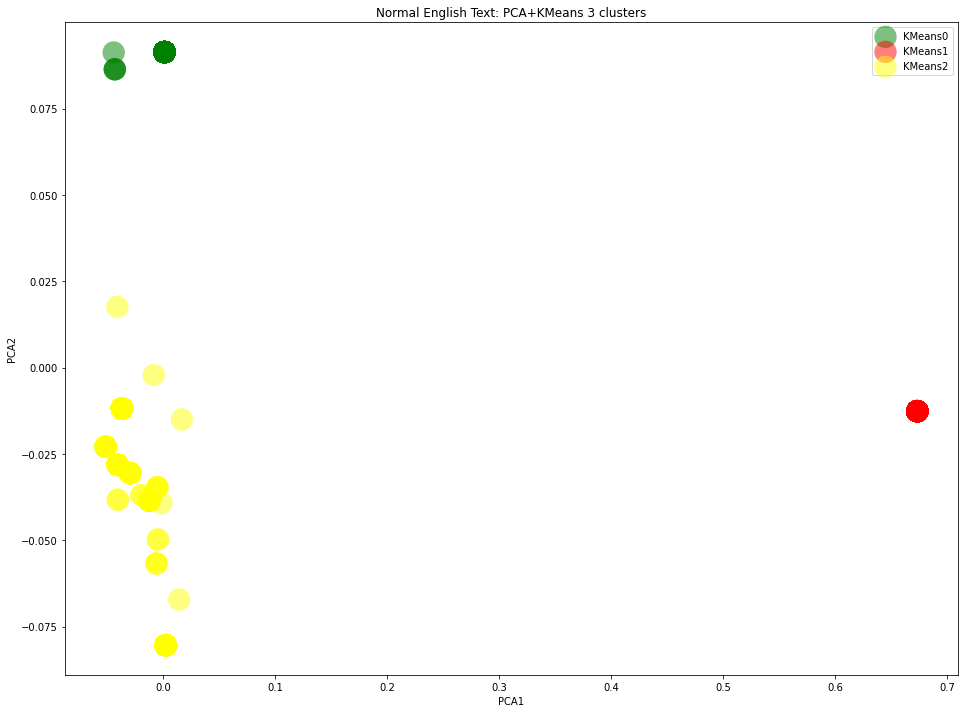

 67%|██████▋   | 2/3 [01:38<00:48, 48.57s/it]

[array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-0.67483626, -0.12423078, -0.15918416, -0.03001041, -0.14236713,
       -0.01620726,  0.06723674,  0.14669239]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([-9.21671573e-02, -1.18210701e-02,  8.43387235e-02, -2.93576701e-05,
       -5.01643159e-02,  2.87925680e-03, -5.54333583e-02, -2.05601531e-02]), array([-0.0328445 , -0.00470535, -0.0010956 ,  0.02255539, -0.02583739,
       -0.01541535, -0.01981455, -0.02372901]), array([

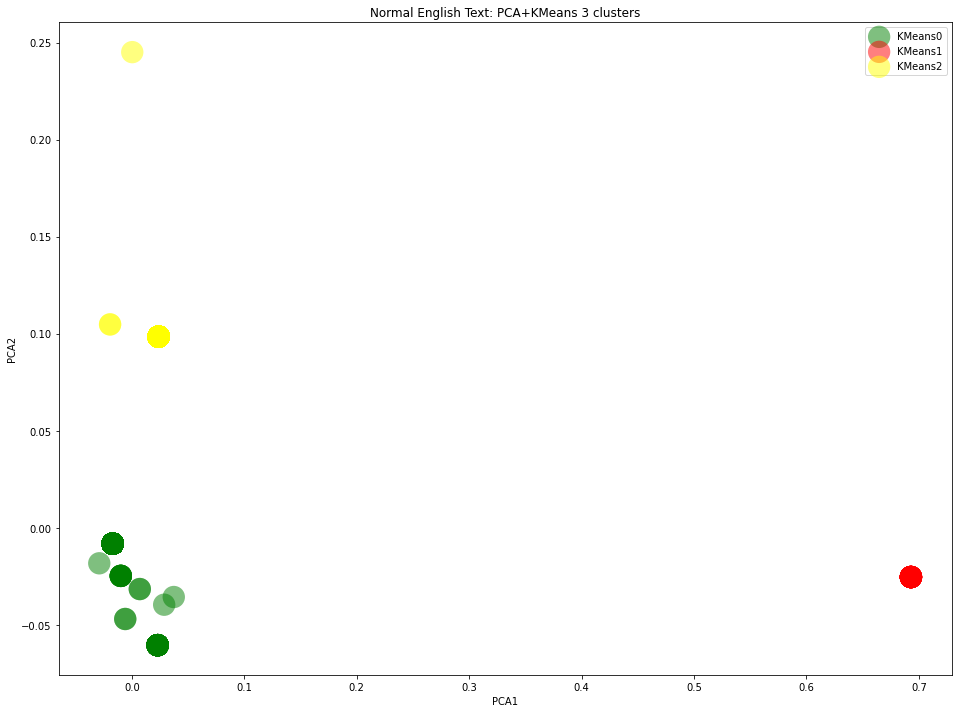

  0%|          | 0/3 [00:00<?, ?it/s]

[array([-0.02705025, -0.00506015, -0.01586792, -0.01850904, -0.0024864 ,
       -0.00822338, -0.00197854, -0.00665201, -0.0073753 ,  0.00516954,
        0.00163211, -0.00034912,  0.00552601, -0.00291097, -0.00388859,
       -0.00550909, -0.0015333 , -0.00127811]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.00378767, -0.00950547,  0.00422598, -0.00109713, -0.00319101,
       -0.00853757,  0.00248667,  0.00048512, -0.00340805, -0.00114717,
        0.00424603, -0.00362913, -0.00698103,  0.00138333, -0.00173627,
        0.00348088, -0.0036557 ,  0.00048678]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 

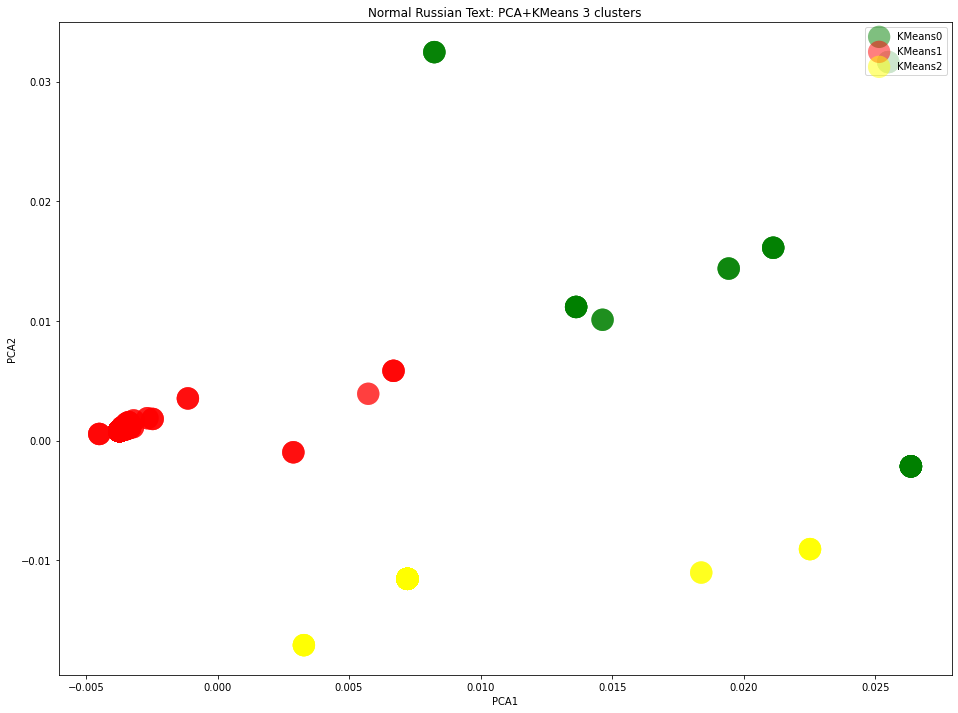

,cluster,0,1
0,0,0.021121,0.016126
1,1,-0.003735,0.000801
2,1,-0.003735,0.000801
3,1,-0.003735,0.000801
4,2,0.007218,-0.011548
5,1,-0.003735,0.000801
6,1,-0.003735,0.000801
7,1,-0.003735,0.000801
8,1,-0.003694,0.000831
9,1,-0.003735,0.000801


 33%|███▎      | 1/3 [00:45<01:31, 45.55s/it]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-0.62809956, -0.10658987, -0.19399989, -0.04957799,  0.03002634,
        0.10645987,  0.11868649, -0.09429511, -0.20740577,  0.26219961,
       -0.04711578, -0.1279083 ,  0.17618214, -0.062096  , -0.33417292,
        0.0562477 , -0.09577981, -0.01653847]), array([0., 0., 0., 0., 0., 0., 

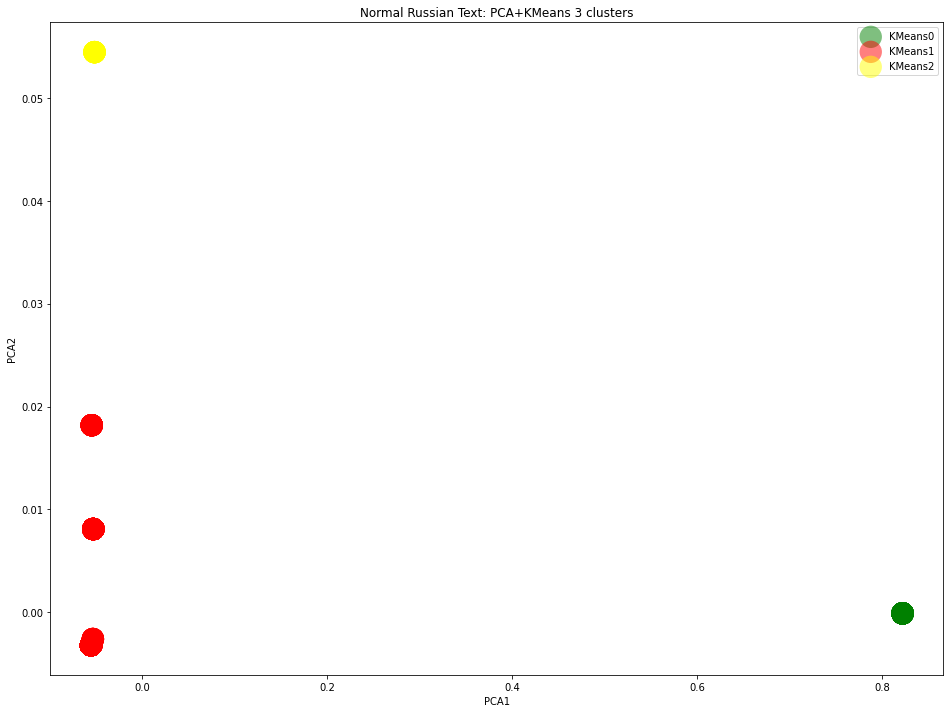

,cluster,0,1
0,1,-0.055599,-0.003201
1,1,-0.055599,-0.003201
2,1,-0.055599,-0.003201
3,1,-0.055599,-0.003201
4,1,-0.055599,-0.003201
5,1,-0.055599,-0.003201
6,1,-0.055599,-0.003201
7,1,-0.055599,-0.003201
8,0,0.822291,-0.000113
9,1,-0.055599,-0.003201


 67%|██████▋   | 2/3 [01:31<00:45, 45.79s/it]

[array([-5.83039827e-03, -6.45323713e-03,  1.13513453e-02, -5.93103161e-03,
        9.62140248e-03, -2.47333287e-03,  7.72277401e-03,  1.48227573e-03,
       -4.57433664e-05, -3.76257314e-03, -8.73803961e-03, -7.33030652e-03,
       -2.06566142e-02,  9.92473356e-04, -6.43595858e-03, -1.12117019e-02,
        8.64914046e-03, -1.55737519e-02]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.]), array([-1.08134640e-02, -3.04963895e-04, -6.00012023e-03, -6.56953795e-03,
       -4.37786582e-03, -2.57972734e-03,  4.15960680e-05,  1.65090542e-03,
       -5.29696865e-03,  2.11547933e-03, -1.13913420e-04,  1.52422666e-03,
        4.93964965e-03, -2.13600552e-03, -7.68415192e-04, -2.59448318e-03,
        6.20871593e-03,  1.68476138e-03]), array([-5.29784428e-05, -2.85652489e-05, -5.82370661e-05, -2.87387687e-05,
       -1.56433109e-05, -7.06669206e-06, -2.83798935e-06, -2.4

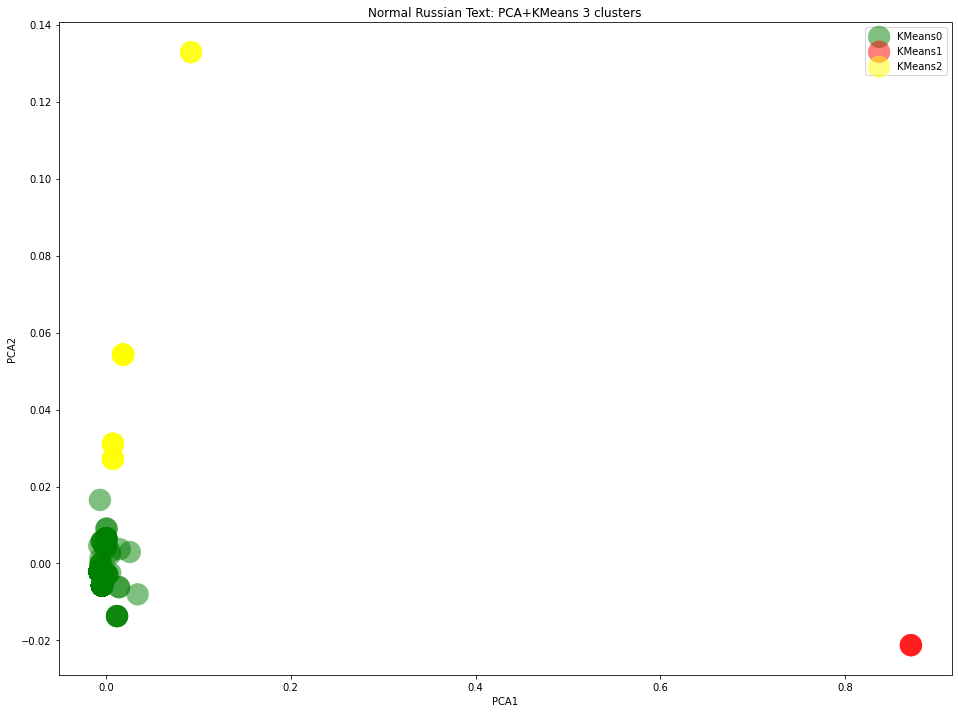

,cluster,0,1
0,0,-0.005735,-0.000124
1,0,-0.006756,-0.002131
2,0,-0.006756,-0.002131
3,0,0.004439,0.002364
4,0,-0.006700,-0.002098
5,0,-0.006756,-0.002131
6,0,-0.006756,-0.002131
7,0,-0.006756,-0.002131
8,0,-0.004178,-0.005737
9,0,-0.006652,-0.002070


  0%|          | 0/3 [00:00<?, ?it/s]

[array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-0.24715657, -0.00816322,  0.04060709,  0.03929834, -0.02428873,
        0.04313505, -0.00498113,  0.02204261]), array([-0.04549425, -0.02716786,  0.01282921,  0.00630262, -0.01238631,
       -0.00110507, -0.00129243, -0.00273832]), array([-0.30979284, -0.06220626,  0.04399292, -0.00828249, -0.02320219,
        0.00074927, -0.03193363, -0.0173497 ]), array([-0.23118251, -0.14303009,  0.08583094,  0.06799996,  0.03043201,
       -0.02857151,  0.00891372,  0.01793585]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.01896324, -0.02676165,  0.02201117,  0.01798399,  0.01853628,
       -0.00650479,  0.00047015, -0.0009577 ]), array([-0.02652268, -0.02027232,  0.005

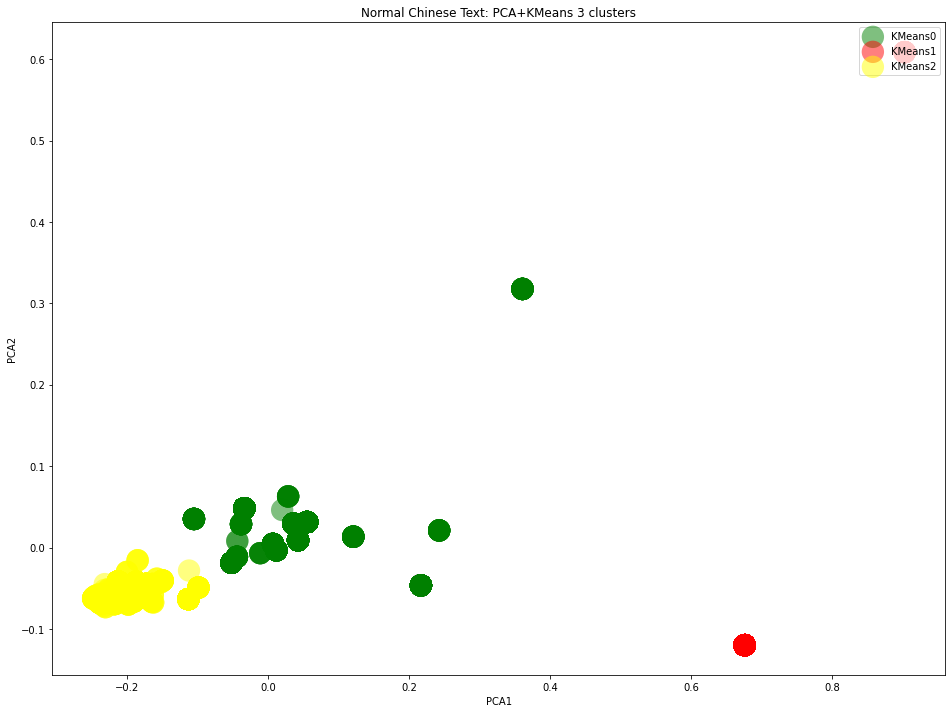

 33%|███▎      | 1/3 [00:44<01:28, 44.36s/it]

[array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-0.24715657, -0.00816322,  0.04060709,  0.03929834, -0.02428873,
        0.04313505, -0.00498113,  0.02204261]), array([-0.04549425, -0.02716786,  0.01282921,  0.00630262, -0.01238631,
       -0.00110507, -0.00129243, -0.00273832]), array([-0.30979284, -0.06220626,  0.04399292, -0.00828249, -0.02320219,
        0.00074927, -0.03193363, -0.0173497 ]), array([-0.23118251, -0.14303009,  0.08583094,  0.06799996,  0.03043201,
       -0.02857151,  0.00891372,  0.01793585]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.01896324, -0.02676165,  0.02201117,  0.01798399,  0.01853628,
       -0.00650479,  0.00047015, -0.0009577 ]), array([-0.02652268, -0.02027232,  0.005

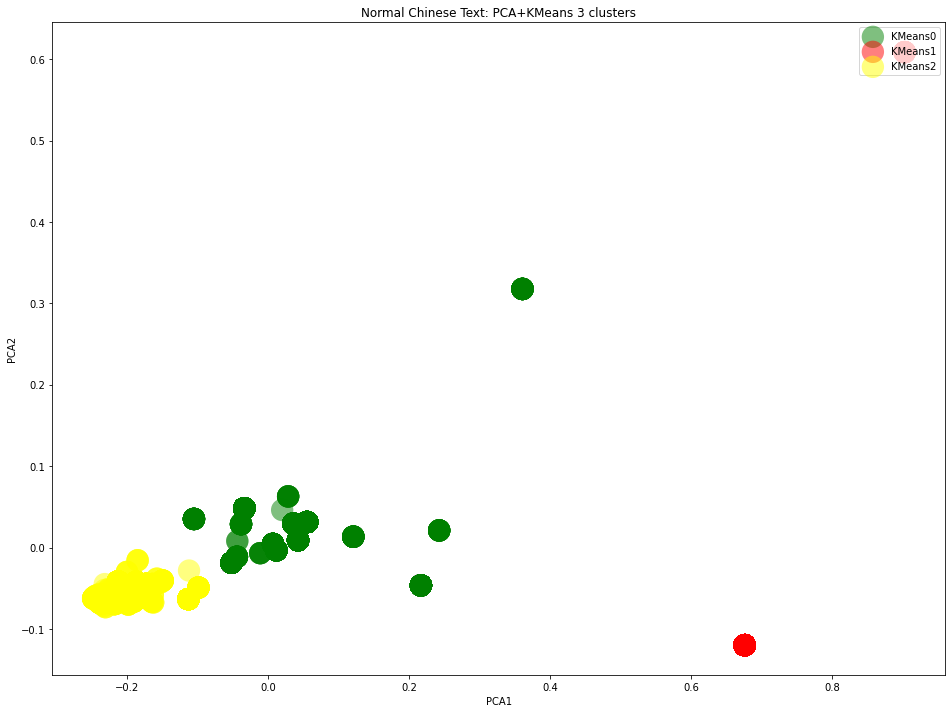

 67%|██████▋   | 2/3 [01:28<00:44, 44.25s/it]

[array([-0.71975005,  0.02141727, -0.06273661,  0.15410656,  0.03106034,
        0.04469464, -0.00951821,  0.0097942 ]), array([-0.24715657, -0.00816322,  0.04060709,  0.03929834, -0.02428873,
        0.04313505, -0.00498113,  0.02204261]), array([-0.04549425, -0.02716786,  0.01282921,  0.00630262, -0.01238631,
       -0.00110507, -0.00129243, -0.00273832]), array([-0.30979284, -0.06220626,  0.04399292, -0.00828249, -0.02320219,
        0.00074927, -0.03193363, -0.0173497 ]), array([-0.23118251, -0.14303009,  0.08583094,  0.06799996,  0.03043201,
       -0.02857151,  0.00891372,  0.01793585]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.32734489, -0.05359262,  0.00132657, -0.01493898, -0.03091344,
       -0.04371455,  0.01298903, -0.0186833 ]), array([-0.01896324, -0.02676165,  0.02201117,  0.01798399,  0.01853628,
       -0.00650479,  0.00047015, -0.0009577 ]), array([-0.02652268, -0.02027232,  0.005

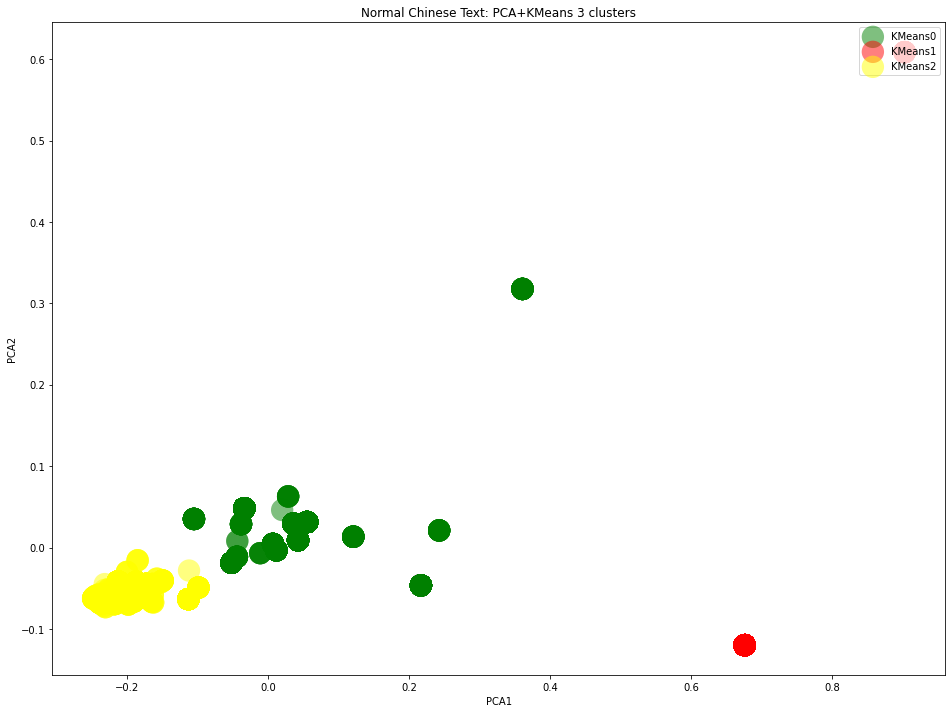

100%|██████████| 3/3 [02:12<00:00, 44.08s/it]


In [39]:
eng_files = [f for f in bot_files if 'eng' in f.split('/')[-1]]
ru_files = [f for f in bot_files if 'ru' in f.split('/')[-1]]
chi_files = [f for f in bot_files if 'chi' in f.split('/')[-1]]

eng_bot_cluster = series_to_cluster(eng_files,'eng',is_bot=1)
ru_bot_cluster = series_to_cluster(ru_files,'rus',is_bot=1)
chi_bot_cluster = series_to_cluster(chi_files,'chi',is_bot=1)

In [40]:
eng_bot_cluster.shape,ru_bot_cluster.shape,chi_bot_cluster.shape

((5931, 5), (2155, 5), (12393, 5))

In [80]:
for c in [eng_bot_cluster,ru_bot_cluster,chi_bot_cluster]:
  df = df.append(c)
df

,cluster,0,1,lang,is_bot
0,0,-0.018431,0.007271,eng,0
1,0,-0.018431,0.007271,eng,0
2,0,-0.018431,0.007271,eng,0
3,0,-0.018431,0.007271,eng,0
4,0,-0.018431,0.007271,eng,0
...,...,...,...,...,...
4126,0,-0.033145,0.048332,chi,1
4127,0,-0.033145,0.048332,chi,1
4128,2,-0.186262,-0.042250,chi,1
4129,0,0.042877,0.009017,chi,1


In [90]:
df = df.drop_duplicates(['cluster','0','1','lang'])
df.to_csv('/content/drive/MyDrive/ML_Project4/sub/clusters_bot_and _normal.csv',index=False)
df

,cluster,0,1,lang,is_bot
0,0,-0.018431,0.007271,eng,0
1,0,-0.018431,0.007271,eng,0
2,0,-0.018431,0.007271,eng,0
3,0,-0.018431,0.007271,eng,0
4,0,-0.018431,0.007271,eng,0
...,...,...,...,...,...
73703,2,-0.186360,-0.049734,chi,1
73725,2,-0.241068,-0.063179,chi,1
73829,2,-0.246677,-0.062003,chi,1
74064,2,-0.245870,-0.061968,chi,1


In [91]:
df = pd.read_csv('/content/drive/MyDrive/ML_Project4/sub/clusters_bot_and _normal.csv')
df

,cluster,0,1,lang,is_bot
0,0,-0.018431,0.007271,eng,0
1,0,-0.018431,0.007271,eng,0
2,0,-0.018431,0.007271,eng,0
3,0,-0.018431,0.007271,eng,0
4,0,-0.018431,0.007271,eng,0
...,...,...,...,...,...
54491,2,-0.186360,-0.049734,chi,1
54492,2,-0.241068,-0.063179,chi,1
54493,2,-0.246677,-0.062003,chi,1
54494,2,-0.245870,-0.061968,chi,1


In [92]:
df.lang.unique()

array(['eng', 'chi', 'rus'], dtype=object)

In [113]:
#Simple categorical variables mapping
df1=df.copy()
dt = {'eng':0,'rus':1,'chi':2}
df1['lang'] = df1['lang'].map(dt)
df1.columns = ['cluster','dimension_0','dimension_1','lang','is_bot']
df1

,cluster,dimension_0,dimension_1,lang,is_bot
0,0,-0.018431,0.007271,0,0
1,0,-0.018431,0.007271,0,0
2,0,-0.018431,0.007271,0,0
3,0,-0.018431,0.007271,0,0
4,0,-0.018431,0.007271,0,0
...,...,...,...,...,...
54491,2,-0.186360,-0.049734,2,1
54492,2,-0.241068,-0.063179,2,1
54493,2,-0.246677,-0.062003,2,1
54494,2,-0.245870,-0.061968,2,1


## Model Training and Prediction

In [94]:
df1.is_bot.value_counts() #Check  target distribution,very imbalanced as small amount of bot text is used due to running out of time

0    53872
1      624
Name: is_bot, dtype: int64

In [114]:
from sklearn.model_selection import train_test_split

tr, val = train_test_split(df1, test_size=0.4, random_state=42)

y_tr = tr.is_bot
y_val = val.is_bot
x_tr = tr.drop(['is_bot'], axis=1)
x_val = val.drop(['is_bot'], axis=1)

In [115]:
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, matthews_corrcoef, precision_score, recall_score, f1_score

def compute_metrics(y_test, y_pred):
    print('Accuracy: {:.5f}'.format(accuracy_score(y_test, y_pred)))
    print('F1-score: {:.5f}'.format(f1_score(y_test, y_pred)))
    print('Precision: {:.5f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.5f}'.format(recall_score(y_test, y_pred)))
    print('Accuracy (balanced): {:.5f}'.format(balanced_accuracy_score(y_test, y_pred)))
    print('MCC: {:.5f}'.format(matthews_corrcoef(y_test, y_pred)))
def compute_confusion_matrix(y_test, y_pred):
    compute_metrics(y_test, y_pred)
    return pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=[0, 1]),
        columns=['a(x) = 1', 'a(x) = 0'],
        index=['y = 1', 'y = 0'],
    ).T

In [125]:
import lightgbm as lgb
lgb= lgb.LGBMClassifier(random_state=13)
lgb.fit(x_tr,y_tr)
y_pred = lgb.predict(x_val)
print(f'LGBMClassifier: \n {compute_confusion_matrix(y_val, y_pred)}')

Accuracy: 0.99610
F1-score: 0.82828
Precision: 0.84362
Recall: 0.81349
Accuracy (balanced): 0.90586
MCC: 0.82645
LGBMClassifier: 
           y = 1  y = 0
a(x) = 1  21509     47
a(x) = 0     38    205


In [126]:
import xgboost as xgb
xgb=xgb.XGBClassifier(random_state=13)
xgb.fit(x_tr,y_tr)
y_pred = xgb.predict(x_val)
print(f'XgboostClassifier: \n {compute_confusion_matrix(y_val, y_pred)}')

Accuracy: 0.99661
F1-score: 0.83556
Precision: 0.94949
Recall: 0.74603
Accuracy (balanced): 0.87278
MCC: 0.84006
XgboostClassifier: 
           y = 1  y = 0
a(x) = 1  21537     64
a(x) = 0     10    188


In [116]:
rfc = RandomForestClassifier(random_state=13)
rfc.fit(x_tr,y_tr)
y_pred = rfc.predict(x_val)
print(f'RandomForestClassifier: \n {compute_confusion_matrix(y_val, y_pred)}')

Accuracy: 0.99711
F1-score: 0.87221
Precision: 0.89212
Recall: 0.85317
Accuracy (balanced): 0.92598
MCC: 0.87097
RandomForestClassifier: 
           y = 1  y = 0
a(x) = 1  21521     37
a(x) = 0     26    215


Consider the F1-score, random forest classifier outperforms lgbm and xgboost with the highest score 0.872. Then, we will test for balanced samples with random forest classifier.

Since the target variable is imbalanced, we use undersampling and oversampling to predict the results again.


In [117]:
ros = TomekLinks(random_state=42)
x_tr1, y_tr1 = ros.fit_resample(x_tr, y_tr)
rfc.fit(x_tr1,y_tr1)
y_pred = rfc.predict(x_val)
print(f'RandomForestClassifier: \n {compute_confusion_matrix(y_val, y_pred)}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.99683
F1-score: 0.86756
Precision: 0.84015
Recall: 0.89683
Accuracy (balanced): 0.94741
MCC: 0.86643
RandomForestClassifier: 
           y = 1  y = 0
a(x) = 1  21504     26
a(x) = 0     43    226


In [118]:
ros = RandomOverSampler(random_state=42)
x_tr1, y_tr1 = ros.fit_resample(x_tr, y_tr)
rfc.fit(x_tr1,y_tr1)
y_pred = rfc.predict(x_val)
print(f'RandomForestClassifier: \n {compute_confusion_matrix(y_val, y_pred)}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.99683
F1-score: 0.86602
Precision: 0.84791
Recall: 0.88492
Accuracy (balanced): 0.94153
MCC: 0.86462
RandomForestClassifier: 
           y = 1  y = 0
a(x) = 1  21507     29
a(x) = 0     40    223


The results did not improve. For further studies, we need to take more bot text to improve the models and other classification models, e.g. SVM can be used with k-fold validation.

## Model Explanation

In [119]:
#Source:https://www.kaggle.com/prashant111/random-forest-classifier-feature-importance
#Visualize the feature importance
feature_scores = pd.Series(rfc.feature_importances_, index=x_tr.columns).sort_values(ascending=False)

feature_scores

dimension_0    0.364954
cluster        0.314795
dimension_1    0.281459
lang           0.038792
dtype: float64

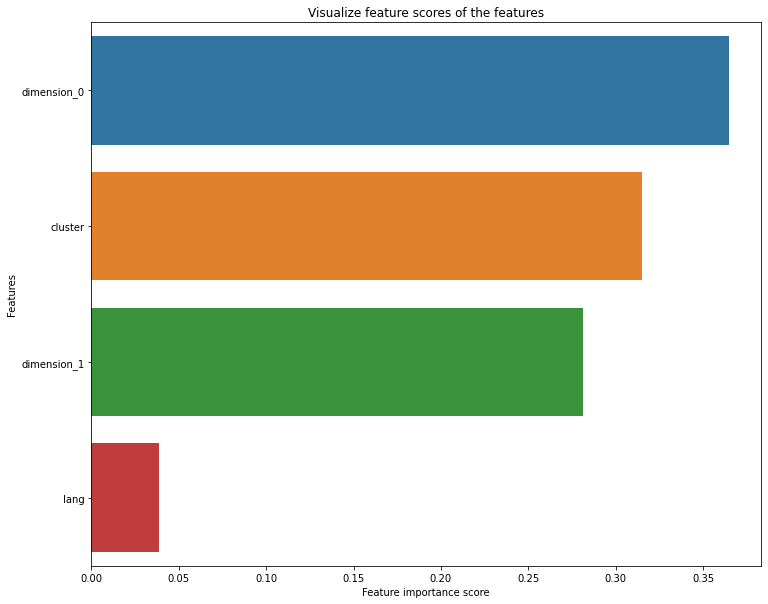

In [120]:
# Creating a seaborn bar plot
import seaborn as sns
f, ax = plt.subplots(figsize=(12, 10))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

The feature importance selected by the random forest classifier shows that the most important feature is dimension_0, followed by cluster, dimension_1 and languages. This shows that the time-series and clustering results influences the most for spotting a bot text, regardless of any languages. The feature selection by the classifier matches our approach. 

## Summary

To conclude, we observed that if the shape of clustering tends to be like a vertical line with distant dots, such as two groups out of three clusters can be seperated by a vertical line,the more likely the text is generated by bot after applying the KMeans-clustering and PCA to the time-series of raw normal text and bot text. <br>Then, the cluster data was labeled into bot text and human text for classification. After data cleansing and simple feature engineering, we trained a random forest model, lightgbm model and xgboost model and the random forest model achieved the best f1-score 0.872 for the test dataset among all three models.<br>  For further studies, this proposal needs to be investigated with more texts, different clustering method for various languages and reducing the series to a higher dimension may need to be apply to the cluster data to make the approach more robust for other bot text generator.